This EDA nb is using occurrence tables e-mailed from Tiago on 9/27 (duplicated, with rotated lat and long columns)

## Imports + Loading In Data

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [80]:
# %pip install openpyxl

In [81]:
# Loading in data w/ rotated coordinates
rep = pd.read_excel('reptilia_occ_genus.xlsm', engine='openpyxl')
syn = pd.read_excel('synapsida_occ_genus.xlsm', engine='openpyxl')
tem = pd.read_excel('temnospondyli_occ_genus.xlsm', engine='openpyxl')

In [82]:
rep['county'].isna().sum()

1495

In [83]:
rep['county'].value_counts()

county
Apache                    234
Comanche                  152
Rio Arriba                 88
Franklin                   78
Gloucestershire            67
                         ... 
Malmyzh                     1
Anson                       1
Sa√É¬¥ne-et-Loire           1
Huesca                      1
Aliwal North Commonage      1
Name: count, Length: 355, dtype: int64

## Saving Nulls as CSV's

In [84]:
# Seeing how many nulls are in each column will help us decide which columns to drop
nulls_rep = rep.isna().sum()
nulls_syn = syn.isna().sum()
nulls_tem = tem.isna().sum()

# Concatenating the nulls into a single dataframe based on a shared index
# This will allow us to compare the nulls across the three datasets
nulls = pd.concat([nulls_rep, nulls_syn, nulls_tem], axis=1)
nulls.columns = ['Reptilia', 'Synapsida', 'Temnospondyli']

nulls.to_csv('nulls.csv')

In [85]:
# len of nulls df is diff from len of columns in rep
# which means there are columns that are not shared
len(nulls.index), len(rep.columns)

(119, 94)

In [86]:
# Finding which columns rep, syn, and tem do not share
# Crude code, just to see if there are any differences, not finding all differences
# Because any not-shared columns wouldn't be included in the analysis anyway

if rep.columns.all() == syn.columns.all() == tem.columns.all():
    print('All columns are the same')
else:
    diff = rep.columns.difference(syn.columns).difference(tem.columns)
    print(diff)

Index(['abund_in_sediment', 'artifacts', 'component_comments', 'concentration',
       'fossilsfrom1', 'fossilsfrom2', 'lagerstatten', 'lithadj2', 'localbed',
       'localsection', 'minor_lithology2', 'orientation', 'reference_no.x',
       'temporal_resolution'],
      dtype='object')


## Confirming that these are Datasets w/ duplicated rows (eda_duplicates)

In [87]:
# Loading in datasets that I had previously duplicated (i.e., the output of eda_duplicates.ipynb)
rep_old = pd.read_csv('occurrence_tables_1/reptilia_dup.csv')
syn_old = pd.read_csv('occurrence_tables_1/synapsida_dup.csv')
tem_old = pd.read_csv('occurrence_tables_1/temnospondyli_dup.csv')

In [88]:
# Checking that the lengths of the original and new datasets are the same
len(rep_old), len(rep), len(syn_old), len(syn), len(tem_old), len(tem)

(4411, 4411, 3422, 3422, 2247, 2247)

In [89]:
# One last double-check to make sure that the datasets are the same
# All 'abund_values' for "individuals" should be 1
individuals = rep[rep['abund_unit'] == 'individuals']
individuals['abund_value'].value_counts()

abund_value
1.0    2032
Name: count, dtype: int64

## Fixing Strings in "genus"

In [90]:
rep[rep['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

4370    Stenoscelida¬ò
Name: genus, dtype: object

In [91]:
rep.loc[rep['genus'] == 'Stenoscelida¬ò', 'genus'] = 'Stenoscelida'

In [92]:
rep[rep['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [93]:
syn[~syn['genus'].str.isalpha()]['genus']

3168    Bonacynodon 
3169    Bonacynodon 
Name: genus, dtype: object

In [94]:
has_space = ' ' in syn.at[3168, 'genus']
has_space

True

In [95]:
syn.loc[syn['genus'] == 'Bonacynodon ', 'genus'] = 'Bonacynodon'

In [96]:
syn[~syn['genus'].str.isalpha()]['genus']

Series([], Name: genus, dtype: object)

In [97]:
tem[~tem['genus'].str.isalpha()]['genus']

Series([], Name: genus, dtype: object)

## Filtering to BDNN columns

In [98]:
rep.columns

Index(['id', 'Rotated Lat', 'Rotated Lon', 'occurrence_no', 'pres_mode',
       'preservation_quality', 'common_body_parts', 'abund_value',
       'abund_unit', 'class', 'family', 'genus', 'taxon_environment',
       'life_habit', 'diet', 'early_interval', 'late_interval', 'time_bins',
       'museum', 'collection_no', 'age_max', 'age_min', 'age_median',
       'age_uncer_range', 'lng', 'lat', 'environment', 'occurrence_comments',
       'cc', 'state', 'county', 'formation', 'stratgroup', 'member', 'zone',
       'accepted_rank', 'ref_author', 'ref_pubyr', 'reference_no.x',
       'collection_name', 'collection_subset', 'collection_aka',
       'latlng_basis', 'latlng_precision', 'geogscale', 'geogcomments',
       'paleomodel', 'geoplate', 'paleoage', 'paleolng', 'paleolat',
       'paleomodel2', 'geoplate2', 'paleoage2', 'paleolng2', 'paleolat2',
       'paleomodel3', 'geoplate3', 'paleoage3', 'paleolng3', 'paleolat3',
       'protected', 'stratscale', 'localsection', 'localbed', 'st

In [99]:
# Still waiting on 'niche' info from Arielli
syn_filtered = syn[['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment', 
                    'age_max', 'age_min']]
syn_filtered.isna().sum()

id                     0
Rotated Lat            0
Rotated Lon            0
genus                  0
taxon_environment    310
age_max                0
age_min                0
dtype: int64

In [100]:
syn_filtered.shape, syn_filtered['id'].nunique()

((3422, 7), 3422)

In [101]:
syn_filtered.head()

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min
0,3422,-0.4818,-24.8936,Edaphosaurus,terrestrial,303.7,298.9
1,3421,-2.9808,-38.7628,Ophiacodon,terrestrial,290.1,283.5
2,3420,-49.4771,-10.0175,Therioherpeton,terrestrial,237.0,208.5
3,3419,5.8574,-44.6091,Ophiacodon,terrestrial,298.9,290.1
4,3418,-1.4701,-41.4649,Adelobasileus,terrestrial,227.0,208.5


In [102]:
# Still waiting on 'niche' info from Arielli
tem_filtered = tem[['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment', 
                    'age_max', 'age_min']]
tem_filtered.isna().sum()

id                    0
Rotated Lat           0
Rotated Lon           0
genus                 0
taxon_environment    14
age_max               0
age_min               0
dtype: int64

In [103]:
# Still waiting on 'niche' info from Arielli
rep_filtered = rep[['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment', 
                    'age_max', 'age_min']]
rep_filtered.isna().sum()

id                   0
Rotated Lat          0
Rotated Lon          0
genus                0
taxon_environment    0
age_max              0
age_min              0
dtype: int64

In [104]:
rep_filtered[rep_filtered['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [105]:
rep_filtered['taxon_environment'].head(20)

0     terrestrial
1     terrestrial
2     terrestrial
3     terrestrial
4     terrestrial
5     terrestrial
6     terrestrial
7     terrestrial
8     terrestrial
9     terrestrial
10    terrestrial
11    terrestrial
12    terrestrial
13    terrestrial
14    terrestrial
15    terrestrial
16    terrestrial
17    terrestrial
18    terrestrial
19    terrestrial
Name: taxon_environment, dtype: object

In [106]:
rep['environment'].head(20)

0     lacustrine - large
1     lacustrine - large
2           fissure fill
3           fissure fill
4         fluvial indet.
5     terrestrial indet.
6     terrestrial indet.
7           fissure fill
8           fissure fill
9           fissure fill
10          fissure fill
11          fissure fill
12          fissure fill
13          fissure fill
14          fissure fill
15          fissure fill
16          fissure fill
17          fissure fill
18          fissure fill
19          fissure fill
Name: environment, dtype: object

## Prepping DeepDive columns

In [107]:
rep_deepdive = rep[['id', 'genus', 'county', 'state', 'occurrence_no', 'age_max', 'age_min', 'cc']]
rep_deepdive.head()

,id,genus,county,state,occurrence_no,age_max,age_min,cc
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA


In [108]:
syn_deepdive = syn[['id', 'genus', 'county', 'state', 'occurrence_no','age_max', 'age_min', 'cc']]
tem_deepdive = tem[['id', 'genus', 'county', 'state', 'occurrence_no', 'age_max', 'age_min', 'cc']]

In [109]:
rep_deepdive[rep_deepdive['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

### 'County' and 'State' Cols EDA

#### Are 'County' Null Counts Reasonable?

In [110]:
rep_deepdive.isna().sum()

# 'county' has a lot of nulls, so I'm going to look back at the older datasets and see if that seems correct or
# if an error occurred when I was duplicating the rows

id                  0
genus               0
county           1495
state             212
occurrence_no       0
age_max             0
age_min             0
cc                  8
dtype: int64

In [111]:
# Making sure occurrence no has >1 values, since there are duplicate rows (duplicated in eda_duplicates.ipynb)
rep['occurrence_no'].value_counts()

occurrence_no
1285964    300
629477      91
1586159     37
902070      33
486411      25
          ... 
830763       1
830777       1
830855       1
830859       1
N84          1
Name: count, Length: 3145, dtype: int64

In [112]:
# Loading in my original duplication output
rep_original = pd.read_csv('occurrence_tables_1/reptilia_dup.csv')
rep_original_filtered = rep_original[['genus', 'county', 'state']]
rep_original_filtered.isna().sum()

genus        0
county    1495
state      212
dtype: int64

In [113]:
# Loading in the very first dataset (raw, no rotated lat and long)
rep_old = pd.read_csv('occurrence_tables_1/reptilia_genus_occ_all.csv', encoding = 'latin1')
rep_old_filtered = rep_old[['genus', 'county', 'state']]
rep_old_filtered.isna().sum()

genus       0
county    920
state     197
dtype: int64

#### Saving Just Duplicated Rows

In [114]:
# Saving off just the parts in the deepdive dataset that were duplicated occurrences (i.e., the rows that were duplicated in eda_duplicates.ipynb)
# Trying to see if there's a pattern in the 'county' nulls that I can fix
rep_deepdive_dups = rep_deepdive[rep_deepdive.duplicated(subset=['occurrence_no'], keep=False)]
rep_deepdive_dups.to_csv('reptilia_processed_data/reptilia_deepdive_dups.csv')

syn_deepdive_dups = syn_deepdive[syn_deepdive.duplicated(subset=['occurrence_no'], keep=False)]
syn_deepdive_dups.to_csv('synapsida_processed_data/synapsida_deepdive_dups.csv')

tem_deepdive_dups = tem_deepdive[tem_deepdive.duplicated(subset=['occurrence_no'], keep=False)]
tem_deepdive_dups.to_csv('temnospondyli_processed_data/temnospondyli_deepdive_dups.csv')

#### Fixing Nonsensical Strings in 'County' and 'State'

In [115]:
# Return rows in 'county' and 'state' columns that contain any non-letter characters
import re

# Function for outputting a CSV of unique values in a column that contain special characters
def find_special_chars(df, col, clade):
    df2 = df.copy()
    df2[col] = df2[col].fillna('') # Have to fill empty values with something to use regex
    non_letter = df2[df2[col].str.contains(r'[^a-zA-Z\s\-/\'\,\(\)]', na=False)] # Regex for non-letter characters, excluding hyphens and forward slashes
    unique = non_letter[col].unique()
    # Saving unique values to a CSV named after the clade and column
    unique_df = pd.DataFrame(unique)
    # unique_df.to_csv(f'{clade}_processed_data/{clade}_{col}_special_chars.csv') # Used this already during first run, so commenting out
    # ^ Commenting out so I don't overwrite the files I've already saved. This is just for the first run.
    return unique

In [116]:
rep_deepdive

,id,genus,county,state,occurrence_no,age_max,age_min,cc
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA
...,...,...,...,...,...,...,...,...
4406,5,Eohyosaurus,-,FSTATE,N80,247.200,242.0,ZA
4407,4,Mesosuchus,-,ECAPE,N81,247.200,242.0,ZA
4408,3,Mesosuchus,-,ECAPE,N82,247.200,242.0,ZA
4409,2,Mesosuchus,-,ECAPE,N83,247.200,242.0,ZA


In [117]:
# Reptilia
find_special_chars(rep_deepdive, 'county', 'reptilia'), find_special_chars(rep_deepdive, 'state', 'reptilia')

(array(['Valle Fert√É¬≠l', 'Valle F√É¬©rtil', 'Vend√É¬©e',
        'Wei√É¬üenburg-Gunzenhausen', 'S√É¬£o Gabriel', 'L√É¬∂rrach',
        'Portel√É¬¢ndia', 'Perol√É¬¢ndia', 'S√É¬£o Mateus do Sul',
        'Tatu√É¬≠', 'Rebou√É¬ßas', 'Candel√É¬°ria', 'N√É¬ºrnberger Land',
        'Schw√É¬§bisch Hall', 'S√É¬£o Pedro do Sul', 'G√É¬∂ttingen',
        'Sa√É¬¥ne-et-Loire', 'Baden-W√É¬ºrttemberg', 'Th√É¬ºringen',
        'T√É¬ºbingen', 'S√É¬¢one-et-Loire', 'H√É¬©rault',
        'S√É¬£o Jo√É¬£o do Pol√É¬™sine', 'Yuan√¢¬Ä¬ôan',
        'Tarnowskie G√É¬≥ry', 'Arroio do S¬õ', 'Linha S?o Luiz',
        'Toroqu√ø', 'Ribeir?o', 'Rinc?o dos Weiss', 'Acegu√ø',
        'Sesmaria do Pinhal 1',
        'cff Rafael prov√øvel material do MNRJ se sao os mesmo do livro tombo, Alemoa',
        'Cerrito?', 'Sesmaria do Pinhal 2', 'V√ørzea do Agudo',
        '?gua Negra', 'BR 158 federal road', 'Porto Mariante 2',
        'Sao Jose?', 'Sao Jose? (embaixo do cemit?rio coletado por Price)'],
       dtype=object),
 

In [118]:
# Temnospondyli
find_special_chars(tem_deepdive, 'county', 'temnospondyli'), find_special_chars(tem_deepdive, 'state', 'temnospondyli')

(array(['Wei√É¬üeritzkreis', 'Schw√É¬§bisch Hall', 'T√É¬ºbingen',
        'Sa√É¬¥ne-et-Loire', 'S√É¬£o Jo√É¬£o do Pol√É¬™sine',
        'S√É¬£o Gabriel', 'Valle F√É¬©rtil', 'S?o Jer¬ìnimo da Serra',
        'Toroqu¬†'], dtype=object),
 array(['Baden-W√É¬ºrttemberg', 'Sk√É¬•ne', 'Th√É¬ºringen',
        'Azad Jammu & Kashmir', 'Rakovn√É¬≠k', 'Th√É¬ºringer Wald',
        'Th√É¬ºringia', 'Paran√É¬°', 'Baden-W√É¬ºrtteberg'], dtype=object))

In [119]:
# Synapsida
find_special_chars(syn_deepdive, 'county', 'synapsida'), find_special_chars(syn_deepdive, 'state', 'synapsida')

(array(['Valle Fert√É¬≠l', 'Sa√É¬¥ne-et-Loire', 'Wei√É¬üeritzkreis',
        'Schw√É¬§bisch Hall', 'S√É¬£o Gabriel', 'Candel√É¬°ria',
        'Kotel√¢¬Ä¬ônichskii', 'T√É¬ºbingen', '√É¬úr√É¬ºmqi', 'H√É¬©rault',
        'Valle F√É¬©rtil', 'Vila Est¬Éncia Nova', 'Linha S?o Luiz',
        'Linha S?o Luiz ', 'Sesmaria do Pinhal 1', 'V¬†rzea do Agudo',
        'Botucara¬°', 'Rinc?o do Pinhal', 'Linha V¬†rzea 2',
        'Linha V¬†rzea 1', 'Rinc?o do Semi?o ', 'Porto Mariante 2',
        'Rinc?o da Porta', 'Catu¬áaba', 'BR 158 federal road',
        'Linha Fac?o', 'Chiniqu¬†'], dtype=object),
 array(['Franch-Comt√É¬©', 'R√É¬≠o Negro', 'Baden-W√É¬ºrttemberg',
        'Rakovn√É¬≠k', 'Paran√É¬°', 'H√É¬©rault'], dtype=object))

In [120]:
# Special Characters Dictionary for Reptilia
# To map special characters to their correct values

rep_state_dict = {
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Nieder√É¬∂sterreich": "Niederosterreich",
    "T√É¬°chira": "Tachira",
    "Sa√É¬Øda": "Saida",
    "Sk√É¬•ne": "Skane",
    "Goi√É¬°s": "Goias",
    "Paran√É¬°": "Parana",
    "S√É¬£o Paulo": "Sao Paulo",
    "Cear√É¬°": "Ceara",
    "Guair√É¬°": "Guaira",
    "Bourgogne-Franche-Comt√É¬©": "Bourgogne-Franche-Comte",
    "Baden-W√É¬ºrttenburg": "Baden-Wurttemberg",
    "Nieder√É¬∂stereich": "Niederosterreich",
    "Bayern (Bavaria)": "Bayern",
    "Baden-W√É¬ºrtteberg": "Baden-Wurttemberg",
    "Baden-W√É¬ºrttemburg": "Baden-Wurttemberg",
    "Bansk√É¬° Bystrica": "Banska Bystrica",
    "Graub√É¬ºnden": "Graubunden"
}

rep_county_dict = {
    "Valle Fert√É¬≠l": "Valle Fertil",
    "Valle F√É¬©rtil": "Valle Fertil",
    "Vend√É¬©e": "Vendee",
    "Wei√É¬üenburg-Gunzenhausen": "Weissenburg-Gunzenhausen",
    "S√É¬£o Gabriel": "Sao Gabriel",
    "L√É¬∂rrach": "Lorrach",
    "Portel√É¬¢ndia": "Portelandia",
    "Perol√É¬¢ndia": "Perolandia",
    "S√É¬£o Mateus do Sul": "Sao Mateus do Sul",
    "Tatu√É¬≠": "Tatui",
    "Rebou√É¬ßas": "Reboucas",
    "Candel√É¬°ria": "Candelaria",
    "N√É¬ºrnberger Land": "Nurnberger Land",
    "Schw√É¬§bisch Hall": "Schwabisch Hall",
    "S√É¬£o Pedro do Sul": "Sao Pedro do Sul",
    "G√É¬∂ttingen": "Gottingen",
    "Sa√É¬¥ne-et-Loire": "Saone-et-Loire",
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Th√É¬ºringen": "Thuringen",
    "T√É¬ºbingen": "Tubingen",
    "S√É¬¢one-et-Loire": "Saone-et-Loire",
    "H√É¬©rault": "Herault",
    "S√É¬£o Jo√É¬£o do Pol√É¬™sine": "Sao Joao do Polesine",
    "Yuan√¢¬Ä¬ôan": "Yuan'an",
    "Tarnowskie G√É¬≥ry": "Tarnowskie Gory",
    "Arroio do S¬õ": "Arroio do So",
    "Linha S?o Luiz": "Linha Sao Luiz",
    "Toroqu√ø": "Toroqua",
    "Ribeir?o": "Ribeirao",
    "Rinc?o dos Weiss": "Rincao dos Weiss",
    "Acegu√ø": "Acegua",
    "Sesmaria do Pinhal 1": "Sesmaria do Pinhal 1",
    "cff Rafael prov√øvel material do MNRJ se sao os mesmo do livro tombo, Alemoa": "cff Rafael provavel material do MNRJ se sao os mesmo do livro tombo, Alemoa",
    "Cerrito?": "Cerrito",
    "Sesmaria do Pinhal 2": "Sesmaria do Pinhal 2",
    "V√ørzea do Agudo": "Varzea do Agudo",
    "?gua Negra": "Agua Negra",
    "BR 158 federal road": "BR 158 federal road",
    "Porto Mariante 2": "Porto Mariante 2",
    "Sao Jose?": "Sao Jose",
    "Sao Jose? (embaixo do cemit?rio coletado por Price)": "Sao Jose"
}




In [121]:
# Cleaning special characters in 'state' and 'county' columns for Reptilia
rep_deepdive_cleaned = rep_deepdive.copy()
rep_deepdive_cleaned['state'] = rep_deepdive_cleaned['state'].replace(rep_state_dict)
rep_deepdive_cleaned['county'] = rep_deepdive_cleaned['county'].replace(rep_county_dict)

# Checking to see if the cleaning worked
print(find_special_chars(rep_deepdive_cleaned, 'county', 'reptilia'))
print(find_special_chars(rep_deepdive_cleaned, 'state', 'reptilia'))

['Sesmaria do Pinhal 1' 'Sesmaria do Pinhal 2' 'BR 158 federal road'
 'Porto Mariante 2']
[]


In [122]:
# Special Characters Dictionary for Synapsida

syn_state_dict = {
    "Franch-Comt√É¬©": "Franche-Comte",
    "R√É¬≠o Negro": "Rio Negro",
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Rakovn√É¬≠k": "Rakovnik",
    "Paran√É¬°": "Parana",
    "H√É¬©rault": "Herault"
}
syn_county_dict = {
    "Valle Fert√É¬≠l": "Valle Fertil",
    "Sa√É¬¥ne-et-Loire": "Saone-et-Loire",
    "Wei√É¬üeritzkreis": "Weisseritzkreis",
    "Schw√É¬§bisch Hall": "Schwabisch Hall",
    "S√É¬£o Gabriel": "Sao Gabriel",
    "Candel√É¬°ria": "Candelaria",
    "Kotel√¢¬Ä¬ônichskii": "Kotelnichskii",
    "T√É¬ºbingen": "Tubingen",
    "√É¬úr√É¬ºmqi": "Urumqi",
    "H√É¬©rault": "Herault",
    "Valle F√É¬©rtil": "Valle Fertil",
    "Vila Est¬Éncia Nova": "Vila Estancia Nova",
    "Linha S?o Luiz": "Linha Sao Luiz",
    "Linha S?o Luiz ": "Linha Sao Luiz",
    "V¬†rzea do Agudo": "Varzea do Agudo",
    "Botucara¬°": "Botucara",
    "Rinc?o do Pinhal": "Rincao do Pinhal",
    "Linha V¬†rzea 2": "Linha Varzea 2",
    "Linha V¬†rzea 1": "Linha Varzea 1",
    "Rinc?o do Semi?o ": "Rincao do Semiao",
    "Rinc?o da Porta": "Rincao da Porta",
    "Catu¬áaba": "Catuaba",
    "Linha Fac?o": "Linha Facao",
    "Chiniqu¬†": "Chinique"
}

In [123]:
# Cleaning special characters in 'state' and 'county' columns for Reptilia
syn_deepdive_cleaned = syn_deepdive.copy()
syn_deepdive_cleaned['state'] = syn_deepdive_cleaned['state'].replace(syn_state_dict)
syn_deepdive_cleaned['county'] = syn_deepdive_cleaned['county'].replace(syn_county_dict)

# Checking to see if the cleaning worked
print(find_special_chars(syn_deepdive_cleaned, 'county', 'synapsida'))
print(find_special_chars(syn_deepdive_cleaned, 'state', 'synapsida'))

['Sesmaria do Pinhal 1' 'Linha Varzea 2' 'Linha Varzea 1'
 'Porto Mariante 2' 'BR 158 federal road']
[]


In [124]:
# Special Characters Dictionary for Temnospondyli

tem_state_dict = {
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Sk√É¬•ne": "Skane",
    "Th√É¬ºringen": "Thuringen",
    "Rakovn√É¬≠k": "Rakovnik",
    "Th√É¬ºringer Wald": "Thuringer Wald",
    "Th√É¬ºringia": "Thuringia",
    "Paran√É¬°": "Parana",
    "Baden-W√É¬ºrtteberg": "Baden-Wurttemberg"
}

tem_county_dict = euro_southam_location_dict = {
    "Wei√É¬üeritzkreis": "Weisseritzkreis",
    "Schw√É¬§bisch Hall": "Schwabisch Hall",
    "T√É¬ºbingen": "Tubingen",
    "Sa√É¬¥ne-et-Loire": "Saone-et-Loire",
    "S√É¬£o Jo√É¬£o do Pol√É¬™sine": "Sao Joao do Polesine",
    "S√É¬£o Gabriel": "Sao Gabriel",
    "Valle F√É¬©rtil": "Valle Fertil",
    "S?o Jer¬ìnimo da Serra": "Sao Jeronimo da Serra",
    "Toroqu¬†": "Toroqua"
}

In [125]:
# Cleaning special characters in 'state' and 'county' columns for Reptilia
tem_deepdive_cleaned = tem_deepdive.copy()
tem_deepdive_cleaned['state'] = tem_deepdive_cleaned['state'].replace(tem_state_dict)
tem_deepdive_cleaned['county'] = tem_deepdive_cleaned['county'].replace(tem_county_dict)

# Checking to see if the cleaning worked
print(find_special_chars(tem_deepdive_cleaned, 'county', 'temnospondyli'))
print(find_special_chars(tem_deepdive_cleaned, 'state', 'temnospondyli'))

[]
['Azad Jammu & Kashmir']


In [126]:
# Note that some data will be lost, since some special character entries map to the same corrected value
rep_deepdive['county'].nunique(), rep_deepdive_cleaned['county'].nunique(), rep_deepdive['state'].nunique(), rep_deepdive_cleaned['state'].nunique()

(355, 349, 209, 202)

In [127]:
syn_deepdive['county'].nunique(), syn_deepdive_cleaned['county'].nunique(), syn_deepdive['state'].nunique(), syn_deepdive_cleaned['state'].nunique()

(255, 252, 118, 118)

In [128]:
tem_deepdive['county'].nunique(), tem_deepdive_cleaned['county'].nunique(), tem_deepdive['state'].nunique(), tem_deepdive_cleaned['state'].nunique()

(222, 222, 142, 139)

In [129]:
# Checking that overall shape of the datasets hasn't changed
len(rep_deepdive), len(rep_deepdive_cleaned), len(syn_deepdive), len(syn_deepdive_cleaned), len(tem_deepdive), len(tem_deepdive_cleaned)

(4411, 4411, 3422, 3422, 2247, 2247)

#### Imputing 'County' Nulls w/ 'State

In [130]:
# First saving off a copy of the original 'county' column before we impute nulls
rep_deepdive_cleaned['county_original'] = rep_deepdive_cleaned['county']   
syn_deepdive_cleaned['county_original'] = syn_deepdive_cleaned['county']
tem_deepdive_cleaned['county_original'] = tem_deepdive_cleaned['county']

In [131]:
rep_deepdive_cleaned.head()

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US,Hudson
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US,Hudson
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK,Somerset
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK,Somerset
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA,Chris Hani


In [132]:
def impute_county_nulls(df):
    df_imputed = df.copy()
    df_imputed.loc[df_imputed['county'] == '-', 'county'] = df_imputed['state']
    df_imputed.loc[df_imputed['county'].isna(), 'county'] = df_imputed['state']
    print('County hyphens count:', len(df_imputed.loc[df_imputed['county'] == '-', 'county']))
    print('County nulls count:', len(df_imputed.loc[df_imputed['county'].isna(), 'county']))
    print (df_imputed.loc[df_imputed['county'].isna()])
    return df_imputed

In [133]:
rep_deepdive_cleaned_imputed = impute_county_nulls(rep_deepdive_cleaned)
rep_deepdive_cleaned_imputed

County hyphens count: 0
County nulls count: 198
        id            genus county state occurrence_no  age_max  age_min  cc  \
56    4355   Neusticosaurus    NaN   NaN        150315    247.2   237.00  CH   
57    4354       Mixosaurus    NaN   NaN        150316    247.2   237.00  CH   
58    4353    Rhipaeosaurus    NaN   NaN        219963    266.9   264.28  RU   
94    4317    Proganochelys    NaN   NaN        283825    216.7   213.20  GL   
95    4315       Aetosaurus    NaN   NaN        283826    227.0   208.50  GL   
...    ...              ...    ...   ...           ...      ...      ...  ..   
4178   233      Macrocnemus    NaN   NaN       1600125    243.8   239.70  CH   
4179   232      Lariosaurus    NaN   NaN       1600126    243.8   239.70  CH   
4180   231    Askeptosaurus    NaN   NaN       1600127    243.8   239.70  CH   
4181   230  Helveticosaurus    NaN   NaN       1600128    243.8   239.70  CH   
4235   176   Prosantosaurus    NaN   NaN       1648022    242.0   239.70

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US,Hudson
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US,Hudson
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK,Somerset
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK,Somerset
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA,Chris Hani
...,...,...,...,...,...,...,...,...,...
4406,5,Eohyosaurus,FSTATE,FSTATE,N80,247.200,242.0,ZA,-
4407,4,Mesosuchus,ECAPE,ECAPE,N81,247.200,242.0,ZA,-
4408,3,Mesosuchus,ECAPE,ECAPE,N82,247.200,242.0,ZA,-
4409,2,Mesosuchus,ECAPE,ECAPE,N83,247.200,242.0,ZA,-


In [134]:
syn_deepdive_cleaned_imputed = impute_county_nulls(syn_deepdive_cleaned)
syn_deepdive_cleaned_imputed

County hyphens count: 0
County nulls count: 180
        id            genus county state occurrence_no  age_max  age_min  cc  \
22    3400        Diictodon    NaN   NaN        229268  264.280  254.140  ZA   
31    3391   Kuehneotherium    NaN   NaN        283943  208.500  201.400  GL   
32    3390  Brachyzostrodon    NaN   NaN        283944  208.500  201.400  GL   
33    3389     Lystrosaurus    NaN   NaN        286245  251.902  247.200  AA   
34    3388     Lystrosaurus    NaN   NaN        286246  251.902  247.200  AA   
...    ...              ...    ...   ...           ...      ...      ...  ..   
3062   360     Lystrosaurus    NaN   NaN       1587697  251.902  247.200  AA   
3072   350      Notictoides    NaN   NaN       1607015  251.902  247.200  AA   
3073   349        Dicynodon    NaN   NaN       1607103  298.900  251.902  ZM   
3074   348        Dicynodon    NaN   NaN       1607105  298.900  251.902  MZ   
3101   321    Aelurognathus    NaN   NaN       1651601  259.510  254.140

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,3422,Edaphosaurus,Ohio,West Virginia,147591,303.7,298.9,US,Ohio
1,3421,Ophiacodon,Archer,Texas,148250,290.1,283.5,US,Archer
2,3420,Therioherpeton,Santa Maria,Rio Grande do Sul,149619,237.0,208.5,BR,Santa Maria
3,3419,Ophiacodon,San Juan,Utah,149745,298.9,290.1,US,San Juan
4,3418,Adelobasileus,Crosby,Texas,149837,227.0,208.5,US,Crosby
...,...,...,...,...,...,...,...,...,...
3417,5,Santacruzodon,Schoenstatt,RS,N506,237.0,227.0,BR,Schoenstatt
3418,4,Santacruzodon,Schoenstatt,RS,N507,237.0,227.0,BR,Schoenstatt
3419,3,Dinodontosaurus,Pinheiro,RS,N508,242.0,237.0,BR,Pinheiro
3420,2,Dinodontosaurus,Porto Mariante 2,RS,N509,242.0,237.0,BR,Porto Mariante 2


In [135]:
tem_deepdive_cleaned_imputed = impute_county_nulls(tem_deepdive_cleaned)
tem_deepdive_cleaned_imputed

County hyphens count: 0
County nulls count: 53
        id            genus county state occurrence_no  age_max  age_min  cc  \
13    2234   Platyoposaurus    NaN   NaN        219959  266.900   264.28  RU   
14    2233   Platyoposaurus    NaN   NaN        219960  266.900   264.28  RU   
15    2232       Melosaurus    NaN   NaN        219961  266.900   264.28  RU   
16    2231      Dvinosaurus    NaN   NaN        219962  266.900   264.28  RU   
768   1479   Mastodonsaurus    NaN   NaN        929804  242.000   237.00  DE   
844   1403     Parotosuchus    NaN   NaN       1081097  247.200   242.00  AA   
845   1402        Kryostega    NaN   NaN       1081098  247.200   242.00  AA   
967   1280      Aphaneramma    NaN   NaN       1131219  251.200   248.90  SJ   
968   1279      Aphaneramma    NaN   NaN       1131223  251.200   248.90  SJ   
970   1277  Lyrocephaliscus    NaN   NaN       1131869  251.200   248.90  SJ   
971   1276  Lyrocephaliscus    NaN   NaN       1131895  251.200   248.90 

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,2247,Anconastes,Rio Arriba,New Mexico,146665,305.9,298.90,US,Rio Arriba
1,2246,Broiliellus,Baylor,Texas,147563,283.5,273.01,US,Baylor
2,2245,Broiliellus,Clay,Texas,147564,298.9,286.10,US,Clay
3,2244,Eryops,Archer,Texas,148243,290.1,283.50,US,Archer
4,2243,Aspidosaurus,Archer,Texas,148244,290.1,283.50,US,Archer
...,...,...,...,...,...,...,...,...,...
2242,5,Rastosuchus,Morro do Mulato,PR,N5,266.9,264.30,BR,Morro do Mulato
2243,4,Rastosuchus,Morro do Mulato,PR,N6,266.9,264.30,BR,Morro do Mulato
2244,3,Rastosuchus,Morro do Mulato,PR,N7,266.9,264.30,BR,Morro do Mulato
2245,2,Compsocerops,Buriol,RS,N8,227.0,208.50,BR,Buriol


#### Saving a CSV for Locality Imputation Double Check

In [136]:
# Saving a copy of the dataframe for checking that no data was lost from null imputation
rep_deepdive_cleaned_imputed.head()

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US,Hudson
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US,Hudson
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK,Somerset
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK,Somerset
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA,Chris Hani


In [137]:
rep_test = rep_deepdive_cleaned_imputed.drop(columns=['age_max', 'age_min'])
rep_test.rename(columns={'county':"Locality"}, inplace=True)

syn_test = syn_deepdive_cleaned_imputed.drop(columns=['age_max', 'age_min'])
syn_test.rename(columns={'county':"Locality"}, inplace=True)

tem_test = tem_deepdive_cleaned_imputed.drop(columns=['age_max', 'age_min'])
tem_test.rename(columns={'county':"Locality"}, inplace=True)

rep_test.head()

,id,genus,Locality,state,occurrence_no,cc,county_original
0,4411,Icarosaurus,Hudson,New Jersey,146084,US,Hudson
1,4410,Rutiodon,Hudson,New Jersey,146085,US,Hudson
2,4409,Kuehneosuchus,Somerset,England,146086,UK,Somerset
3,4408,Kuehneosaurus,Somerset,England,146087,UK,Somerset
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,ZA,Chris Hani


In [138]:
# Reordering the columns
cols_ordered = ['id', 'occurrence_no', 'genus', 'Locality', 'county_original', 'state', 'cc']
rep_test = rep_test[cols_ordered]
syn_test = syn_test[cols_ordered]
tem_test = tem_test[cols_ordered]
rep_test

,id,occurrence_no,genus,Locality,county_original,state,cc
0,4411,146084,Icarosaurus,Hudson,Hudson,New Jersey,US
1,4410,146085,Rutiodon,Hudson,Hudson,New Jersey,US
2,4409,146086,Kuehneosuchus,Somerset,Somerset,England,UK
3,4408,146087,Kuehneosaurus,Somerset,Somerset,England,UK
4,4407,147521,Procolophon,Chris Hani,Chris Hani,Eastern Cape,ZA
...,...,...,...,...,...,...,...
4406,5,N80,Eohyosaurus,FSTATE,-,FSTATE,ZA
4407,4,N81,Mesosuchus,ECAPE,-,ECAPE,ZA
4408,3,N82,Mesosuchus,ECAPE,-,ECAPE,ZA
4409,2,N83,Mesosuchus,ECAPE,-,ECAPE,ZA


In [139]:
rep_deepdive_cleaned_imputed.isna().sum()

id                    0
genus                 0
county              198
state               212
occurrence_no         0
age_max               0
age_min               0
cc                    8
county_original    1495
dtype: int64

In [140]:
rep_deepdive_cleaned_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4411 non-null   int64  
 1   genus            4411 non-null   object 
 2   county           4213 non-null   object 
 3   state            4199 non-null   object 
 4   occurrence_no    4411 non-null   object 
 5   age_max          4411 non-null   float64
 6   age_min          4411 non-null   float64
 7   cc               4403 non-null   object 
 8   county_original  2916 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 310.3+ KB


In [141]:
rep_test.isna().sum(), syn_test.isna().sum(), tem_test.isna().sum()

(id                    0
 occurrence_no         0
 genus                 0
 Locality            198
 county_original    1495
 state               212
 cc                    8
 dtype: int64,
 id                    0
 occurrence_no         0
 genus                 0
 Locality            180
 county_original    1115
 state               180
 cc                   27
 dtype: int64,
 id                   0
 occurrence_no        0
 genus                0
 Locality            53
 county_original    510
 state               55
 cc                   0
 dtype: int64)

In [142]:
# These CSVs have the following: nulls in 'Localtiy' are NOT dropped, 
# 'Locality' is the imputed 'county' column
# 'county_original' is the original 'county' column before imputation 
# Special characters have been replaced from 'Locality', 'state', and 'county_original' columns
rep_test.to_csv('reptilia_processed_data/reptilia_locality_check.csv')
syn_test.to_csv('synapsida_processed_data/synapsida_locality_check.csv')
tem_test.to_csv('temnospondyli_processed_data/temnospondyli_locality_check.csv')

In [143]:
rep_test[rep_test['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus'], rep_deepdive_cleaned_imputed[rep_deepdive_cleaned_imputed['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

(Series([], Name: genus, dtype: object),
 Series([], Name: genus, dtype: object))

### Locality Changes from Tiago
Sent the above *_locality_check.csv's to him, he sent them back with some changes made by hand to the 'locality' column, and some notes on further changes I should make. 
I'll load in his edits below, then make the changes he'd like

#### Merging genus and ages cols

In [144]:
# I need the 'genus', 'age_max', 'age_min' columns back for deepdive, so I'm going to add them back in
# I'm also going to add back in the 'occurrence_no' column, so that I can check to see if the merge worked correctly
rep_selected_cols = rep_deepdive_cleaned_imputed[['id', 'genus', 'age_max', 'age_min', 'occurrence_no']] 
syn_selected_cols = syn_deepdive_cleaned_imputed[['id', 'genus', 'age_max', 'age_min', 'occurrence_no']]
tem_selected_cols = tem_deepdive_cleaned_imputed[['id', 'genus', 'age_max', 'age_min', 'occurrence_no']]

##### Rep

In [149]:
rep_tiago = pd.read_csv('locality_checks_from_tiago/reptilia_locality_check_TRS.csv', index_col=0)
rep_tiago.head(), rep_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4411 entries, 0 to 4410
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   occurrence_no    4411 non-null   object
 1   locality         4268 non-null   object
 2   county_original  2918 non-null   object
 3   state            4213 non-null   object
 4   cc               4410 non-null   object
 5   notes            149 non-null    object
dtypes: object(6)
memory usage: 241.2+ KB


(  occurrence_no      locality county_original         state  cc notes
 0        146084    New Jersey          Hudson    New Jersey  US   NaN
 1        146085    New Jersey          Hudson    New Jersey  US   NaN
 2        146086       England        Somerset       England  UK   NaN
 3        146087       England        Somerset       England  UK   NaN
 4        147521  Eastern Cape      Chris Hani  Eastern Cape  ZA   NaN,
 None)

In [150]:
rep_merged = pd.merge(rep_tiago, rep_selected_cols, left_index=True, right_index=True, how='outer')
rep_merged.info(), rep_selected_cols.info(), rep_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4411 entries, 0 to 4410
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  4411 non-null   object 
 1   locality         4268 non-null   object 
 2   county_original  2918 non-null   object 
 3   state            4213 non-null   object 
 4   cc               4410 non-null   object 
 5   notes            149 non-null    object 
 6   id               4411 non-null   int64  
 7   genus            4411 non-null   object 
 8   age_max          4411 non-null   float64
 9   age_min          4411 non-null   float64
 10  occurrence_no_y  4411 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 413.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             4411 non-null   int64 

(None, None, None)

In [151]:
rep_merged[rep_merged['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [152]:
# Check that occurrence no's from the original and the returned locality check from Tiago are the same
rep_merged[rep_merged['occurrence_no_x'] != rep_merged['occurrence_no_y']]


,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
0,146084,New Jersey,Hudson,New Jersey,US,NaN,4411,Icarosaurus,227.000,208.5,146084
1,146085,New Jersey,Hudson,New Jersey,US,NaN,4410,Rutiodon,227.000,208.5,146085
2,146086,England,Somerset,England,UK,NaN,4409,Kuehneosuchus,208.500,201.4,146086
3,146087,England,Somerset,England,UK,NaN,4408,Kuehneosaurus,208.500,201.4,146087
4,147521,Eastern Cape,Chris Hani,Eastern Cape,ZA,NaN,4407,Procolophon,251.902,247.2,147521
...,...,...,...,...,...,...,...,...,...,...,...
4240,1658055,Yunnan,Luxy,Yunnan,CN,NaN,171,Mixosaurus,247.200,242.0,1658055
4241,1658965,Nevada,Pershing,Nevada,US,NaN,170,Benggwigwishingasuchus,247.200,242.0,1658965
4242,1659629,New Mexico,San Miguel,New Mexico,US,NaN,169,Unguinychus,227.000,208.5,1659629
4243,1659690,Baden-Wurttemberg,Calw,Baden-Wurttemberg,DE,NaN,168,Marcianosuchus,247.200,244.7,1659690


##### Syn

In [153]:
syn_tiago = pd.read_csv('locality_checks_from_tiago/synapsida_locality_check_TRS.csv', index_col=0, encoding='latin1')
syn_tiago.head(), syn_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3422 entries, 0 to 3421
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   occurrence_no    3422 non-null   object
 1   locality         3354 non-null   object
 2   county_original  2307 non-null   object
 3   state            3242 non-null   object
 4   cc               3396 non-null   object
 5   notes            51 non-null     object
dtypes: object(6)
memory usage: 187.1+ KB


(  occurrence_no           locality county_original              state  cc  \
 0        147591      West Virginia            Ohio      West Virginia  US   
 1        148250              Texas          Archer              Texas  US   
 2        149619  Rio Grande do Sul     Santa Maria  Rio Grande do Sul  BR   
 3        149745               Utah        San Juan               Utah  US   
 4        149837              Texas          Crosby              Texas  US   
 
   notes  
 0   NaN  
 1   NaN  
 2   NaN  
 3   NaN  
 4   NaN  ,
 None)

In [154]:
syn_merged = pd.merge(syn_tiago, syn_selected_cols, left_index=True, right_index=True, how='outer')
syn_merged.info(), syn_selected_cols.info(), syn_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3422 entries, 0 to 3421
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  3422 non-null   object 
 1   locality         3354 non-null   object 
 2   county_original  2307 non-null   object 
 3   state            3242 non-null   object 
 4   cc               3396 non-null   object 
 5   notes            51 non-null     object 
 6   id               3422 non-null   int64  
 7   genus            3422 non-null   object 
 8   age_max          3422 non-null   float64
 9   age_min          3422 non-null   float64
 10  occurrence_no_y  3422 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 320.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3422 entries, 0 to 3421
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3422 non-null   int64 

(None, None, None)

In [155]:
syn_merged[syn_merged['occurrence_no_x'] != syn_merged['occurrence_no_y']]

# Odd issue here where the 'occurrence_no' columns are not the same, even though they are

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
0,147591,West Virginia,Ohio,West Virginia,US,NaN,3422,Edaphosaurus,303.70,298.900,147591
1,148250,Texas,Archer,Texas,US,NaN,3421,Ophiacodon,290.10,283.500,148250
2,149619,Rio Grande do Sul,Santa Maria,Rio Grande do Sul,BR,NaN,3420,Therioherpeton,237.00,208.500,149619
3,149745,Utah,San Juan,Utah,US,NaN,3419,Ophiacodon,298.90,290.100,149745
4,149837,Texas,Crosby,Texas,US,NaN,3418,Adelobasileus,227.00,208.500,149837
...,...,...,...,...,...,...,...,...,...,...,...
3107,1651624,Zambia,Gwembe,Southern,ZM,NaN,315,Endothiodon,259.51,251.902,1651624
3108,1651627,Zambia,Gwembe,Southern,ZM,NaN,314,Endothiodon,259.51,251.902,1651627
3109,1651628,Zambia,Gwembe,Southern,ZM,NaN,313,Endothiodon,259.51,251.902,1651628
3110,1651629,Zambia,NaN,Muchinga,ZM,NaN,312,Aelurognathus,259.51,251.902,1651629


In [156]:
print(syn_merged['occurrence_no_x'].dtype)
print(syn_merged['occurrence_no_y'].dtype)

object
object


In [157]:
exact_mismatch = syn_merged[syn_merged['occurrence_no_x'].astype(str) != syn_merged['occurrence_no_y'].astype(str)]
print(exact_mismatch[['occurrence_no_x', 'occurrence_no_y']])

Empty DataFrame
Columns: [occurrence_no_x, occurrence_no_y]
Index: []


In [158]:
syn_merged['occurrence_no_x'][0], syn_merged['occurrence_no_y'][0]

('147591', 147591)

In [159]:
syn_merged['occurrence_no_y'] = syn_merged['occurrence_no_y'].astype(str)
syn_merged[syn_merged['occurrence_no_x'] != syn_merged['occurrence_no_y']]

# Fixed 


,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y


In [160]:
syn_merged[syn_merged['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

##### Tem

In [161]:
tem_tiago = pd.read_csv('locality_checks_from_tiago/temnospondyli_locality_check_TRS.csv', index_col=0)
tem_tiago.head(), tem_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2247 entries, 0 to 2246
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   occurrence_no    2247 non-null   object
 1   locality         2203 non-null   object
 2   county_original  1737 non-null   object
 3   state            2194 non-null   object
 4   cc               2247 non-null   object
 5   notes            44 non-null     object
dtypes: object(6)
memory usage: 122.9+ KB


(  occurrence_no    locality county_original       state  cc notes
 0        146665  New Mexico      Rio Arriba  New Mexico  US   NaN
 1        147563       Texas          Baylor       Texas  US   NaN
 2        147564       Texas            Clay       Texas  US   NaN
 3        148243       Texas          Archer       Texas  US   NaN
 4        148244       Texas          Archer       Texas  US   NaN,
 None)

In [162]:
tem_merged = pd.merge(tem_tiago, tem_selected_cols, left_index=True, right_index=True, how='outer')
tem_merged.info(), tem_selected_cols.info(), tem_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2247 entries, 0 to 2246
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  2247 non-null   object 
 1   locality         2203 non-null   object 
 2   county_original  1737 non-null   object 
 3   state            2194 non-null   object 
 4   cc               2247 non-null   object 
 5   notes            44 non-null     object 
 6   id               2247 non-null   int64  
 7   genus            2247 non-null   object 
 8   age_max          2247 non-null   float64
 9   age_min          2247 non-null   float64
 10  occurrence_no_y  2247 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 210.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2247 non-null   int64 

(None, None, None)

In [163]:
tem_merged[tem_merged['occurrence_no_x'] != tem_merged['occurrence_no_y']]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
0,146665,New Mexico,Rio Arriba,New Mexico,US,NaN,2247,Anconastes,305.90,298.90,146665
1,147563,Texas,Baylor,Texas,US,NaN,2246,Broiliellus,283.50,273.01,147563
2,147564,Texas,Clay,Texas,US,NaN,2245,Broiliellus,298.90,286.10,147564
3,148243,Texas,Archer,Texas,US,NaN,2244,Eryops,290.10,283.50,148243
4,148244,Texas,Archer,Texas,US,NaN,2243,Aspidosaurus,290.10,283.50,148244
...,...,...,...,...,...,...,...,...,...,...,...
2228,1643411,Czechia,NaN,Liberec,CZ,NaN,19,Melanerpeton,298.90,293.52,1643411
2229,1646160,Volgograd,NaN,Volgograd,RU,NaN,18,Dvinosaurus,264.28,259.51,1646160
2230,1646173,Volgograd,NaN,Volgograd,RU,NaN,17,Dvinosaurus,264.28,259.51,1646173
2231,1646274,Volgograd,NaN,Volgograd,RU,NaN,16,Dvinosaurus,259.51,254.14,1646274


In [164]:
tem_merged['occurrence_no_x'][0], tem_merged['occurrence_no_y'][0]

('146665', 146665)

In [165]:
tem_merged['occurrence_no_y'] = tem_merged['occurrence_no_y'].astype(str)
tem_merged[tem_merged['occurrence_no_x'] != tem_merged['occurrence_no_y']]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y


#### Making 'notes' changes

In [166]:
rep_merged[rep_merged['notes'].notna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
58,219963,NaN,NaN,NaN,RU,delete,4353,Rhipaeosaurus,266.900,264.28,219963
94,283825,NaN,NaN,NaN,GL,delete,4317,Proganochelys,216.700,213.20,283825
95,283826,NaN,NaN,NaN,GL,delete,4315,Aetosaurus,227.000,208.50,283826
96,283826,NaN,NaN,NaN,GL,delete,4316,Aetosaurus,227.000,208.50,283826
97,283828,NaN,NaN,NaN,GL,delete,4314,Plateosaurus,227.000,208.50,283828
...,...,...,...,...,...,...,...,...,...,...,...
4027,1529048,NaN,NaN,NaN,SJ,what is SJ,384,Omphalosaurus,248.900,247.20,1529048
4070,1549937,NaN,NaN,NaN,IN,delete,341,Kranosaura,227.000,208.50,1549937
4081,1561501,NaN,NaN,NaN,IT,delete,330,Raibliania,237.000,227.00,1561501
4092,1574347,NaN,NaN,NaN,PL,delete,319,Cladeiodon,247.200,242.00,1574347


In [167]:
syn_merged[syn_merged['notes'].notna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
31,283943,NaN,NaN,NaN,GL,delete,3391,Kuehneotherium,208.500,201.4,283943
32,283944,NaN,NaN,NaN,GL,delete,3390,Brachyzostrodon,208.500,201.4,283944
33,286245,NaN,NaN,NaN,AA,delete,3389,Lystrosaurus,251.902,247.2,286245
34,286246,NaN,NaN,NaN,AA,delete,3388,Lystrosaurus,251.902,247.2,286246
640,807186,NaN,NaN,NaN,AA,delete,2782,Thrinaxodon,251.902,247.2,807186
641,807229,NaN,NaN,NaN,AA,delete,2781,Thrinaxodon,251.902,247.2,807229
801,896180,NaN,NaN,NaN,AA,delete,2621,Kombuisia,251.902,247.2,896180
802,896181,NaN,NaN,NaN,AA,delete,2620,Kombuisia,251.902,247.2,896181
812,896297,NaN,NaN,NaN,NaN,delete,2610,Kannemeyeria,247.200,242.0,896297
813,896299,NaN,NaN,NaN,NaN,delete,2609,Dolichuranus,247.200,242.0,896299


In [168]:
tem_merged[tem_merged['notes'].notna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
13,219959,NaN,NaN,NaN,RU,delete,2234,Platyoposaurus,266.900,264.28,219959
14,219960,NaN,NaN,NaN,RU,delete,2233,Platyoposaurus,266.900,264.28,219960
15,219961,NaN,NaN,NaN,RU,delete,2232,Melosaurus,266.900,264.28,219961
16,219962,NaN,NaN,NaN,RU,delete,2231,Dvinosaurus,266.900,264.28,219962
768,929804,NaN,NaN,NaN,DE,delete,1479,Mastodonsaurus,242.000,237.00,929804
844,1081097,NaN,NaN,NaN,AA,delete,1403,Parotosuchus,247.200,242.00,1081097
845,1081098,NaN,NaN,NaN,AA,delete,1402,Kryostega,247.200,242.00,1081098
967,1131219,NaN,NaN,NaN,SJ,what is SJ?,1280,Aphaneramma,251.200,248.90,1131219
968,1131223,NaN,NaN,NaN,SJ,what is SJ?,1279,Aphaneramma,251.200,248.90,1131223
970,1131869,NaN,NaN,NaN,SJ,what is SJ?,1277,Lyrocephaliscus,251.200,248.90,1131869


In [169]:
# Common cleaning needed for all 3

# Dropping rows where 'notes' == 'delete'
rep_cleaned = rep_merged[rep_merged['notes'] != 'delete']
tem_cleaned = tem_merged[tem_merged['notes'] != 'delete']
syn_cleaned = syn_merged[syn_merged['notes'] != 'delete']

In [170]:
# Location-specific cleaning
rep_cleaned.loc[rep_cleaned['cc'] == 'SJ', 'locality'] = 'Svalbard'
rep_cleaned.loc[rep_cleaned['cc'] == 'SI', 'locality'] = 'Slovenia'
rep_cleaned.loc[rep_cleaned['cc'] == 'BG', 'locality'] = 'Bulgaria'
tem_cleaned.loc[tem_cleaned['cc'] == 'SJ', 'locality'] = 'Svalbard'
tem_cleaned.loc[tem_cleaned['cc'] == 'KZ', 'locality'] = 'Kazakhstan'
syn_cleaned.loc[syn_cleaned['cc'] == 'LA', 'locality'] = 'Laos'

rep_cleaned[rep_cleaned['notes'].notna()], tem_cleaned[tem_cleaned['notes'].notna()], syn_cleaned[syn_cleaned['notes'].notna()]

(     occurrence_no_x  locality county_original state  cc        notes    id  \
 691           621595  Slovenia             NaN   NaN  SI   what is SI  3720   
 2835         1094847  Bulgaria             NaN   NaN  BG  find out BG  1576   
 3474         1310774  Svalbard             NaN   NaN  SJ   what is SJ   937   
 3875         1419116  Svalbard             NaN   NaN  SJ   what is SJ   536   
 3907         1419483  Svalbard             NaN   NaN  SJ   what is SJ   504   
 3923         1420109  Svalbard             NaN   NaN  SJ   what is SJ   488   
 3925         1420150  Svalbard             NaN   NaN  SJ   what is SJ   486   
 3926         1420151  Svalbard             NaN   NaN  SJ   what is SJ   485   
 3927         1420184  Svalbard             NaN   NaN  SJ   what is SJ   484   
 4027         1529048  Svalbard             NaN   NaN  SJ   what is SJ   384   
 
                    genus  age_max  age_min occurrence_no_y  
 691            Mehliella    237.0    227.0          621

In [171]:
rep_cleaned.info(), tem_cleaned.info(), syn_cleaned.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 4272 entries, 0 to 4410
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  4272 non-null   object 
 1   locality         4272 non-null   object 
 2   county_original  2918 non-null   object 
 3   state            4209 non-null   object 
 4   cc               4272 non-null   object 
 5   notes            10 non-null     object 
 6   id               4272 non-null   int64  
 7   genus            4272 non-null   object 
 8   age_max          4272 non-null   float64
 9   age_min          4272 non-null   float64
 10  occurrence_no_y  4272 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 400.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2246
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  2229 non-null   obje

(None, None, None)

In [172]:
syn_cleaned[syn_cleaned['locality'].isna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
22,229268,NaN,NaN,NaN,ZA,NaN,3400,Diictodon,264.280,254.140,229268
2556,1382956,NaN,NaN,NaN,ZA,NaN,866,Cistecephalus,298.900,251.902,1382956
2557,1382957,NaN,NaN,NaN,ZA,NaN,865,Dicynodon,298.900,251.902,1382957
2558,1382958,NaN,NaN,NaN,ZA,NaN,864,Dicynodontoides,298.900,251.902,1382958
2561,1384159,NaN,NaN,NaN,ZA,NaN,861,Cistecephalus,259.510,254.140,1384159
2562,1384160,NaN,NaN,NaN,ZA,NaN,860,Dicynodon,259.510,254.140,1384160
2563,1384161,NaN,NaN,NaN,ZA,NaN,859,Cistecephalus,259.510,254.140,1384161
2569,1384904,NaN,NaN,NaN,ZA,NaN,853,Anomocephalus,273.010,259.510,1384904
2573,1385026,NaN,NaN,NaN,ZA,NaN,849,Diictodon,298.900,251.902,1385026
2574,1385141,NaN,NaN,NaN,ZA,NaN,848,Kannemeyeria,247.200,242.000,1385141


In [173]:
syn_tiago[syn_tiago['locality'].isna()]

,occurrence_no,locality,county_original,state,cc,notes
22,229268,NaN,NaN,NaN,ZA,NaN
31,283943,NaN,NaN,NaN,GL,delete
32,283944,NaN,NaN,NaN,GL,delete
33,286245,NaN,NaN,NaN,AA,delete
34,286246,NaN,NaN,NaN,AA,delete
640,807186,NaN,NaN,NaN,AA,delete
641,807229,NaN,NaN,NaN,AA,delete
801,896180,NaN,NaN,NaN,AA,delete
802,896181,NaN,NaN,NaN,AA,delete
812,896297,NaN,NaN,NaN,NaN,delete


In [174]:
syn_cleaned[syn_cleaned['cc'] == 'ZA']

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
10,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3401,Diictodon,259.51,254.14,229267
11,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3402,Diictodon,259.51,254.14,229267
12,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3403,Diictodon,259.51,254.14,229267
13,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3404,Diictodon,259.51,254.14,229267
14,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3405,Diictodon,259.51,254.14,229267
...,...,...,...,...,...,...,...,...,...,...,...
3299,N388,Northern Cape,-,Northern Cape,ZA,NaN,123,Endothiodon,259.50,254.10,N388
3300,N389,Free State,-,Free State,ZA,NaN,122,Lystrosaurus,251.90,251.20,N389
3301,N390,Free State,-,Free State,ZA,NaN,121,Lystrosaurus,251.90,251.20,N390
3302,N391,Eastern Cape,-,Eastern Cape,ZA,NaN,120,Robertia,264.30,259.50,N391


In [175]:
# Saving off the cleaned data for Tiago to check again
rep_cleaned_filtered = rep_cleaned.drop(columns=['occurrence_no_y'])
syn_cleaned_filtered = syn_cleaned.drop(columns=['occurrence_no_y'])
tem_cleaned_filtered = tem_cleaned.drop(columns=['occurrence_no_y'])

rep_cleaned_filtered.to_csv('reptilia_processed_data/reptilia_locality_check_TRS_CLEANED.csv')
syn_cleaned_filtered.to_csv('synapsida_processed_data/synapsida_locality_check_TRS_CLEANED.csv')
tem_cleaned_filtered.to_csv('temnospondyli_processed_data/temnospondyli_locality_check_TRS_CLEANED.csv')

In [176]:
rep_cleaned_filtered[rep_cleaned_filtered['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

### Locality Changes from Tiago Pt. 2
Tiago sent these *_locality_check_final.csv's back after receiving all the *_locality_check_TRS_CLEANED.csv's, but had deleted the index column, so I couldn't see which rows he had deleted. 

Decided instead to just make the changes he could remember inb this section: dropping nulls in synapsida, and the 'ceara' column from reptilia. This does not result in the same number of rows dropped as were dropped by him in the *_locality_check_final.csv's (as you can see in the length comparisons), but he is fine with that

In [177]:
rep_tiago_2 = pd.read_csv('locality_checks_from_tiago/reptilia_locality_check_final.csv')
syn_tiago_2 = pd.read_csv('locality_checks_from_tiago/synapsida_locality_check_final.csv')
tem_tiago_2 = pd.read_csv('locality_checks_from_tiago/temnospondyli_locality_check_final.csv')

In [178]:
len(rep_cleaned_filtered) - len(rep_tiago_2)

6

In [179]:
len(syn_cleaned_filtered) - len(syn_tiago_2)

18

In [180]:
len(tem_cleaned_filtered) - len(tem_tiago_2)

0

In [181]:
rep_cleaned_filtered[rep_cleaned_filtered['locality'].isna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min


In [182]:
syn_cleaned_filtered[syn_cleaned_filtered['locality'].isna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min
22,229268,NaN,NaN,NaN,ZA,NaN,3400,Diictodon,264.280,254.140
2556,1382956,NaN,NaN,NaN,ZA,NaN,866,Cistecephalus,298.900,251.902
2557,1382957,NaN,NaN,NaN,ZA,NaN,865,Dicynodon,298.900,251.902
2558,1382958,NaN,NaN,NaN,ZA,NaN,864,Dicynodontoides,298.900,251.902
2561,1384159,NaN,NaN,NaN,ZA,NaN,861,Cistecephalus,259.510,254.140
2562,1384160,NaN,NaN,NaN,ZA,NaN,860,Dicynodon,259.510,254.140
2563,1384161,NaN,NaN,NaN,ZA,NaN,859,Cistecephalus,259.510,254.140
2569,1384904,NaN,NaN,NaN,ZA,NaN,853,Anomocephalus,273.010,259.510
2573,1385026,NaN,NaN,NaN,ZA,NaN,849,Diictodon,298.900,251.902
2574,1385141,NaN,NaN,NaN,ZA,NaN,848,Kannemeyeria,247.200,242.000


In [183]:
# Finding where rep locality = 'Ceara'
rep_cleaned_filtered[rep_cleaned_filtered['locality'] == 'Ceara']

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min
1558,820481,Ceara,NaN,Ceara,BR,NaN,2853,Stereosternum,290.1,283.5


In [184]:
# Dropping 'ceara' from rep
rep_final = rep_cleaned_filtered[rep_cleaned_filtered['locality'] != 'Ceara']

# Making sure it was dropped
len(rep_final), len(rep_cleaned_filtered)

(4271, 4272)

In [185]:
rep_final[rep_final['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [186]:
# Checking to see whether syn or tem have Ceara
syn_cleaned_filtered[syn_cleaned_filtered['locality'] == 'Ceara'], tem_cleaned_filtered[tem_cleaned_filtered['locality'] == 'Ceara']

(Empty DataFrame
 Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min]
 Index: [],
 Empty DataFrame
 Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min]
 Index: [])

In [187]:
# Finding nulls in all 3
syn_cleaned_filtered[syn_cleaned_filtered['locality'].isna()], rep_cleaned_filtered[rep_cleaned_filtered['locality'].isna()], tem_cleaned_filtered[tem_cleaned_filtered['locality'].isna()]

(     occurrence_no_x locality county_original state  cc notes    id  \
 22            229268      NaN             NaN   NaN  ZA   NaN  3400   
 2556         1382956      NaN             NaN   NaN  ZA   NaN   866   
 2557         1382957      NaN             NaN   NaN  ZA   NaN   865   
 2558         1382958      NaN             NaN   NaN  ZA   NaN   864   
 2561         1384159      NaN             NaN   NaN  ZA   NaN   861   
 2562         1384160      NaN             NaN   NaN  ZA   NaN   860   
 2563         1384161      NaN             NaN   NaN  ZA   NaN   859   
 2569         1384904      NaN             NaN   NaN  ZA   NaN   853   
 2573         1385026      NaN             NaN   NaN  ZA   NaN   849   
 2574         1385141      NaN             NaN   NaN  ZA   NaN   848   
 2575         1385142      NaN             NaN   NaN  ZA   NaN   847   
 2576         1385143      NaN             NaN   NaN  ZA   NaN   846   
 2577         1385144      NaN             NaN   NaN  ZA   NaN  

In [188]:
# Dropping nulls in syn
syn_final = syn_cleaned_filtered[syn_cleaned_filtered['locality'].notna()]

# Checking that they were dropped
len(syn_final), len(syn_cleaned_filtered[syn_cleaned_filtered['locality'].isna()]), len(syn_cleaned_filtered)

(3355, 18, 3373)

In [189]:
# Checking whether index of all are continuous. 
def index_continuous_check(df):
    is_continuous = df.index.is_monotonic_increasing and df.index.max() - df.index.min() + 1 == len(df.index)
    return is_continuous

In [190]:
# This should ONLY be false for these datasets, because these are the datasets that have had rows dropped
index_continuous_check(rep_final), index_continuous_check(syn_final), index_continuous_check(tem_cleaned_filtered), index_continuous_check(rep_cleaned_filtered), index_continuous_check(syn_cleaned_filtered)


(False, False, False, False, False)

In [191]:
index_continuous_check(rep_tiago_2), index_continuous_check(syn_tiago_2), index_continuous_check(tem_tiago_2)

(True, True, True)

In [192]:
index_continuous_check(rep_tiago), index_continuous_check(syn_tiago), index_continuous_check(tem_tiago)

(True, True, True)

In [193]:
index_continuous_check(rep_merged), index_continuous_check(syn_merged), index_continuous_check(tem_merged)

(True, True, True)

In [194]:
# Saving these off as the true final locality checks
rep_final.to_csv('reptilia_processed_data/reptilia_locality_check_FINAL.csv')
syn_final.to_csv('synapsida_processed_data/synapsida_locality_check_FINAL.csv')
tem_cleaned_filtered.to_csv('temnospondyli_processed_data/temnospondyli_locality_check_FINAL.csv')

### Dropping Problematic BDNN Coordinate Rows
See BDNN/Normalizing Latitude and Longitude/Dropping -9999's section

In [195]:
rep_bdnn_dropped_ids = pd.read_csv('reptilia_processed_data/reptilia_bdnn_dropped_ids.csv', index_col=0)
syn_bdnn_dropped_ids = pd.read_csv('synapsida_processed_data/synapsida_bdnn_dropped_ids.csv', index_col=0)
tem_bdnn_dropped_ids = pd.read_csv('temnospondyli_processed_data/temnospondyli_bdnn_dropped_ids.csv', index_col=0)
rep_bdnn_dropped_ids

,id
155,4256
156,4255
157,4254
158,4253
159,4252
160,4251
1382,3029
2959,1452
2997,1414
3051,1360


In [196]:
# Dropping rows with ids that are in rep_bdnn_dropped_ids
rep_final = rep_final[~rep_final['id'].isin(rep_bdnn_dropped_ids)]
syn_final = syn_final[~syn_final['id'].isin(syn_bdnn_dropped_ids)]
tem_final = tem_cleaned_filtered[~tem_cleaned_filtered['id'].isin(tem_bdnn_dropped_ids)]

rep_final.describe()

,id,age_max,age_min
count,4271.000000,4271.000000,4271.000000
mean,2226.579255,241.196529,231.945307
std,1278.135618,23.314424,25.431373
min,1.000000,201.400000,199.500000
25%,1101.500000,227.000000,208.500000
50%,2258.000000,239.700000,237.000000
75%,3332.500000,254.140000,251.902000
max,4411.000000,298.900000,293.520000


### Filtering to DeepDive Cols

In [197]:
rep_final.isna().sum(), syn_final.isna().sum(), tem_cleaned_filtered.isna().sum()

(occurrence_no_x       0
 locality              0
 county_original    1353
 state                63
 cc                    0
 notes              4261
 id                    0
 genus                 0
 age_max               0
 age_min               0
 dtype: int64,
 occurrence_no_x       0
 locality              0
 county_original    1048
 state               114
 cc                    0
 notes              3353
 id                    0
 genus                 0
 age_max               0
 age_min               0
 dtype: int64,
 occurrence_no_x       0
 locality              0
 county_original     492
 state                35
 cc                    0
 notes              2203
 id                    0
 genus                 0
 age_max               0
 age_min               0
 dtype: int64)

In [198]:
# Dropping 'id', 'state', 'occurrence_no', 'county_original', and 'cc' columns
rep_deepdive_final = rep_final.drop(columns=['id', 'state', 'occurrence_no_x', 'county_original', 'cc', 'notes'])
syn_deepdive_final = syn_final.drop(columns=['id', 'state', 'occurrence_no_x', 'county_original', 'cc', 'notes'])
tem_deepdive_final = tem_cleaned_filtered.drop(columns=['id', 'state', 'occurrence_no_x', 'county_original', 'cc', 'notes'])

# Creating a new 'Area' column filled with 1's
rep_deepdive_final['Area'] = 1
syn_deepdive_final['Area'] = 1
tem_deepdive_final['Area'] = 1

# Renaming columns
rep_deepdive_final.rename(columns={'genus': 'Taxon', 'locality': 'Locality', 'age_max': 'MaxAge', 'age_min':'MinAge'}, inplace=True)
syn_deepdive_final.rename(columns={'genus': 'Taxon', 'locality': 'Locality', 'age_max': 'MaxAge', 'age_min':'MinAge'}, inplace=True)
tem_deepdive_final.rename(columns={'genus': 'Taxon', 'locality': 'Locality', 'age_max': 'MaxAge', 'age_min':'MinAge'}, inplace=True)


rep_deepdive_final.isna().sum(), syn_deepdive_final.isna().sum(), tem_deepdive_final.isna().sum()

# Syn still has 18 locality nulls, waiting on Tiago's instructions regarding those

(Locality    0
 Taxon       0
 MaxAge      0
 MinAge      0
 Area        0
 dtype: int64,
 Locality    0
 Taxon       0
 MaxAge      0
 MinAge      0
 Area        0
 dtype: int64,
 Locality    0
 Taxon       0
 MaxAge      0
 MinAge      0
 Area        0
 dtype: int64)

In [199]:
print(rep_deepdive_final.head()), print(syn_deepdive_final.head()), print(tem_deepdive_final.head())

       Locality          Taxon   MaxAge  MinAge  Area
0    New Jersey    Icarosaurus  227.000   208.5     1
1    New Jersey       Rutiodon  227.000   208.5     1
2       England  Kuehneosuchus  208.500   201.4     1
3       England  Kuehneosaurus  208.500   201.4     1
4  Eastern Cape    Procolophon  251.902   247.2     1
            Locality           Taxon  MaxAge  MinAge  Area
0      West Virginia    Edaphosaurus   303.7   298.9     1
1              Texas      Ophiacodon   290.1   283.5     1
2  Rio Grande do Sul  Therioherpeton   237.0   208.5     1
3               Utah      Ophiacodon   298.9   290.1     1
4              Texas   Adelobasileus   227.0   208.5     1
     Locality         Taxon  MaxAge  MinAge  Area
0  New Mexico    Anconastes   305.9  298.90     1
1       Texas   Broiliellus   283.5  273.01     1
2       Texas   Broiliellus   298.9  286.10     1
3       Texas        Eryops   290.1  283.50     1
4       Texas  Aspidosaurus   290.1  283.50     1


(None, None, None)

In [200]:
rep_deepdive_final.info(), syn_deepdive_final.info(), tem_deepdive_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4271 entries, 0 to 4410
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Locality  4271 non-null   object 
 1   Taxon     4271 non-null   object 
 2   MaxAge    4271 non-null   float64
 3   MinAge    4271 non-null   float64
 4   Area      4271 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 200.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 3355 entries, 0 to 3421
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Locality  3355 non-null   object 
 1   Taxon     3355 non-null   object 
 2   MaxAge    3355 non-null   float64
 3   MinAge    3355 non-null   float64
 4   Area      3355 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 157.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2246
Data columns (total 5 columns):
 #   Column    Non-Null

(None, None, None)

In [201]:
rep_deepdive_final.describe(), syn_deepdive_final.describe(), tem_deepdive_final.describe()

(            MaxAge       MinAge    Area
 count  4271.000000  4271.000000  4271.0
 mean    241.196529   231.945307     1.0
 std      23.314424    25.431373     0.0
 min     201.400000   199.500000     1.0
 25%     227.000000   208.500000     1.0
 50%     239.700000   237.000000     1.0
 75%     254.140000   251.902000     1.0
 max     298.900000   293.520000     1.0,
             MaxAge       MinAge    Area
 count  3355.000000  3355.000000  3355.0
 mean    258.601105   251.138858     1.0
 std      18.182963    19.064105     0.0
 min     208.500000   201.400000     1.0
 25%     251.902000   247.200000     1.0
 50%     259.510000   254.140000     1.0
 75%     264.280000   259.510000     1.0
 max     309.800000   307.400000     1.0,
             MaxAge       MinAge    Area
 count  2229.000000  2229.000000  2229.0
 mean    270.385148   263.041449     1.0
 std      26.805859    28.104459     0.0
 min     208.500000   201.400000     1.0
 25%     251.200000   247.200000     1.0
 50%     264.2

In [202]:
rep_deepdive_final[rep_deepdive_final['Taxon'].str.contains('[^a-zA-Z_]', regex=True)]['Taxon']

Series([], Name: Taxon, dtype: object)

In [203]:
def descriptions(df):
    print("Total number of occurrences: " + str(len(df)))
    print("Unique taxa count: " + str(len(df['Taxon'].value_counts())))
    print("Unique localities count: " + str(len(df['Locality'].value_counts())))

In [204]:
descriptions(rep_deepdive_final)

Total number of occurrences: 4271
Unique taxa count: 689
Unique localities count: 153


In [205]:
descriptions(syn_deepdive_final)

Total number of occurrences: 3355
Unique taxa count: 508
Unique localities count: 90


In [206]:
descriptions(tem_deepdive_final)

Total number of occurrences: 2229
Unique taxa count: 262
Unique localities count: 108


In [207]:
# Saving final deepdive input datasets
rep_deepdive_final.to_csv('reptilia_processed_data/reptilia_deepdive_final.csv', index=False)
syn_deepdive_final.to_csv('synapsida_processed_data/synapsida_deepdive_final.csv', index=False)
tem_deepdive_final.to_csv('temnospondyli_processed_data/temnospondyli_deepdive_final.csv', index=False)

# BDNN 

## Merging in ALL Columns, for reference

rep_final, syn_final, tem_cleaned_filtered = the final datasets that were cleaned, had nulls imputed, had rows dropped

rep, syn, tem = the original, raw occurrence datasets

In [208]:
cols_all = rep.columns
cols_all

Index(['id', 'Rotated Lat', 'Rotated Lon', 'occurrence_no', 'pres_mode',
       'preservation_quality', 'common_body_parts', 'abund_value',
       'abund_unit', 'class', 'family', 'genus', 'taxon_environment',
       'life_habit', 'diet', 'early_interval', 'late_interval', 'time_bins',
       'museum', 'collection_no', 'age_max', 'age_min', 'age_median',
       'age_uncer_range', 'lng', 'lat', 'environment', 'occurrence_comments',
       'cc', 'state', 'county', 'formation', 'stratgroup', 'member', 'zone',
       'accepted_rank', 'ref_author', 'ref_pubyr', 'reference_no.x',
       'collection_name', 'collection_subset', 'collection_aka',
       'latlng_basis', 'latlng_precision', 'geogscale', 'geogcomments',
       'paleomodel', 'geoplate', 'paleoage', 'paleolng', 'paleolat',
       'paleomodel2', 'geoplate2', 'paleoage2', 'paleolng2', 'paleolat2',
       'paleomodel3', 'geoplate3', 'paleoage3', 'paleolng3', 'paleolat3',
       'protected', 'stratscale', 'localsection', 'localbed', 'st

In [209]:
cols_to_delete = ['museum', 'collection_no', 'occurrence_comments', 'lng', 'lat', 'cc', 
                  'state', 'county', 'ref_author', 'ref_pubyr', 'reference_no.x', 'collection_name', 
                  'collection_subset', 'collection_aka', 'latlng_basis', 'formation', 
                  'member', 'stratgroup', 'zone', 'ref_author', 'ref_pubyr', 'reference_no.x',
                    'collection_name', 'collection_subset', 'collection_aka','geoplate3', 'paleoage3', 
                    'paleolng3', 'paleolat3', 'protected', 'localsection', 'localbed', 'stratcomments', 'lithdescript',
                    'lithadj1', 'minor_lithology1', 'fossilsfrom1', 'lithification2', 'minor_lithology2', 'fossilsfrom2',
       'tectonic_setting', 'geology_comments', 'assembl_comps',
       'articulated_parts', 'associated_parts', 'rare_body_parts',
       'feed_pred_traces', 'artifacts', 'component_comments',
       'spatial_resolution', 'temporal_resolution', 'lagerstatten',
       'concentration', 'orientation', 'abund_in_sediment',
       'collection_comments', 'taxonomy_comments', 'taxon_environment']

cols_to_keep = [col for col in cols_all if col not in cols_to_delete]

In [210]:
cols_to_keep

['id',
 'Rotated Lat',
 'Rotated Lon',
 'occurrence_no',
 'pres_mode',
 'preservation_quality',
 'common_body_parts',
 'abund_value',
 'abund_unit',
 'class',
 'family',
 'genus',
 'life_habit',
 'diet',
 'early_interval',
 'late_interval',
 'time_bins',
 'age_max',
 'age_min',
 'age_median',
 'age_uncer_range',
 'environment',
 'accepted_rank',
 'latlng_precision',
 'geogscale',
 'geogcomments',
 'paleomodel',
 'geoplate',
 'paleoage',
 'paleolng',
 'paleolat',
 'paleomodel2',
 'geoplate2',
 'paleoage2',
 'paleolng2',
 'paleolat2',
 'paleomodel3',
 'stratscale',
 'lithology1',
 'lithification1',
 'lithology2',
 'lithadj2']

In [211]:
rep_all = rep[cols_to_keep]
rep_all = rep_all[rep_all['id'].isin(rep_final['id'].unique())]
rep_all

,id,Rotated Lat,Rotated Lon,occurrence_no,pres_mode,preservation_quality,common_body_parts,abund_value,abund_unit,class,...,geoplate2,paleoage2,paleolng2,paleolat2,paleomodel3,stratscale,lithology1,lithification1,lithology2,lithadj2
0,4411,6.7390,-20.6269,146084,body,good,NaN,1.0,individuals,Reptilia,...,101,mid,-19.51,15.43,seton,group of beds,siltstone,NaN,NaN,NaN
1,4410,6.7390,-20.6269,146085,body,good,NaN,1.0,specimens,Reptilia,...,101,mid,-19.51,15.43,seton,group of beds,siltstone,NaN,NaN,NaN
2,4409,35.9688,2.1884,146086,body,NaN,NaN,NaN,NaN,Reptilia,...,315,mid,-1.63,36.66,seton,bed,not reported,NaN,NaN,NaN
3,4408,35.9688,2.1884,146087,body,NaN,NaN,3.0,specimens,Reptilia,...,315,mid,-1.44,36.68,seton,bed,conglomerate,NaN,marl,NaN
4,4407,-62.6208,-11.8191,147521,body,NaN,NaN,10.0,specimens,Reptilia,...,701,mid,-21.79,-65.50,seton,bed,mudstone,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,5,-47.4217,-18.3424,N80,NaN,NaN,partial skull,NaN,NaN,Reptilia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4407,4,-47.4217,-18.3424,N81,NaN,NaN,maxilla,NaN,NaN,Reptilia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4408,3,-47.4217,-18.3424,N82,NaN,NaN,foot,NaN,NaN,Reptilia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4409,2,-47.4217,-18.3424,N83,NaN,NaN,lower jaw and humerus,NaN,NaN,Reptilia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
rep_all = rep[rep['id'].isin(rep_final['id'].unique())] 
syn_all = syn[syn['id'].isin(syn_final['id'].unique())]
tem_all = tem[tem['id'].isin(tem_cleaned_filtered['id'].unique())]


In [213]:
rep_all[rep_all['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

## Dropping Rows by 'id' in DeepDive Datasets

In [214]:
# These are the columns I need for BDNN
rep_filtered.head()

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min
0,4411,6.7390,-20.6269,Icarosaurus,terrestrial,227.000,208.5
1,4410,6.7390,-20.6269,Rutiodon,terrestrial,227.000,208.5
2,4409,35.9688,2.1884,Kuehneosuchus,terrestrial,208.500,201.4
3,4408,35.9688,2.1884,Kuehneosaurus,terrestrial,208.500,201.4
4,4407,-62.6208,-11.8191,Procolophon,terrestrial,251.902,247.2


In [215]:
rep_final.columns, syn_final.columns, tem_cleaned_filtered.columns

(Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
        'notes', 'id', 'genus', 'age_max', 'age_min'],
       dtype='object'),
 Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
        'notes', 'id', 'genus', 'age_max', 'age_min'],
       dtype='object'),
 Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
        'notes', 'id', 'genus', 'age_max', 'age_min'],
       dtype='object'))

I want to drop any rows from the filtered datasets (rep_filtered, syn_filtered, tem_filtered, which contain just the cols needed for BDNN) that have an 'id' value that does not show up in the datasets that have all necessary 'locality' cleaning (from rep_final, syn_final, tem_deepdive_final). These last three datasets have rows dropped, and I want those same rows to be dropped from the BDNN dataset, so that both datasets contain the same occurrences -- i.e., that our results from both models are comparable.


In [216]:
# Checking that the 'id' values in the 'locality' cleaned datasets don't have repeats
rep_final['id'].nunique(), len(rep_final), syn_final['id'].nunique(), len(syn_final), tem_cleaned_filtered['id'].nunique(), len(tem_cleaned_filtered)

(4271, 4271, 3355, 3355, 2229, 2229)

In [217]:
# Checking that the 'id' values in the bdnn filtered datasets from section 4 don't have repeats
rep_filtered['id'].nunique(), len(rep_filtered), syn_filtered['id'].nunique(), len(syn_filtered), tem_filtered['id'].nunique(), len(tem_filtered)

(4411, 4411, 3422, 3422, 2247, 2247)

In [218]:
rep_filtered[rep_filtered['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [219]:
# Getting the list of 'id' values from rep_final (which was all 'locality' cleaning finished + 'id' col still there)
rep_final_ids = rep_final['id'].unique()

# Filtering the bdnn dataset to only include the 'id' values that are in rep_final
rep_bdnn = rep_filtered[rep_filtered['id'].isin(rep_final_ids)]

# Checking that the bdnn dataset (rep_filtered) has been reduced in size (rep_bdnn), to the same shape as the 'locality' cleaned dataset (rep_final)
rep_filtered.shape, rep_final.shape, rep_bdnn.shape

((4411, 7), (4271, 10), (4271, 7))

In [220]:
rep_bdnn[rep_bdnn['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [221]:
# Doing the same as above to syn and tem

tem_deepdive_final_ids = tem_cleaned_filtered['id'].unique()
tem_bdnn = tem_filtered[tem_filtered['id'].isin(tem_deepdive_final_ids)]
len(tem_filtered), len(tem_deepdive_final), len(tem_bdnn)

(2247, 2229, 2229)

In [222]:
syn_final_ids = syn_final['id'].unique()
syn_bdnn = syn_filtered[syn_filtered['id'].isin(syn_final_ids)]
len(syn_filtered), len(syn_final), len(syn_bdnn)

(3422, 3355, 3355)

In [223]:
tem_bdnn.columns, syn_bdnn.columns, rep_bdnn.columns

(Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
        'age_max', 'age_min'],
       dtype='object'),
 Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
        'age_max', 'age_min'],
       dtype='object'),
 Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
        'age_max', 'age_min'],
       dtype='object'))

## Taxon vs. Marine

In [224]:
rep_bdnn['taxon_environment'].value_counts(), rep_bdnn.isna().sum(), rep_bdnn['taxon_environment'].value_counts().sum(), len(rep_bdnn)

(taxon_environment
 terrestrial               3487
 marine                     757
 freshwater                  25
 freshwater,terrestrial       2
 Name: count, dtype: int64,
 id                   0
 Rotated Lat          0
 Rotated Lon          0
 genus                0
 taxon_environment    0
 age_max              0
 age_min              0
 dtype: int64,
 4271,
 4271)

In [225]:
syn_bdnn['taxon_environment'].value_counts(), syn_bdnn.isna().sum(), syn_bdnn['taxon_environment'].value_counts().sum(), len(syn_bdnn)

(taxon_environment
 terrestrial    3045
 Name: count, dtype: int64,
 id                     0
 Rotated Lat            0
 Rotated Lon            0
 genus                  0
 taxon_environment    310
 age_max                0
 age_min                0
 dtype: int64,
 3045,
 3355)

In [226]:
tem_bdnn['taxon_environment'].value_counts(), tem_bdnn.isna().sum(), tem_bdnn['taxon_environment'].value_counts().sum(), len(tem_bdnn)

(taxon_environment
 brackish,freshwater,terrestrial    2215
 Name: count, dtype: int64,
 id                    0
 Rotated Lat           0
 Rotated Lon           0
 genus                 0
 taxon_environment    14
 age_max               0
 age_min               0
 dtype: int64,
 2215,
 2229)

The above breakdowns of the 'taxon_environment' are not ideal. Looking at the 'environment' column instead, below. 
If I can just map each value to 'terrestrial' or 'aquatic', I should get a more accurate and even breakdown for a binary predictor column

In [227]:
rep_environment = rep[['id', 'environment']]
rep_environment_dropped = rep_environment[rep_environment['id'].isin(rep_final_ids)]
rep_environment_dropped_df = rep_environment_dropped['environment'].value_counts()

syn_environment = syn[['id', 'environment']]
syn_environment_dropped = syn_environment[syn_environment['id'].isin(syn_final['id'].unique())]
syn_environment_dropped_df = syn_environment_dropped['environment'].value_counts()

tem_environment = tem[['id', 'environment']]
tem_environment_dropped = tem_environment[tem_environment['id'].isin(tem_cleaned_filtered['id'].unique())]
tem_environment_dropped_df = tem_environment_dropped['environment'].value_counts()

environments = pd.concat([rep_environment_dropped_df, syn_environment_dropped_df, tem_environment_dropped_df], axis=1)
environments.columns = ['Reptilia', 'Synapsida', 'Temnospondyli']
environments.to_csv('environments.csv')
environments

,Reptilia,Synapsida,Temnospondyli
environment,,,
terrestrial indet.,1578.0,2190.0,1177.0
marine indet.,419.0,15.0,42.0
fluvial-lacustrine indet.,292.0,71.0,64.0
fissure fill,265.0,16.0,23.0
"""floodplain""",223.0,130.0,31.0
fluvial indet.,148.0,174.0,329.0
carbonate indet.,99.0,1.0,1.0
lagoonal/restricted shallow subtidal,89.0,2.0,1.0
offshore,89.0,NaN,NaN


Tiago said we'll be dropping this col, since it refers to the environment where the occ was found, not the environment of the living species

## Normalizing Latitude and Longitude

#### Dropping -9999's (Then GO BACK TO DEEPDIVE)
Dropping some rows with -9999.0000 lat and long values, then need to go back and drop those same rows from the DeepDive dataset, then re-save.

In [228]:
rep_bdnn['Rotated Lat'].mean(), rep_bdnn['Rotated Lat'].std()

(-57.8276753687661, 748.2036791044543)

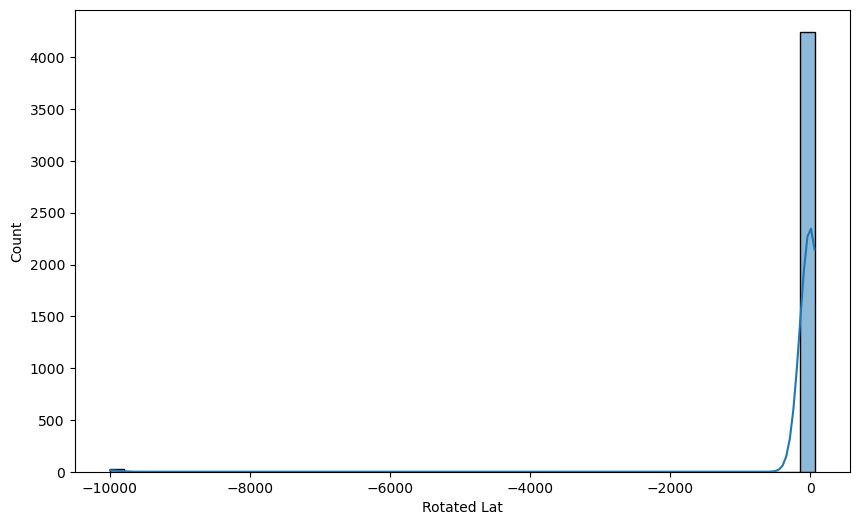

In [229]:
# That seems like a very large std relative to the mean, so let's graph the distribution of 'paleolat'
# Histogram, y axis = count, x axis = paleolat
import matplotlib.pyplot as plt
import seaborn as sns
fix, ax = plt.subplots(figsize=(10, 6))
sns.histplot(rep_bdnn['Rotated Lat'], bins=50, kde=True)
plt.show()

In [230]:
rep_bdnn['Rotated Lat'].describe()

count    4271.000000
mean      -57.827675
std       748.203679
min     -9999.000000
25%       -46.558100
50%         3.836600
75%        26.406800
max        61.323500
Name: Rotated Lat, dtype: float64

In [231]:
rep_bdnn[rep_bdnn['Rotated Lat'] < -70]

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min
155,4256,-9999.0000,-9999.0000,Neusticosaurus,marine,247.200,237.0
156,4255,-9999.0000,-9999.0000,Cymatosaurus,marine,247.200,237.0
157,4254,-9999.0000,-9999.0000,Termatosaurus,terrestrial,208.500,201.4
158,4253,-9999.0000,-9999.0000,Ichthyosaurus,marine,208.500,201.4
159,4252,-9999.0000,-9999.0000,Termatosaurus,terrestrial,208.500,201.4
160,4251,-9999.0000,-9999.0000,Ichthyosaurus,marine,208.500,201.4
1382,3029,-9999.0000,-9999.0000,Kenyasaurus,terrestrial,251.902,247.2
2169,2242,-70.3503,-22.9388,Mesosaurus,marine,290.100,283.5
2665,1746,-70.8462,123.5821,Tasmaniosaurus,terrestrial,251.902,251.2
2959,1452,-9999.0000,-9999.0000,Shastasaurus,marine,227.000,208.5


In [232]:
syn_bdnn['Rotated Lat'].describe()

count    3355.000000
mean      -40.600454
std       246.166351
min     -9999.000000
25%       -60.880700
50%       -49.477100
75%        -1.185500
max        62.825200
Name: Rotated Lat, dtype: float64

In [233]:
tem_bdnn['Rotated Lat'].describe()

count    2229.000000
mean      -18.511736
std       561.065379
min     -9999.000000
25%         1.353100
50%        14.567700
75%        39.721600
max        74.642100
Name: Rotated Lat, dtype: float64

Clearly all three datasets have "-9999" in several rows of the 'Rotated Lat' and "Rotated Lng" columns. Reached out to Alex about this, because there is data available in the 'lng' and 'lat' columns, but he says to just drop them

In [234]:
# Need to get the id's of the rows that we're dropping so I can go back and drop these same rows from DeepDive
# These are called the same thing in the DeepDive section
rep_bdnn_dropped_ids = rep_bdnn[rep_bdnn['Rotated Lat'] == -9999.0000]['id']
syn_bdnn_dropped_ids = syn_bdnn[syn_bdnn['Rotated Lat'] == -9999.0000]['id']
tem_bdnn_dropped_ids = tem_bdnn[tem_bdnn['Rotated Lat'] == -9999.0000]['id']
rep_bdnn_dropped_ids

155     4256
156     4255
157     4254
158     4253
159     4252
160     4251
1382    3029
2959    1452
2997    1414
3051    1360
3052    1359
3053    1358
3054    1357
3649     762
3650     761
3651     760
3652     759
3653     758
3654     757
3900     511
3901     510
3904     507
4030     381
4182     229
Name: id, dtype: int64

In [235]:
# I have to go back and drop these rows from the DeepDive datasets
# But since this section is after the DeepDive section, That means I'll run into an error the next time I try to run this nb in order
# , so I'll save these id's off as csv's so that I can load them in and run the DeepDive stuff first the next time I run this nb
rep_bdnn_dropped_ids.to_csv('reptilia_processed_data/reptilia_bdnn_dropped_ids.csv')
syn_bdnn_dropped_ids.to_csv('synapsida_processed_data/synapsida_bdnn_dropped_ids.csv')
tem_bdnn_dropped_ids.to_csv('temnospondyli_processed_data/temnospondyli_bdnn_dropped_ids.csv')

In [236]:
rep_bdnn_dropped = rep_bdnn[rep_bdnn['Rotated Lat'] != -9999.0000]
rep_bdnn_dropped['Rotated Lat'].describe()

count    4247.000000
mean       -1.649635
std        34.773192
min       -70.846200
25%       -46.116400
50%         3.836600
75%        26.462600
max        61.323500
Name: Rotated Lat, dtype: float64

In [237]:
rep_bdnn_dropped['Rotated Lon'].describe()

count    4247.000000
mean        1.843582
std        44.310370
min       -85.215200
25%       -36.588700
50%        -4.655400
75%        20.989100
max       152.608500
Name: Rotated Lon, dtype: float64

In [238]:
# Checking to that the correct number of rows were dropped
rep_bdnn.shape, rep_bdnn_dropped.shape, rep_bdnn[rep_bdnn['Rotated Lat'] == -9999.0000].shape

((4271, 7), (4247, 7), (24, 7))

In [239]:
syn_bdnn_dropped = syn_bdnn[syn_bdnn['Rotated Lat'] != -9999.0000]
syn_bdnn_dropped['Rotated Lat'].describe()

count    3353.000000
mean      -34.660461
std        37.792281
min       -67.429000
25%       -60.880700
50%       -49.477100
75%        -1.185500
max        62.825200
Name: Rotated Lat, dtype: float64

In [240]:
syn_bdnn_dropped['Rotated Lon'].describe()

count    3353.000000
mean       -5.783020
std        29.052976
min       -50.240600
25%       -19.334200
50%       -14.725000
75%         9.627300
max       121.703400
Name: Rotated Lon, dtype: float64

In [241]:
syn_bdnn.shape, syn_bdnn_dropped.shape, syn_bdnn[syn_bdnn['Rotated Lat'] == -9999.0000].shape

((3355, 7), (3353, 7), (2, 7))

In [242]:
tem_bdnn_dropped = tem_bdnn[tem_bdnn['Rotated Lat'] != -9999.0000]
tem_bdnn_dropped['Rotated Lat'].describe()

count    2222.000000
mean       12.929946
std        29.203648
min       -70.949200
25%         1.353100
50%        14.567700
75%        39.997375
max        74.642100
Name: Rotated Lat, dtype: float64

In [243]:
tem_bdnn.shape, tem_bdnn_dropped.shape, tem_bdnn[tem_bdnn['Rotated Lat'] == -9999.0000].shape

((2229, 7), (2222, 7), (7, 7))

#### Visualizing Lat/Lng

In [401]:
# Function for visualization of the three datasets:

def plot_feature(rep_column, syn_column, tem_column):
    # Create the figure and axes
    fig, axs = plt.subplots(3, 1, figsize=(10, 18))

    # Plot the histograms with KDE for each dataset
    sns.histplot(rep_column, bins=50, kde=True, color='blue', label='reptilia_bdnn', ax=axs[0])
    sns.histplot(syn_column, bins=50, kde=True, color='red', label='synapsida_bdnn', ax=axs[1])
    sns.histplot(tem_column, bins=50, kde=True, color='green', label='temnospondyli_bdnn', ax=axs[2])

    # Add the legends
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Return the figure object
    return fig

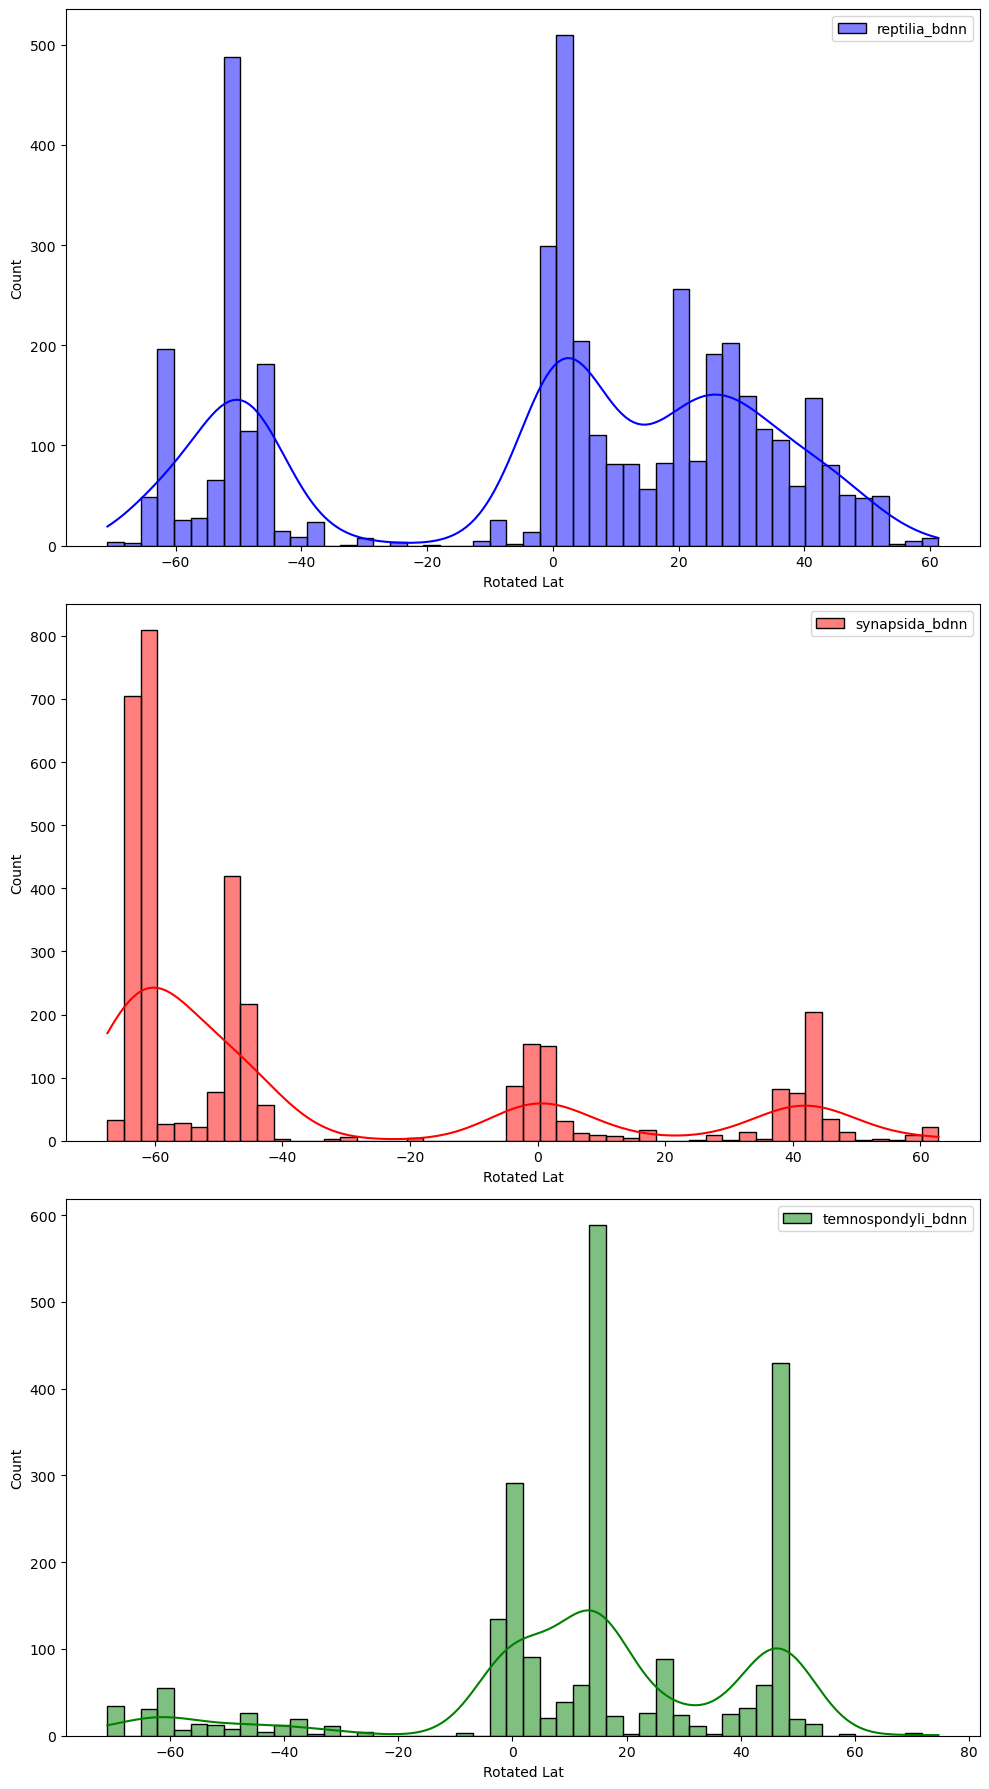

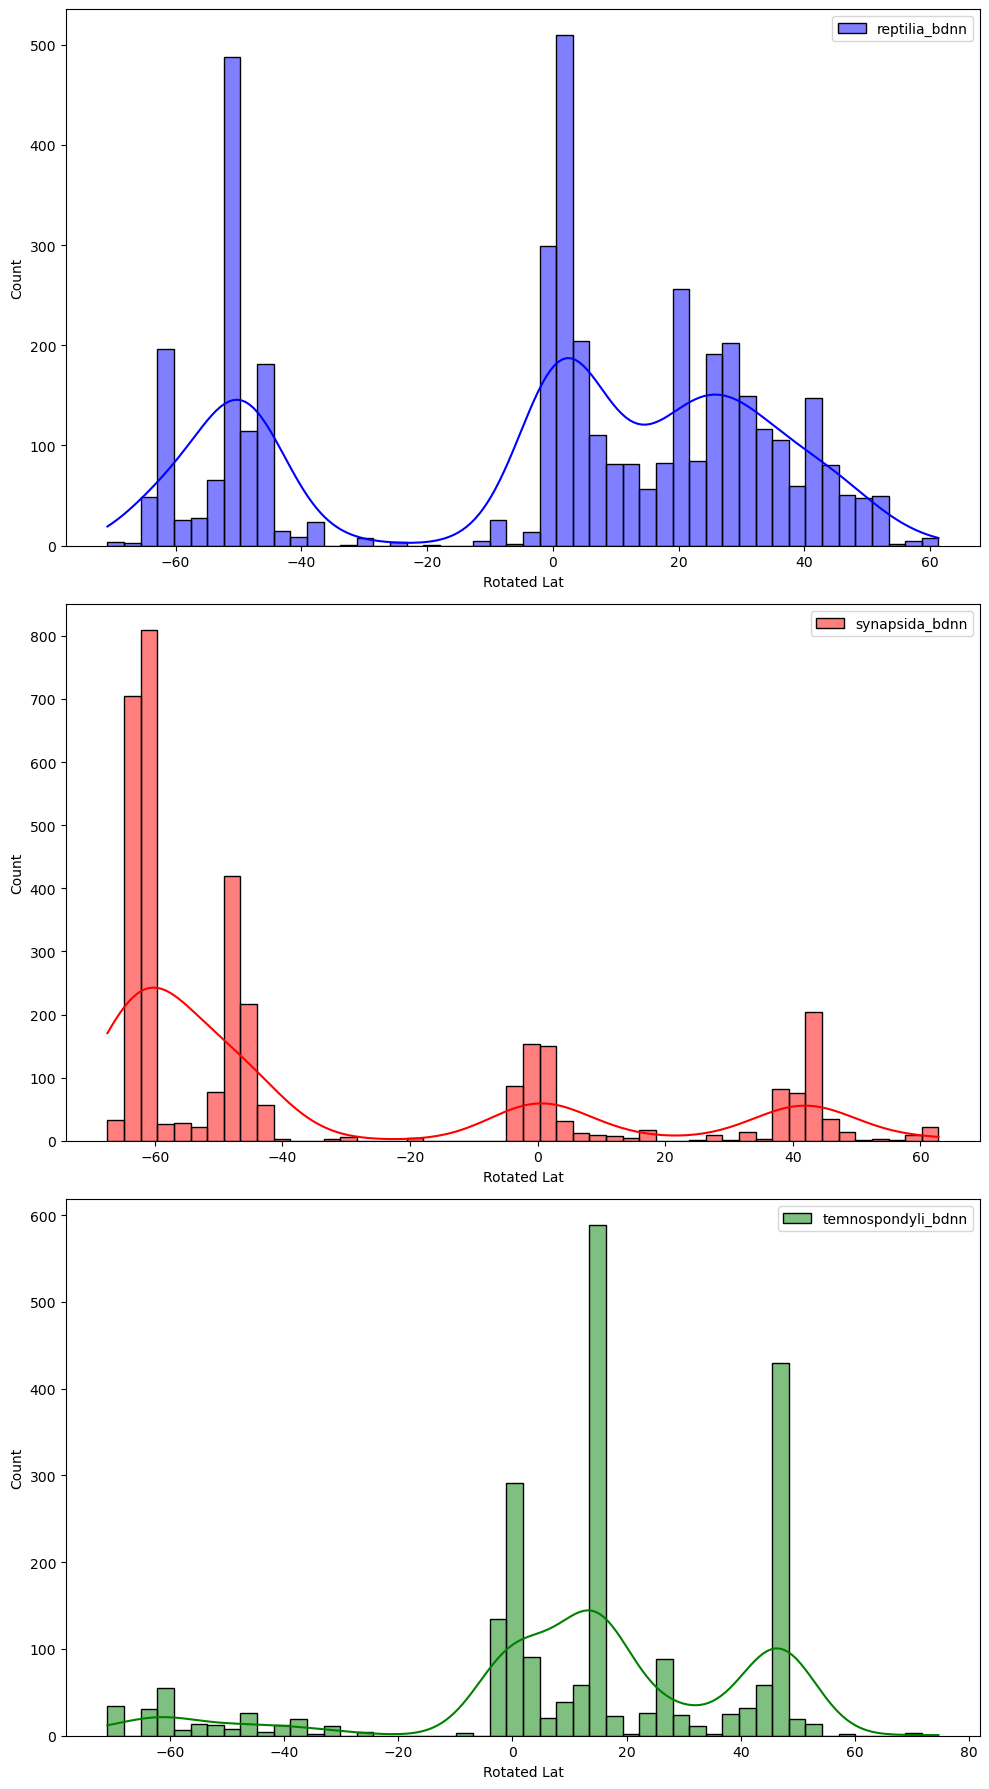

In [ ]:
rotated_lat_plots = plot_feature(rep_bdnn_dropped['Rotated Lat'], syn_bdnn_dropped['Rotated Lat'], tem_bdnn_dropped['Rotated Lat'])
# Save as a pdf
rotated_lat_plots.savefig('predictors_plots/rotated_lat_plots.pdf')
rotated_lat_plots

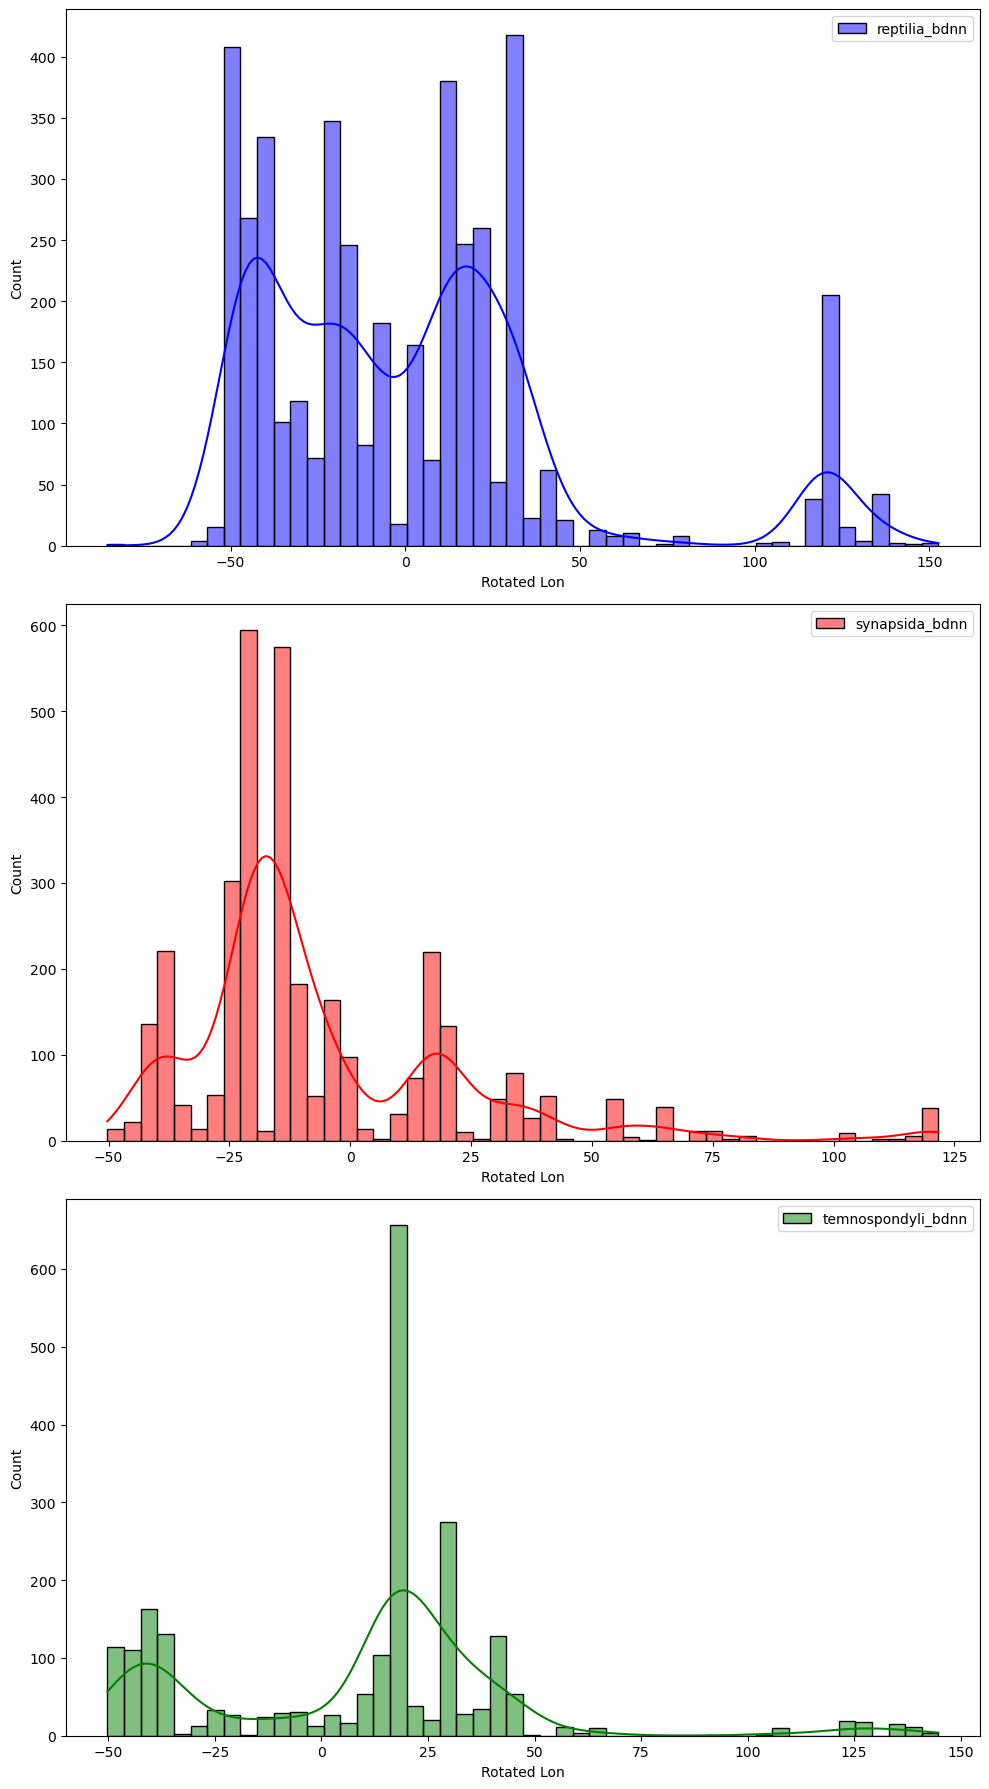

In [394]:
plot_feature(rep_bdnn_dropped['Rotated Lon'], syn_bdnn_dropped['Rotated Lon'], tem_bdnn_dropped['Rotated Lon'])

In [246]:
rep_bdnn_dropped.head()

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min
0,4411,6.7390,-20.6269,Icarosaurus,terrestrial,227.000,208.5
1,4410,6.7390,-20.6269,Rutiodon,terrestrial,227.000,208.5
2,4409,35.9688,2.1884,Kuehneosuchus,terrestrial,208.500,201.4
3,4408,35.9688,2.1884,Kuehneosaurus,terrestrial,208.500,201.4
4,4407,-62.6208,-11.8191,Procolophon,terrestrial,251.902,247.2


In [247]:
rep_final.columns

Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
       'notes', 'id', 'genus', 'age_max', 'age_min'],
      dtype='object')

In [248]:
rep_final[rep_final['genus'] == "Clevosaurs"]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min


In [249]:
tableau_rep = pd.merge(rep_bdnn_dropped[['id', 'Rotated Lat', 'Rotated Lon', 'genus']], rep_final[['id', 'locality']], on='id', how='left')
tableau_rep.shape, rep_bdnn_dropped.shape, rep_final.shape

((4247, 5), (4247, 7), (4271, 10))

In [250]:
tableau_rep.to_csv('reptilia_processed_data/reptilia_tableau.csv', index=False)

In [251]:
tableau_syn = pd.merge(syn_bdnn_dropped[['id', 'Rotated Lat', 'Rotated Lon', 'genus']], syn_final[['id', 'locality']], on='id', how='left')
tableau_syn.shape, syn_bdnn_dropped.shape, syn_final.shape

((3353, 5), (3353, 7), (3355, 10))

In [252]:
tableau_syn.to_csv('synapsida_processed_data/synapsida_tableau.csv', index=False)


In [253]:
tableau_tem = pd.merge(tem_bdnn_dropped[['id', 'Rotated Lat', 'Rotated Lon', 'genus']], tem_cleaned_filtered[['id', 'locality']], on='id', how='left')
tableau_tem.shape, tem_bdnn_dropped.shape, tem_cleaned_filtered.shape

((2222, 5), (2222, 7), (2229, 10))

In [254]:
tableau_tem.to_csv('temnospondyli_processed_data/temnospondyli_tableau.csv', index=False)

#### Starting Backscale.txt's

In [540]:
rep_backscale = pd.DataFrame({"rotated_lat_scaled": [rep_bdnn_dropped['Rotated Lat'].mean(), rep_bdnn_dropped['Rotated Lat'].std()], "rotated_lon_scaled": [rep_bdnn_dropped['Rotated Lon'].mean(), rep_bdnn_dropped['Rotated Lon'].std()]})
syn_backscale = pd.DataFrame({"rotated_lat_scaled": (syn_bdnn_dropped['Rotated Lat'].mean(), syn_bdnn_dropped['Rotated Lat'].std()), "rotated_lon_scaled": (syn_bdnn_dropped['Rotated Lon'].mean(), syn_bdnn_dropped['Rotated Lon'].std())})
tem_backscale = pd.DataFrame({"rotated_lat_scaled": (tem_bdnn_dropped['Rotated Lat'].mean(), tem_bdnn_dropped['Rotated Lat'].std()), "rotated_lon_scaled": (tem_bdnn_dropped['Rotated Lon'].mean(), tem_bdnn_dropped['Rotated Lon'].std())})
rep_backscale, syn_backscale, tem_backscale


(   rotated_lat_scaled  rotated_lon_scaled
 0           -1.649635            1.843582
 1           34.773192           44.310370,
    rotated_lat_scaled  rotated_lon_scaled
 0          -34.660461           -5.783020
 1           37.792281           29.052976,
    rotated_lat_scaled  rotated_lon_scaled
 0           12.929946            9.319296
 1           29.203648           36.968738)

In [256]:
# Checking that the mean and std values are correct in the backscale dfs above
rep_bdnn_dropped.describe()

,id,Rotated Lat,Rotated Lon,age_max,age_min
count,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000
mean,2228.908641,-1.649635,1.843582,241.247062,231.992255
std,1276.333894,34.773192,44.310370,23.353718,25.480204
min,1.000000,-70.846200,-85.215200,201.400000,199.500000
25%,1106.500000,-46.116400,-36.588700,227.000000,208.500000
50%,2263.000000,3.836600,-4.655400,239.700000,237.000000
75%,3332.500000,26.462600,20.989100,254.140000,251.902000
max,4411.000000,61.323500,152.608500,298.900000,293.520000


In [485]:
# Not saving backscale text off yet, b/c don't know final name of predictors + need to add environmental predictor
# Data in (env_vars and 1myr_temp dataframes)


# rep_backscale.to_csv('reptilia_processed_data/reptilia_backscale.txt', sep='\t', index=False)
# syn_backscale.to_csv('synapsida_processed_data/synapsida_backscale.txt', sep='\t', index=False)
# tem_backscale.to_csv('temnospondyli_processed_data/temnospondyli_backscale.txt', sep='\t', index=False)

#### StandardScaler

In [258]:
from sklearn.preprocessing import StandardScaler

scaler_rep_lat = StandardScaler()
rep_bdnn_dropped['rotated_lat_scaled'] = scaler_rep_lat.fit_transform(rep_bdnn_dropped[['Rotated Lat']]).round(2)

scaler_rep_lng = StandardScaler()
rep_bdnn_dropped['rotated_lon_scaled'] = scaler_rep_lng.fit_transform(rep_bdnn_dropped[['Rotated Lon']]).round(2)

scaler_syn_lat = StandardScaler()
syn_bdnn_dropped['rotated_lat_scaled'] = scaler_syn_lat.fit_transform(syn_bdnn_dropped[['Rotated Lat']]).round(2)

scaler_syn_lng = StandardScaler()
syn_bdnn_dropped['rotated_lon_scaled'] = scaler_syn_lng.fit_transform(syn_bdnn_dropped[['Rotated Lon']]).round(2)

scaler_tem_lat = StandardScaler()
tem_bdnn_dropped['rotated_lat_scaled'] = scaler_tem_lat.fit_transform(tem_bdnn_dropped[['Rotated Lat']]).round(2)

scaler_tem_lng = StandardScaler()
tem_bdnn_dropped['rotated_lon_scaled'] = scaler_tem_lng.fit_transform(tem_bdnn_dropped[['Rotated Lon']]).round(2)


C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_21776\3716951458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_bdnn_dropped['rotated_lat_scaled'] = scaler_rep_lat.fit_transform(rep_bdnn_dropped[['Rotated Lat']]).round(2)
C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_21776\3716951458.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_bdnn_dropped['rotated_lon_scaled'] = scaler_rep_lng.fit_transform(rep_bdnn_dropped[['Rotated Lon']]).round(2)
C:\Users\SimoesLabAdmin\AppData\Local\Te

In [259]:
rep_bdnn_dropped

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
0,4411,6.7390,-20.6269,Icarosaurus,terrestrial,227.000,208.5,0.24,-0.51
1,4410,6.7390,-20.6269,Rutiodon,terrestrial,227.000,208.5,0.24,-0.51
2,4409,35.9688,2.1884,Kuehneosuchus,terrestrial,208.500,201.4,1.08,0.01
3,4408,35.9688,2.1884,Kuehneosaurus,terrestrial,208.500,201.4,1.08,0.01
4,4407,-62.6208,-11.8191,Procolophon,terrestrial,251.902,247.2,-1.75,-0.31
...,...,...,...,...,...,...,...,...,...
4406,5,-47.4217,-18.3424,Eohyosaurus,terrestrial,247.200,242.0,-1.32,-0.46
4407,4,-47.4217,-18.3424,Mesosuchus,terrestrial,247.200,242.0,-1.32,-0.46
4408,3,-47.4217,-18.3424,Mesosuchus,terrestrial,247.200,242.0,-1.32,-0.46
4409,2,-47.4217,-18.3424,Mesosuchus,terrestrial,247.200,242.0,-1.32,-0.46


In [260]:
tem_bdnn_dropped

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
0,2247,4.6147,-41.8361,Anconastes,"brackish,freshwater,terrestrial",305.9,298.90,-0.28,-1.38
1,2246,1.0593,-36.5887,Broiliellus,"brackish,freshwater,terrestrial",283.5,273.01,-0.41,-1.24
2,2245,-0.5219,-37.7808,Broiliellus,"brackish,freshwater,terrestrial",298.9,286.10,-0.46,-1.27
3,2244,-2.9808,-38.7628,Eryops,"brackish,freshwater,terrestrial",290.1,283.50,-0.54,-1.30
4,2243,-2.9808,-38.7628,Aspidosaurus,"brackish,freshwater,terrestrial",290.1,283.50,-0.54,-1.30
...,...,...,...,...,...,...,...,...,...
2242,5,-46.3881,-25.2811,Rastosuchus,NaN,266.9,264.30,-2.03,-0.94
2243,4,-46.3881,-25.2811,Rastosuchus,NaN,266.9,264.30,-2.03,-0.94
2244,3,-46.3881,-25.2811,Rastosuchus,NaN,266.9,264.30,-2.03,-0.94
2245,2,-46.1164,-4.6554,Compsocerops,NaN,227.0,208.50,-2.02,-0.38


In [261]:
rep_bdnn_dropped.describe()

,id,Rotated Lat,Rotated Lon,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
count,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000
mean,2228.908641,-1.649635,1.843582,241.247062,231.992255,0.000716,0.000031
std,1276.333894,34.773192,44.310370,23.353718,25.480204,0.999710,1.000576
min,1.000000,-70.846200,-85.215200,201.400000,199.500000,-1.990000,-1.960000
25%,1106.500000,-46.116400,-36.588700,227.000000,208.500000,-1.280000,-0.870000
50%,2263.000000,3.836600,-4.655400,239.700000,237.000000,0.160000,-0.150000
75%,3332.500000,26.462600,20.989100,254.140000,251.902000,0.810000,0.430000
max,4411.000000,61.323500,152.608500,298.900000,293.520000,1.810000,3.400000


In [488]:
# Renaming 'Rotated Lat' to 'rotated_lat_scaled' in backscale dataframe
rep_backscale.rename(columns={'Rotated Lat': 'rotated_lat_scaled', 'Rotated Lon': 'rotated_lon_scaled'}, inplace=True)
syn_backscale.rename(columns={'Rotated Lat': 'rotated_lat_scaled', 'Rotated Lon': 'rotated_lon_scaled'}, inplace=True)
tem_backscale.rename(columns={'Rotated Lat': 'rotated_lat_scaled', 'Rotated Lon': 'rotated_lon_scaled'}, inplace=True)
rep_backscale

,rotated_lat_scaled,rotated_lon_scaled
0,-1.649635,1.843582
1,34.773192,44.310370


### Visualizing Scaled Lat/Lng

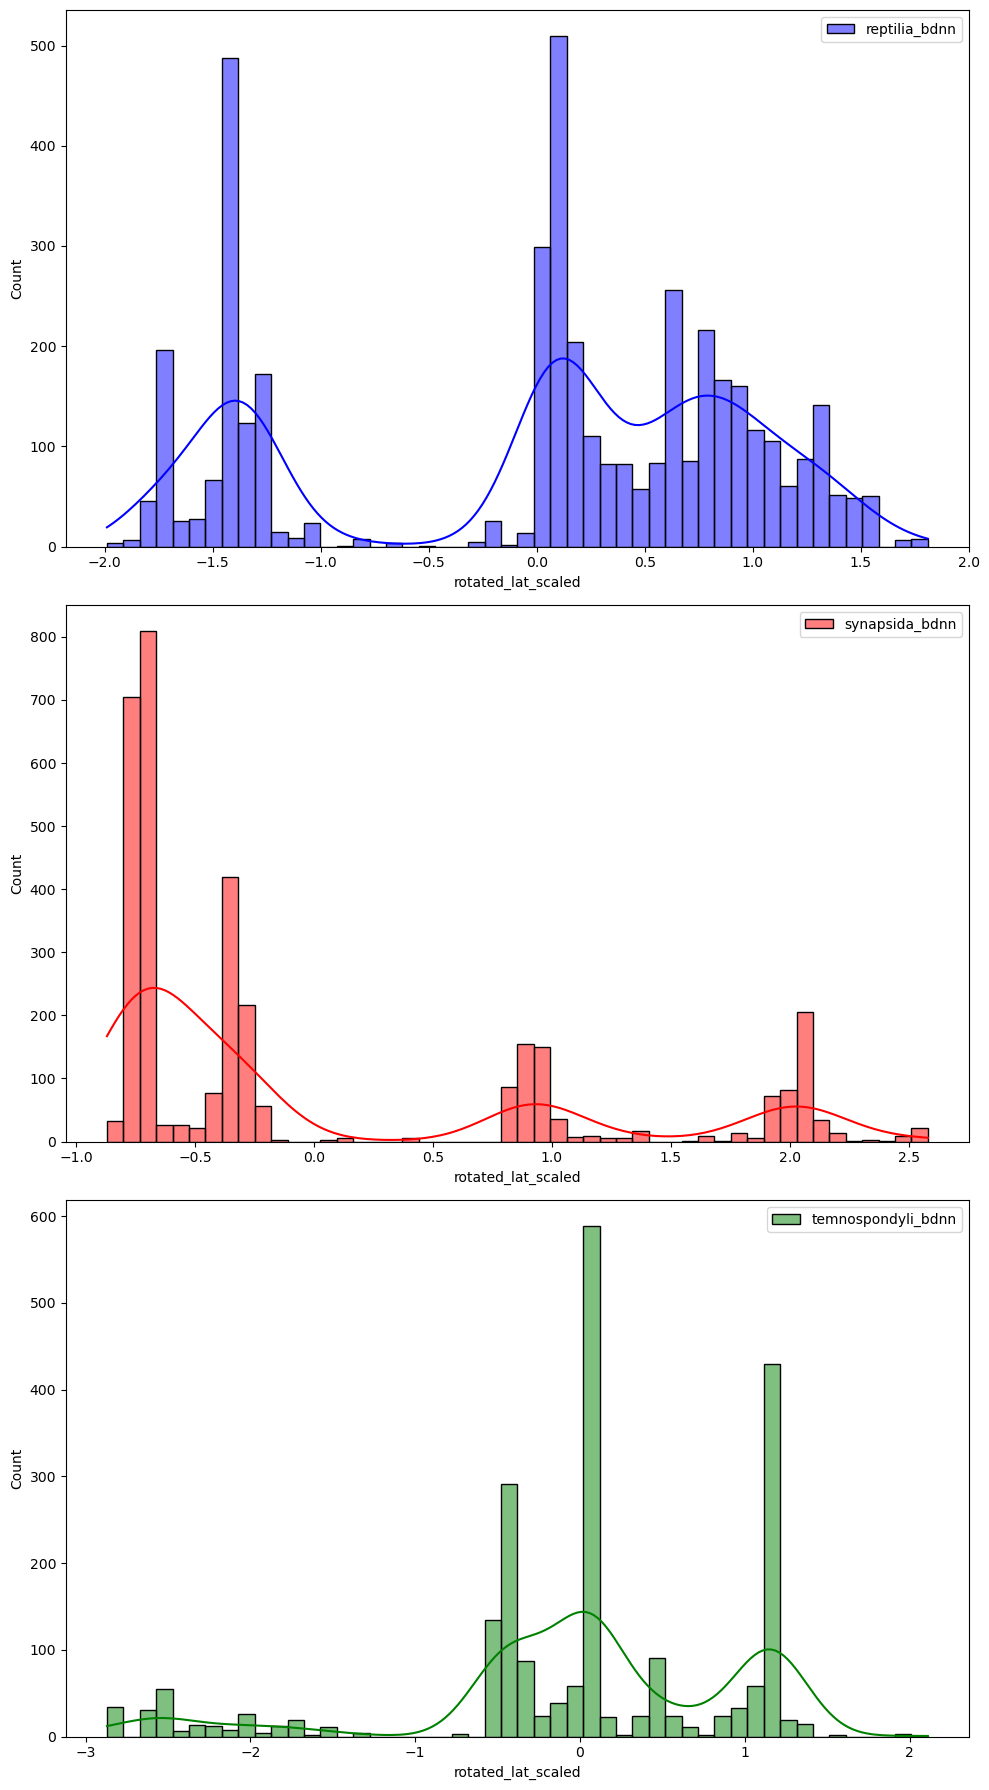

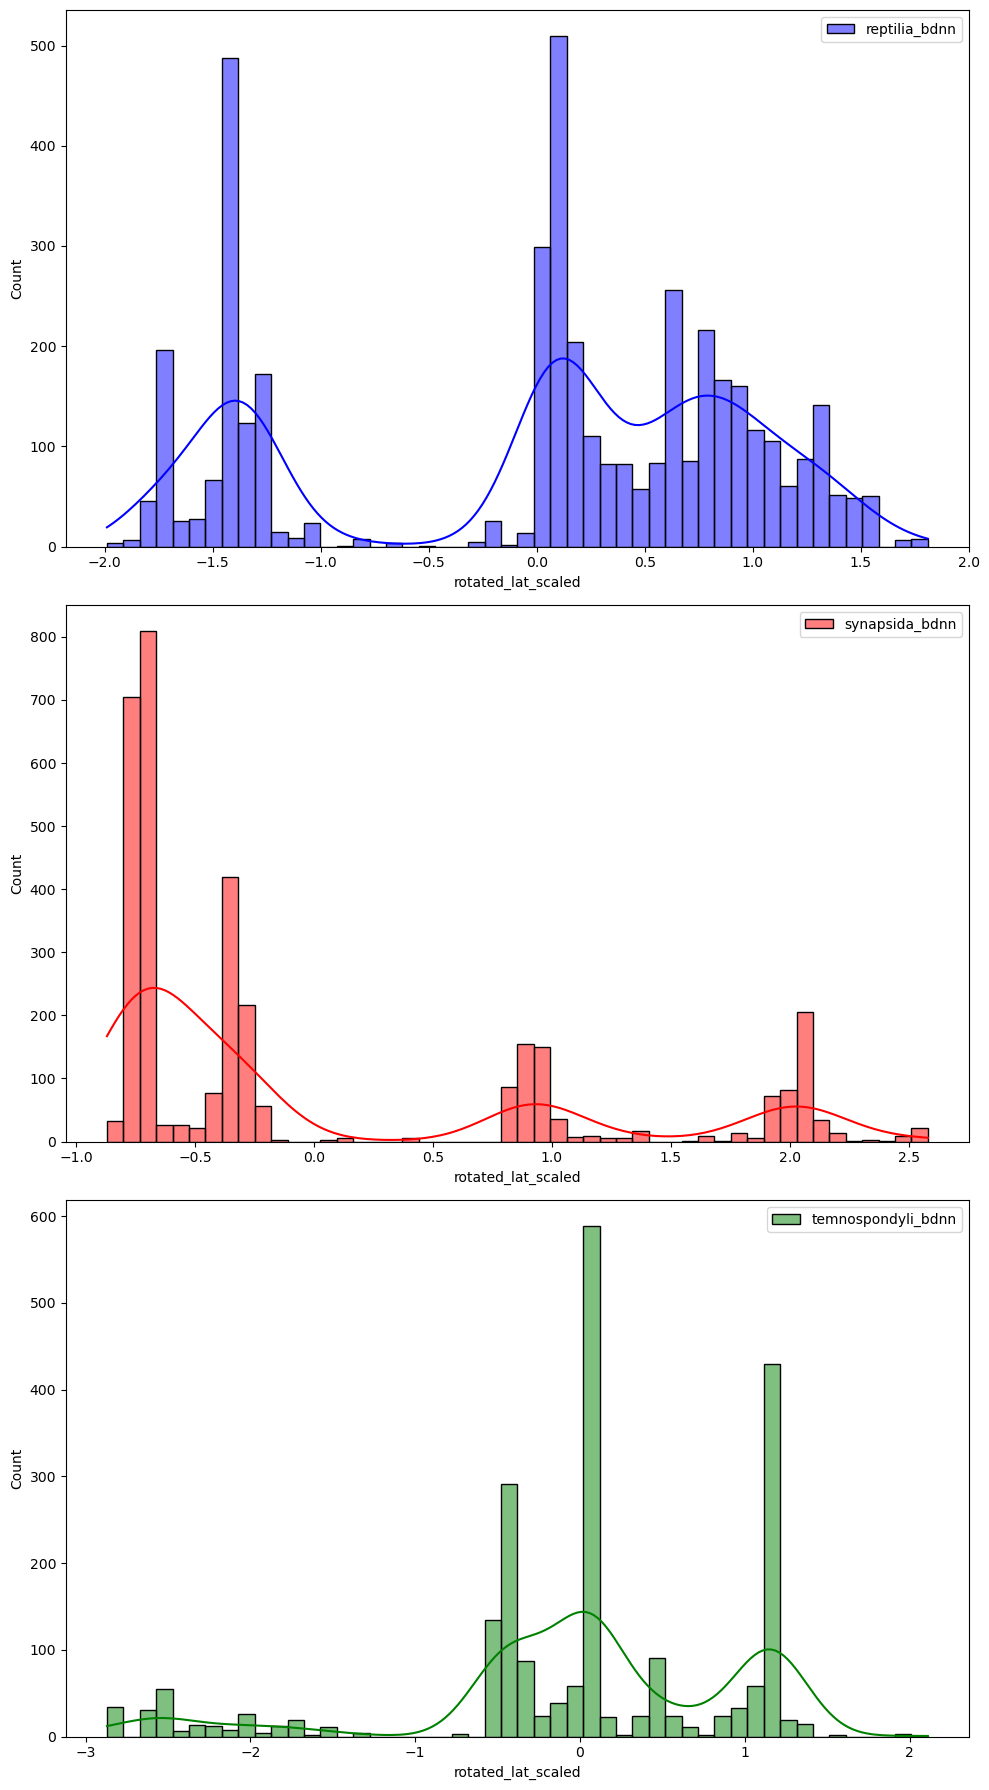

In [ ]:
rotated_lat_scaled_plots = plot_feature(rep_bdnn_dropped['rotated_lat_scaled'], syn_bdnn_dropped['rotated_lat_scaled'], tem_bdnn_dropped['rotated_lat_scaled'])
rotated_lat_scaled_plots.savefig('predictors_plots/rotated_lat_scaled_plots.pdf')
rotated_lat_scaled_plots


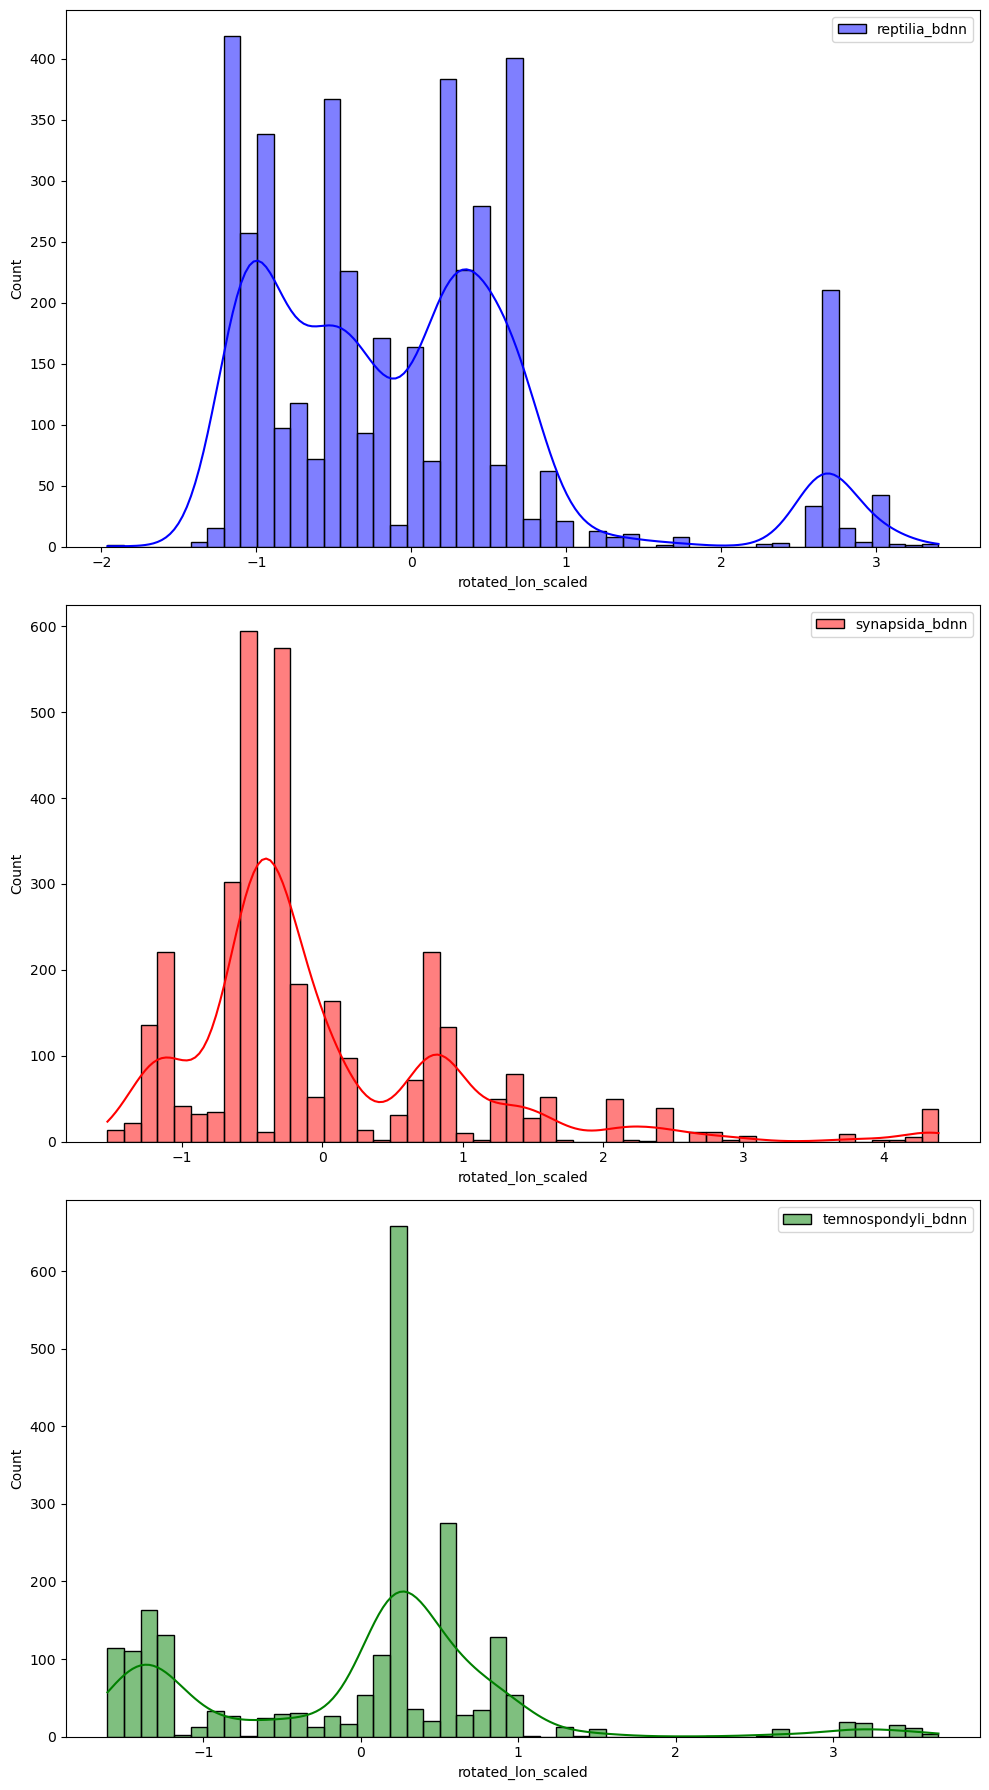

In [397]:
plot_feature(rep_bdnn_dropped['rotated_lon_scaled'], syn_bdnn_dropped['rotated_lon_scaled'], tem_bdnn_dropped['rotated_lon_scaled'])

## New Genera by Latitude

#### EDA Coords Standard Deviation

In [262]:
# PyRate only takes SPECIES specific traits, not OCCURRENCE specific traits, so lat and lng need to be averaged by "genus" column
# Grouping by genus and getting std values to see if lat and lng values for each genus have a lot of variance
# If there is a lot of variance, it might not be justifiable to average the lat and lng values
rep_bdnn_stds = rep_bdnn_dropped[['rotated_lat_scaled', 'rotated_lon_scaled', 'genus']].groupby('genus').std()
rep_bdnn_stds

,rotated_lat_scaled,rotated_lon_scaled
genus,,
Abyssomedon,NaN,NaN
Acadiella,NaN,NaN
Acaenasuchus,0.000000,0.000000
Acallosuchus,NaN,NaN
Acerosodontosaurus,NaN,NaN
...,...,...
Yunguisaurus,0.000000,0.000000
Yunnanosaurus,0.000000,0.000000
Zanclodon,0.112339,0.142829


In [263]:
# Saving off only those with std > 0
lat_stds = rep_bdnn_stds[rep_bdnn_stds['rotated_lat_scaled'] > 0]
lon_stds = rep_bdnn_stds[rep_bdnn_stds['rotated_lon_scaled'] > 0]

In [264]:
lat_stds.equals(lon_stds)

False

In [265]:
# Looking at std's that are > 0, largest to smallest
lat_stds.sort_values('rotated_lat_scaled', ascending=False)


,rotated_lat_scaled,rotated_lon_scaled
genus,,
Garjainia,1.576710,0.564351
Procolophonichnium,1.420282,0.496521
Tetrasauropus,1.368320,0.658179
Teratosaurus,1.235570,0.653911
Proterosuchus,1.108144,0.705648
...,...,...
Uatchitodon,0.005774,0.320468
Krzyzanowskisaurus,0.005774,0.046188
Hemilopas,0.005774,0.011547


In [266]:
lat_stds[lat_stds.index == 'Clevosaurus']

,rotated_lat_scaled,rotated_lon_scaled
genus,,
Clevosaurus,1.079502,0.462314


These are all fairly large std's. I need one coord value per species, so I'll have to average out the lat and lon values across all occurrences of the same species. However, if one species has a wide range of lat and lon values (as indicated by high std), that might not be justifiable. Need to do some EDA below

In [267]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Garjainia']

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
1968,2443,46.9132,47.1091,Garjainia,terrestrial,251.2,247.2,1.40,1.02
2313,2098,48.3133,44.0363,Garjainia,terrestrial,251.2,247.2,1.44,0.95
2742,1669,-58.7619,-5.3084,Garjainia,terrestrial,248.9,247.2,-1.64,-0.16
3588,823,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3589,822,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3590,821,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3591,820,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3592,819,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3593,818,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3594,817,-60.6853,0.0780,Garjainia,terrestrial,251.2,247.2,-1.70,-0.04


In [268]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Clevosaurus'].sort_values('Rotated Lat')

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
3995,416,-49.4771,-10.0175,Clevosaurus,terrestrial,237.0,227.0,-1.38,-0.27
4344,67,-47.3188,-9.0563,Clevosaurus,terrestrial,227.0,208.5,-1.31,-0.25
1464,2948,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1461,2945,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1460,2944,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1459,2943,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1458,2942,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1457,2941,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1456,2940,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
4351,60,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15


In [269]:
lon_stds.sort_values('rotated_lon_scaled', ascending=False)

,rotated_lat_scaled,rotated_lon_scaled
genus,,
Utatsusaurus,0.186145,2.484566
Mixosaurus,0.106515,1.473495
Tholodus,0.341211,1.395167
Phalarodon,0.272832,1.309891
Askeptosaurus,0.050332,1.290852
...,...,...
Eucoelophysis,0.098995,0.007071
Paralonectes,0.023094,0.005774
Barracudasaurus,0.040415,0.005774


In [270]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Utatsusaurus']

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
1381,3030,32.0407,152.6085,Utatsusaurus,marine,251.200,247.2,0.97,3.40
1590,2821,32.0407,152.6085,Utatsusaurus,marine,248.900,247.2,0.97,3.40
3736,675,17.2920,-46.5877,Utatsusaurus,marine,248.900,247.2,0.54,-1.09
3921,490,31.6180,-40.9603,Utatsusaurus,marine,251.902,248.9,0.96,-0.97
3922,489,30.0552,-57.1861,Utatsusaurus,marine,251.200,248.9,0.91,-1.33


Lat and lon values for ~235 species (in reptilia) have standard deviations > 0. To handle this, we're going to 
1. ID any species that have lat and lon values that span > 20 degrees (range > 20)
2. Split those species into several categories

#### EDA Coords By Range

In [271]:
rep_bdnn_range = rep_bdnn_dropped[['Rotated Lat', 'Rotated Lon', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()), 
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                                lon_range=('Rotated Lon', lambda x: x.max() - x.min()),
                                                                                                lon_min = ('Rotated Lon', lambda x: x.min()),
                                                                                                lon_max = ('Rotated Lon', lambda x: x.max()))
rep_bdnn_range

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Abyssomedon,0.0000,-0.7300,-0.7300,0.0000,-37.6741,-37.6741
Acadiella,0.0000,10.5874,10.5874,0.0000,-11.8909,-11.8909
Acaenasuchus,0.0000,1.3531,1.3531,0.0000,-47.1801,-47.1801
Acallosuchus,0.0000,1.3531,1.3531,0.0000,-47.1801,-47.1801
Acerosodontosaurus,0.0000,-50.0920,-50.0920,0.0000,31.3299,31.3299
...,...,...,...,...,...,...
Yunguisaurus,0.0000,18.7825,18.7825,0.0000,119.7653,119.7653
Yunnanosaurus,0.0000,52.1412,52.1412,0.0000,136.1873,136.1873
Zanclodon,9.8519,26.1169,35.9688,15.2919,2.1884,17.4803


In [272]:
rep_bdnn_range[(rep_bdnn_range['lat_range'] > 0) | (rep_bdnn_range['lon_range'] > 0)]

# 235 genera have a range in lat or lon, (which means they have multiple occurrences that have diff coords) so I'll have to average the lat and lon values for these genera
# Explore them first to see if the ranges are too large to justify averaging

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Aetosauroides,19.2086,-56.0316,-36.8230,57.2441,-29.5316,27.7125
Aetosaurus,12.2457,20.3475,32.5932,2.3135,9.3339,11.6474
Amanasaurus,9.9152,-56.0316,-46.1164,24.4663,-10.0175,14.4488
Ammorhynchus,0.9441,8.5619,9.5060,2.9597,-46.6177,-43.6580
Amotosaurus,4.0874,22.9805,27.0679,3.2667,17.1911,20.4578
...,...,...,...,...,...,...
Vjushkovisaurus,1.9393,46.8850,48.8243,1.7945,40.4161,42.2106
Weigeltisaurus,2.0215,25.6133,27.6348,9.4133,12.9250,22.3383
Xinpusaurus,8.2288,18.7825,27.0113,1.2195,118.5458,119.7653


In [273]:
# Decided w/ Tiago to focus on genera w/ lat and lon ranges > 20 deg
rep_bdnn_range[(rep_bdnn_range['lat_range'] > 20) | (rep_bdnn_range['lon_range'] > 20)]

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Aetosauroides,19.2086,-56.0316,-36.8230,57.2441,-29.5316,27.7125
Amanasaurus,9.9152,-56.0316,-46.1164,24.4663,-10.0175,14.4488
Anchisauripus,44.3906,3.8468,48.2374,73.4754,-47.0031,26.4723
Angistorhinus,8.3572,1.3572,9.7144,45.3523,-50.2406,-4.8883
Anomoepus,48.3036,3.8376,52.1412,159.6741,-23.4868,136.1873
Anomoiodon,14.5387,11.9239,26.4626,28.7886,-7.7995,20.9891
Anthodon,15.3754,-63.1595,-47.7841,37.0824,-19.3342,17.7482
Apatopus,33.8313,-0.5164,33.3149,67.7947,-50.1976,17.5971
Askeptosaurus,3.5179,18.7825,22.3004,100.7310,19.0343,119.7653


In [274]:
# Looking at a genus with a high range
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Anomoepus'].sort_values('Rotated Lat')

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
4090,321,3.8376,-23.1639,Anomoepus,terrestrial,227.0,213.2,0.16,-0.56
3640,771,6.3169,-23.4868,Anomoepus,terrestrial,227.0,208.5,0.23,-0.57
4112,299,16.9917,-16.5851,Anomoepus,terrestrial,201.4,199.5,0.54,-0.42
522,3889,16.9917,-16.5851,Anomoepus,terrestrial,201.4,199.5,0.54,-0.42
1729,2682,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1728,2683,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1722,2689,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1720,2691,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1715,2696,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1704,2707,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36


In [275]:
rep_lat_range_20 = rep_bdnn_range[rep_bdnn_range['lat_range'] > 20]
rep_lat_range_20

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Anchisauripus,44.3906,3.8468,48.2374,73.4754,-47.0031,26.4723
Anomoepus,48.3036,3.8376,52.1412,159.6741,-23.4868,136.1873
Apatopus,33.8313,-0.5164,33.3149,67.7947,-50.1976,17.5971
Atreipus,26.5759,6.7390,33.3149,38.2240,-20.6269,17.5971
Batrachopus,27.8992,6.0887,33.9879,67.4301,-50.2390,17.1911
Brachychirotherium,33.8313,-0.5164,33.3149,64.6002,-47.0031,17.5971
Captorhinus,49.3052,-47.7841,1.5211,58.2518,-40.5036,17.7482
Chirotherium,83.9687,-49.9808,33.9879,167.8088,-43.9682,123.8406
Clevosaurus,101.6183,-49.4771,52.1412,146.2048,-10.0175,136.1873


In [276]:
# Verigying that the groupby 'lat_range' column happened correctly by calculating the range for 'Anomoepus' manually
(rep_lat_range_20[rep_lat_range_20.index == 'Anomoepus']['lat_min'] + rep_lat_range_20[rep_lat_range_20.index == 'Anomoepus']['lat_max']) / 2

genus
Anomoepus    27.9894
dtype: float64

In [277]:
# Now checking for lon range > 20
rep_lon_range_20 = rep_bdnn_range[rep_bdnn_range['lon_range'] > 20]
rep_lon_range_20

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Aetosauroides,19.2086,-56.0316,-36.8230,57.2441,-29.5316,27.7125
Amanasaurus,9.9152,-56.0316,-46.1164,24.4663,-10.0175,14.4488
Anchisauripus,44.3906,3.8468,48.2374,73.4754,-47.0031,26.4723
Angistorhinus,8.3572,1.3572,9.7144,45.3523,-50.2406,-4.8883
Anomoepus,48.3036,3.8376,52.1412,159.6741,-23.4868,136.1873
Anomoiodon,14.5387,11.9239,26.4626,28.7886,-7.7995,20.9891
Anthodon,15.3754,-63.1595,-47.7841,37.0824,-19.3342,17.7482
Apatopus,33.8313,-0.5164,33.3149,67.7947,-50.1976,17.5971
Askeptosaurus,3.5179,18.7825,22.3004,100.7310,19.0343,119.7653


In [278]:
# Looking at a very common genus
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Clevosaurus'].sort_values('Rotated Lat')

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
3995,416,-49.4771,-10.0175,Clevosaurus,terrestrial,237.0,227.0,-1.38,-0.27
4344,67,-47.3188,-9.0563,Clevosaurus,terrestrial,227.0,208.5,-1.31,-0.25
1464,2948,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1461,2945,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1460,2944,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1459,2943,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1458,2942,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1457,2941,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1456,2940,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
4351,60,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15


### Dropping Lon, Binning Lat

Decided to drop longitude as a predictor entirely, because of an issue illustrated in the above:
- Clevosaurus latitudes -30 and below have longitudes that range from (27 to -4). That means even if we split Clevosaurus by ranges of latitude, the (-30 to -50) range of Clevosaurus (let's call that "Clevosaurus_South", essentially a new genus) would still have a wide range of longitudes. 
- We still need per-genus trait data for BDNN, so we'd have to average out that wide range of longitudinal values (27 to -4), which misrepresents the actual distribution -- that was our original issue with Clevosaurus as a whole, the reason that we decided to bucket together occurrences in the latitude range of -30 to -50
- In order to avoid that, we'd have to do another further split of the Clevosaurus_South genus, into Clevosaurus_South_East (latitude -30 to -50 and longitude 20+), and Clevosaurus_South_West (latitude -30 to -50 and longitude -4 on). 
- Leads to too many categories

Solution: 
1. Drop longitude as a predictor
2. Groupby genera and get lat ranges
3. Save off all genera with latitude ranges > 20 degrees
4. Define new latitudinal categories based on Earth's environment
5. For those genera in step 3, create new artificial genera categorized by those latitudinal categories


Latitudinal Gradient Categories:
    - Arctic
- Arctic Circle: 66 deg 33 mins
    - Temperate_N
- Tropic of Cancer: 23 deg 26 mins
    - Tropical_N
- equator: 0
    - Tropical_S
- Tropic of Capricorn: -23 deg 36 min
    - Temperate_S
- Antarctic Circle: -66 deg 33 min
    - Antarctic


#### Rep

In [279]:
rep_bdnn_dropped.columns

Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
       'age_max', 'age_min', 'rotated_lat_scaled', 'rotated_lon_scaled'],
      dtype='object')

In [280]:
# Groupby genus and getting lat range, min, and max
rep_bdnn_lat_range = rep_bdnn_dropped[['Rotated Lat', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()), 
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                )
rep_bdnn_lat_range

,lat_range,lat_min,lat_max
genus,,,
Abyssomedon,0.0000,-0.7300,-0.7300
Acadiella,0.0000,10.5874,10.5874
Acaenasuchus,0.0000,1.3531,1.3531
Acallosuchus,0.0000,1.3531,1.3531
Acerosodontosaurus,0.0000,-50.0920,-50.0920
...,...,...,...
Yunguisaurus,0.0000,18.7825,18.7825
Yunnanosaurus,0.0000,52.1412,52.1412
Zanclodon,9.8519,26.1169,35.9688


In [281]:
# Cutting down groupby to just those with lat range >20
rep_lat_range_20 = rep_bdnn_lat_range[rep_bdnn_lat_range['lat_range'] > 20]
rep_lat_range_20

,lat_range,lat_min,lat_max
genus,,,
Anchisauripus,44.3906,3.8468,48.2374
Anomoepus,48.3036,3.8376,52.1412
Apatopus,33.8313,-0.5164,33.3149
Atreipus,26.5759,6.7390,33.3149
Batrachopus,27.8992,6.0887,33.9879
Brachychirotherium,33.8313,-0.5164,33.3149
Captorhinus,49.3052,-47.7841,1.5211
Chirotherium,83.9687,-49.9808,33.9879
Clevosaurus,101.6183,-49.4771,52.1412


In [282]:
# This is the final list of genera that need to be re-binned into latitudinal bins
rep_lat_range_20.index

Index(['Anchisauripus', 'Anomoepus', 'Apatopus', 'Atreipus', 'Batrachopus',
       'Brachychirotherium', 'Captorhinus', 'Chirotherium', 'Clevosaurus',
       'Coelophysis', 'Coelurosauravus', 'Coelurosaurichnus', 'Cymbospondylus',
       'Diphydontosaurus', 'Drepanosaurus', 'Dromomeron', 'Eosauropus',
       'Eubrontes', 'Fraserosphenodon', 'Garjainia', 'Grallator', 'Haligonia',
       'Hyperodapedon', 'Hypsognathus', 'Ichthyosaurus', 'Kapes', 'Kayentapus',
       'Lessemsaurus', 'Macroleter', 'Mesosaurus', 'Microcnemus',
       'Mikadocephalus', 'Mystriosuchus', 'Nicrosaurus', 'Nothosaurus',
       'Omphalosaurus', 'Palacrodon', 'Paleollanosaurus', 'Parabrontopodus',
       'Parasuchus', 'Paratypothorax', 'Phalarodon', 'Placodus',
       'Planocephalosaurus', 'Plateosaurus', 'Procolophonichnium',
       'Proganochelys', 'Proterosuchus', 'Psephoderma', 'Psephosaurus',
       'Pseudotetrasauropus', 'Scoloparia', 'Shastasaurus', 'Shonisaurus',
       'Simosaurus', 'Stagonolepis', 'Stereo

Latitudinal Bins:
- Arctic Circle: 66 deg 33 mins
- Tropic of Cancer: 23 deg 26 mins
- equator: 0
- Tropic of Capricorn: -23 deg 36 min
- Antarctic Circle: -66 deg 33 min


If 'Rotated Lat' 
- is >66 = Arctic 
- <= 66 & > 23 = Temperate_N
- <= 23 & >= -23 = Tropics
- < -23 & <= -66 = Temperate_S
- < -66 = Antarctic

In [283]:
rep_bdnn_dropped.dtypes

id                      int64
Rotated Lat           float64
Rotated Lon           float64
genus                  object
taxon_environment      object
age_max               float64
age_min               float64
rotated_lat_scaled    float64
rotated_lon_scaled    float64
dtype: object

In [284]:
# Loop through rep_bdnn_dropped and re-name the genuses in the rep_lat_range_20 according to their value in the 'Rotated Lat' column
# which determines which bin they should be in

def lat_binning(df, lat_range_20_list_genus_list):
    df_binned = df.copy()
    for genus in lat_range_20_list_genus_list:
        if genus in df_binned['genus'].values:
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= 66.5), 'genus'] = genus + '_Arctic'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= 23.5) & (df_binned['Rotated Lat'] < 66.5), 'genus'] = genus + '_Temperate_N'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= 0) & (df_binned['Rotated Lat'] < 23.5), 'genus'] = genus + '_Tropical_N'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= -23.5) & (df_binned['Rotated Lat'] < 0), 'genus'] = genus + '_Tropical_S'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] >= -66.5) & (df_binned['Rotated Lat'] < -23.5), 'genus'] = genus + '_Temperate_S'
            df_binned.loc[(df_binned['genus'] == genus) & (df_binned['Rotated Lat'] < -66.5), 'genus'] = genus + '_Antarctic'        
    return df_binned

In [285]:
rep_bdnn_binned = lat_binning(rep_bdnn_dropped, rep_lat_range_20.index)
rep_bdnn_binned

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
0,4411,6.7390,-20.6269,Icarosaurus,terrestrial,227.000,208.5,0.24,-0.51
1,4410,6.7390,-20.6269,Rutiodon,terrestrial,227.000,208.5,0.24,-0.51
2,4409,35.9688,2.1884,Kuehneosuchus,terrestrial,208.500,201.4,1.08,0.01
3,4408,35.9688,2.1884,Kuehneosaurus,terrestrial,208.500,201.4,1.08,0.01
4,4407,-62.6208,-11.8191,Procolophon,terrestrial,251.902,247.2,-1.75,-0.31
...,...,...,...,...,...,...,...,...,...
4406,5,-47.4217,-18.3424,Eohyosaurus,terrestrial,247.200,242.0,-1.32,-0.46
4407,4,-47.4217,-18.3424,Mesosuchus,terrestrial,247.200,242.0,-1.32,-0.46
4408,3,-47.4217,-18.3424,Mesosuchus,terrestrial,247.200,242.0,-1.32,-0.46
4409,2,-47.4217,-18.3424,Mesosuchus,terrestrial,247.200,242.0,-1.32,-0.46


In [286]:
# Shape should not have changed since we're just renaming genera
rep_bdnn_binned.shape, rep_bdnn_dropped.shape

((4247, 9), (4247, 9))

In [287]:
rep_bdnn_dropped['genus'].value_counts()

genus
Hovasaurus       301
Captorhinus      127
Grallator        106
Plateosaurus      97
Typothorax        91
                ... 
Sanjuansaurus      1
Xilousuchus        1
Otozoum            1
Augustasaurus      1
Kuruxuchampsa      1
Name: count, Length: 686, dtype: int64

In [288]:
# the number of unique genera should have increased since we've added the latitudinal bins
rep_bdnn_binned['genus'].value_counts()

genus
Hovasaurus                  301
Captorhinus_Tropical_S      105
Grallator_Tropical_N         96
Plateosaurus_Temperate_N     93
Typothorax                   91
                           ... 
Hanosaurus                    1
Chinchenia                    1
Sanchiaosaurus                1
Shastasaurus_Temperate_N      1
Kuruxuchampsa                 1
Name: count, Length: 760, dtype: int64

In [289]:
rep_bdnn_binned[rep_bdnn_binned['genus'].str.contains('_')]

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
7,4404,24.9561,4.3648,Clevosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
8,4403,24.9561,4.3648,Diphydontosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
9,4402,24.9561,4.3648,Diphydontosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
11,4400,24.9561,4.3648,Planocephalosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
14,4397,24.9561,4.3648,Clevosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
...,...,...,...,...,...,...,...,...,...
4399,12,-36.8230,27.7125,Hyperodapedon_Temperate_S,terrestrial,227.0,208.5,-1.01,0.58
4401,10,-57.8419,7.7727,Hyperodapedon_Temperate_S,terrestrial,227.0,208.5,-1.62,0.13
4402,9,-56.0316,14.4488,Hyperodapedon_Temperate_S,terrestrial,227.0,208.5,-1.56,0.28
4403,8,-58.4933,13.6424,Hyperodapedon_Temperate_S,terrestrial,227.0,208.5,-1.63,0.27


In [290]:
rep_bdnn_binned[rep_bdnn_binned['genus'].str.contains('Clevosaurus')].sort_values('Rotated Lat')

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
3995,416,-49.4771,-10.0175,Clevosaurus_Temperate_S,terrestrial,237.0,227.0,-1.38,-0.27
4344,67,-47.3188,-9.0563,Clevosaurus_Temperate_S,terrestrial,227.0,208.5,-1.31,-0.25
1464,2948,-46.1164,-4.6554,Clevosaurus_Temperate_S,terrestrial,227.0,208.5,-1.28,-0.15
1461,2945,-46.1164,-4.6554,Clevosaurus_Temperate_S,terrestrial,227.0,208.5,-1.28,-0.15
1460,2944,-46.1164,-4.6554,Clevosaurus_Temperate_S,terrestrial,227.0,208.5,-1.28,-0.15
1459,2943,-46.1164,-4.6554,Clevosaurus_Temperate_S,terrestrial,227.0,208.5,-1.28,-0.15
1458,2942,-46.1164,-4.6554,Clevosaurus_Temperate_S,terrestrial,227.0,208.5,-1.28,-0.15
1457,2941,-46.1164,-4.6554,Clevosaurus_Temperate_S,terrestrial,227.0,208.5,-1.28,-0.15
1456,2940,-46.1164,-4.6554,Clevosaurus_Temperate_S,terrestrial,227.0,208.5,-1.28,-0.15
4351,60,-46.1164,-4.6554,Clevosaurus_Temperate_S,terrestrial,227.0,208.5,-1.28,-0.15


In [291]:
# Finding newly named genera

rep_binned_rows = rep_bdnn_binned[rep_bdnn_binned['genus'].str.contains('_')]
rep_binned_rows

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
7,4404,24.9561,4.3648,Clevosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
8,4403,24.9561,4.3648,Diphydontosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
9,4402,24.9561,4.3648,Diphydontosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
11,4400,24.9561,4.3648,Planocephalosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
14,4397,24.9561,4.3648,Clevosaurus_Temperate_N,terrestrial,237.0,227.0,0.77,0.06
...,...,...,...,...,...,...,...,...,...
4399,12,-36.8230,27.7125,Hyperodapedon_Temperate_S,terrestrial,227.0,208.5,-1.01,0.58
4401,10,-57.8419,7.7727,Hyperodapedon_Temperate_S,terrestrial,227.0,208.5,-1.62,0.13
4402,9,-56.0316,14.4488,Hyperodapedon_Temperate_S,terrestrial,227.0,208.5,-1.56,0.28
4403,8,-58.4933,13.6424,Hyperodapedon_Temperate_S,terrestrial,227.0,208.5,-1.63,0.27


#### Syn

In [292]:
syn_bdnn_lat_range = syn_bdnn_dropped[['Rotated Lat', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()), 
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                )
syn_bdnn_lat_range

,lat_range,lat_min,lat_max
genus,,,
Abajudon,1.6234,-58.5772,-56.9538
Abdalodon,0.0000,-60.8508,-60.8508
Acratophorus,1.9512,-56.9276,-54.9764
Adelobasileus,0.0000,-1.4701,-1.4701
Aelurognathus,34.0246,-63.1595,-29.1349
...,...,...,...
Woznikella,3.7001,29.6148,33.3149
Xiyukannemeyeria,0.6731,60.6504,61.3235
Xyrospondylus,0.0000,0.3973,0.3973


In [293]:
syn_lat_range_20 = syn_bdnn_lat_range[syn_bdnn_lat_range['lat_range'] > 20]
syn_lat_range_20

,lat_range,lat_min,lat_max
genus,,,
Aelurognathus,34.0246,-63.1595,-29.1349
Anteosaurus,102.8787,-62.7516,40.1271
Dicynodon,108.5974,-63.1595,45.4379
Dicynodontipus,87.2577,-60.8084,26.4493
Dicynodontoides,20.9223,-63.1595,-42.2372
Diictodon,125.2806,-66.2903,58.9903
Endothiodon,43.4980,-63.1595,-19.6615
Ennatosaurus,36.7054,5.9822,42.6876
Exaeretodon,69.7658,-57.8419,11.9239


In [294]:
syn_bdnn_binned = lat_binning(syn_bdnn_dropped, syn_lat_range_20.index)
syn_bdnn_binned.shape, syn_bdnn_dropped.shape, syn_lat_range_20.index.shape

((3353, 9), (3353, 9), (24,))

In [295]:
syn_bdnn_binned['genus'].nunique(), syn_bdnn_dropped['genus'].nunique()

(525, 508)

In [296]:
syn_binned_rows = syn_bdnn_binned[syn_bdnn_binned['genus'].str.contains('_')]
syn_binned_rows

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
10,3401,-60.8508,-19.3342,Diictodon_Temperate_S,terrestrial,259.51,254.14,-0.69,-0.47
11,3402,-60.8508,-19.3342,Diictodon_Temperate_S,terrestrial,259.51,254.14,-0.69,-0.47
12,3403,-60.8508,-19.3342,Diictodon_Temperate_S,terrestrial,259.51,254.14,-0.69,-0.47
13,3404,-60.8508,-19.3342,Diictodon_Temperate_S,terrestrial,259.51,254.14,-0.69,-0.47
14,3405,-60.8508,-19.3342,Diictodon_Temperate_S,terrestrial,259.51,254.14,-0.69,-0.47
...,...,...,...,...,...,...,...,...,...
3295,127,-46.4894,-19.7677,Lystrosaurus_Temperate_S,NaN,251.90,251.20,-0.31,-0.48
3297,125,-46.9166,-20.6415,Dicynodon_Temperate_S,NaN,259.50,254.10,-0.32,-0.51
3299,123,-46.9166,-20.6415,Endothiodon_Temperate_S,NaN,259.50,254.10,-0.32,-0.51
3300,122,-46.4894,-19.7677,Lystrosaurus_Temperate_S,NaN,251.90,251.20,-0.31,-0.48


#### Tem

In [297]:
tem_bdnn_lat_range = tem_bdnn_dropped[['Rotated Lat', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()),
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                )
tem_bdnn_lat_range

,lat_range,lat_min,lat_max
genus,,,
Acanthostomatops,0.0000,16.6404,16.6404
Acerastea,0.0000,-54.0160,-54.0160
Acheloma,4.0401,-2.9808,1.0593
Acroplous,0.1746,3.7525,3.9271
Actinodon,0.5002,9.6624,10.1626
...,...,...,...
Xenotosuchus,1.9596,-63.3350,-61.3754
Yarengia,0.0328,48.2805,48.3133
Yuanansuchus,0.0000,18.3084,18.3084


In [298]:
tem_lat_range_20 = tem_bdnn_lat_range[tem_bdnn_lat_range['lat_range'] > 20]
tem_lat_range_20

,lat_range,lat_min,lat_max
genus,,,
Aphaneramma,85.6787,-37.3350,48.3437
Aspidosaurus,42.7024,-2.9808,39.7216
Batrachosuchoides,28.2568,29.4500,57.7068
Batrachosuchus,21.0192,-61.3754,-40.3562
Compsocerops,23.9944,-49.4771,-25.4827
Cyclotosaurus,28.1714,23.3969,51.5683
Deltasaurus,30.4900,-70.8462,-40.3562
Eryosuchus,88.6497,-39.8254,48.8243
Gerrothorax,20.0446,24.2134,44.2580


In [299]:
tem_bdnn_binned = lat_binning(tem_bdnn_dropped, tem_lat_range_20.index)
tem_bdnn_binned.shape, tem_bdnn_dropped.shape, tem_lat_range_20.index.shape

((2222, 9), (2222, 9), (20,))

In [300]:
tem_bdnn_binned['genus'].nunique(), tem_bdnn_dropped['genus'].nunique()

(278, 259)

In [301]:
tem_binned_rows = tem_bdnn_binned[tem_bdnn_binned['genus'].str.contains('_')]
tem_binned_rows

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
4,2243,-2.9808,-38.7628,Aspidosaurus_Tropical_S,"brackish,freshwater,terrestrial",290.1,283.5,-0.54,-1.30
17,2230,-1.3878,-41.1268,Metoposaurus_Tropical_S,"brackish,freshwater,terrestrial",237.0,208.5,-0.49,-1.36
59,2188,40.0893,-9.3354,Gerrothorax_Temperate_N,"brackish,freshwater,terrestrial",227.0,208.5,0.93,-0.50
60,2187,40.0893,-9.3354,Cyclotosaurus_Temperate_N,"brackish,freshwater,terrestrial",227.0,208.5,0.93,-0.50
85,2162,-2.9808,-38.7628,Aspidosaurus_Tropical_S,"brackish,freshwater,terrestrial",290.1,283.5,-0.54,-1.30
...,...,...,...,...,...,...,...,...,...
2212,35,27.7242,17.4803,Cyclotosaurus_Temperate_N,"brackish,freshwater,terrestrial",242.0,237.0,0.51,0.22
2234,13,-46.1164,-4.6554,Compsocerops_Temperate_S,NaN,227.0,208.5,-2.02,-0.38
2235,12,-46.1164,-4.6554,Compsocerops_Temperate_S,NaN,227.0,208.5,-2.02,-0.38
2245,2,-46.1164,-4.6554,Compsocerops_Temperate_S,NaN,227.0,208.5,-2.02,-0.38


In [302]:
syn_binned_rows.shape[0]/syn_bdnn_binned.shape[0], rep_binned_rows.shape[0]/rep_bdnn_binned.shape[0], tem_binned_rows.shape[0]/tem_bdnn_binned.shape[0]

(0.25618848792126453, 0.3141040734636214, 0.1188118811881188)

In [303]:
syn_binned_rows['genus'].nunique()/syn_bdnn_dropped['genus'].nunique(), rep_binned_rows['genus'].nunique()/rep_bdnn_dropped['genus'].nunique(), tem_binned_rows['genus'].nunique()/tem_bdnn_dropped['genus'].nunique()

(0.08070866141732283, 0.1967930029154519, 0.15057915057915058)

*In the final mcmc.logs of rjmcmc, reptilia has the most unstable trace plot and lowest ESS. Possibly due to higher # of unique genera post latitutde binning?

## Final Species Trait File

In [304]:
rep_bdnn_binned_lat_range = rep_bdnn_binned[['Rotated Lat', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()))
rep_bdnn_binned_lat_range[rep_bdnn_binned_lat_range['lat_range'] > 20]                                                                                                             

,lat_range
genus,
Anomoepus_Temperate_N,24.5489
Clevosaurus_Temperate_N,28.3763
Cymbospondylus_Temperate_N,21.4176
Eubrontes_Temperate_N,20.6451
Grallator_Temperate_N,20.6451
Hyperodapedon_Temperate_S,27.6789
Kayentapus_Temperate_N,20.6451
Lessemsaurus_Temperate_S,21.0189
Mesosaurus_Temperate_S,20.5968


In [305]:
rep_trait_table = rep_bdnn_binned[['rotated_lat_scaled', 'genus']].groupby('genus').mean()
syn_trait_table = syn_bdnn_binned[['rotated_lat_scaled', 'genus']].groupby('genus').mean()
tem_trait_table = tem_bdnn_binned[['rotated_lat_scaled', 'genus']].groupby('genus').mean()

In [306]:
# Checking that the trait tables have one row per species
rep_trait_table.shape, rep_bdnn_binned[['genus']].nunique()

((760, 1),
 genus    760
 dtype: int64)

In [307]:
syn_trait_table.shape, syn_bdnn_binned[['genus']].nunique()

((525, 1),
 genus    525
 dtype: int64)

In [308]:
tem_trait_table.shape, tem_bdnn_binned[['genus']].nunique()

((278, 1),
 genus    278
 dtype: int64)

In [309]:
rep_trait_table.isna().sum(), syn_trait_table.isna().sum(), tem_trait_table.isna().sum()

(rotated_lat_scaled    0
 dtype: int64,
 rotated_lat_scaled    0
 dtype: int64,
 rotated_lat_scaled    0
 dtype: int64)

In [310]:
rep_trait_table.reset_index(inplace=True)
syn_trait_table.reset_index(inplace=True)
tem_trait_table.reset_index(inplace=True)

In [311]:
rep_trait_table.to_csv('reptilia_processed_data/reptilia_bdnn_trait_file.txt', sep='\t', index=False)
syn_trait_table.to_csv('synapsida_processed_data/synapsida_bdnn_trait_file.txt', sep='\t', index=False)
tem_trait_table.to_csv('temnospondyli_processed_data/temnospondyli_bdnn_trait_file.txt', sep='\t', index=False)

In [312]:
# Seeing if any of the genera have non-letters in their name
rep_trait_table[rep_trait_table['genus'].str.contains('[^a-zA-Z_]', regex=True)]

,genus,rotated_lat_scaled


In [313]:
syn_trait_table[syn_trait_table['genus'].str.contains('[^a-zA-Z_]', regex=True)]

,genus,rotated_lat_scaled


In [314]:
tem_trait_table[tem_trait_table['genus'].str.contains('[^a-zA-Z_]', regex=True)]

,genus,rotated_lat_scaled


## PyRate Input File

In [315]:
dict = {'genus': 'Species', 'age_min': "min_age", 'age_max': 'max_age'}

rep_bdnn_binned_pyrate = rep_bdnn_binned[['genus', 'age_min', 'age_max']].rename(columns=dict)
rep_bdnn_binned_pyrate['Status'] = "extinct"
rep_bdnn_binned_pyrate = rep_bdnn_binned_pyrate[['Species', 'Status', 'min_age', 'max_age']]
rep_bdnn_binned_pyrate

,Species,Status,min_age,max_age
0,Icarosaurus,extinct,208.5,227.000
1,Rutiodon,extinct,208.5,227.000
2,Kuehneosuchus,extinct,201.4,208.500
3,Kuehneosaurus,extinct,201.4,208.500
4,Procolophon,extinct,247.2,251.902
...,...,...,...,...
4406,Eohyosaurus,extinct,242.0,247.200
4407,Mesosuchus,extinct,242.0,247.200
4408,Mesosuchus,extinct,242.0,247.200
4409,Mesosuchus,extinct,242.0,247.200


In [316]:
syn_bdnn_binned_pyrate = syn_bdnn_binned[['genus', 'age_min', 'age_max']].rename(columns=dict)
syn_bdnn_binned_pyrate['Status'] = "extinct"
syn_bdnn_binned_pyrate = syn_bdnn_binned_pyrate[['Species', 'Status', 'min_age', 'max_age']]
syn_bdnn_binned_pyrate

,Species,Status,min_age,max_age
0,Edaphosaurus,extinct,298.9,303.7
1,Ophiacodon,extinct,283.5,290.1
2,Therioherpeton,extinct,208.5,237.0
3,Ophiacodon,extinct,290.1,298.9
4,Adelobasileus,extinct,208.5,227.0
...,...,...,...,...
3417,Santacruzodon,extinct,227.0,237.0
3418,Santacruzodon,extinct,227.0,237.0
3419,Dinodontosaurus,extinct,237.0,242.0
3420,Dinodontosaurus,extinct,237.0,242.0


In [317]:
tem_bdnn_binned_pyrate = tem_bdnn_binned[['genus', 'age_min', 'age_max']].rename(columns=dict)
tem_bdnn_binned_pyrate['Status'] = "extinct"
tem_bdnn_binned_pyrate = tem_bdnn_binned_pyrate[['Species', 'Status', 'min_age', 'max_age']]
tem_bdnn_binned_pyrate

,Species,Status,min_age,max_age
0,Anconastes,extinct,298.90,305.9
1,Broiliellus,extinct,273.01,283.5
2,Broiliellus,extinct,286.10,298.9
3,Eryops,extinct,283.50,290.1
4,Aspidosaurus_Tropical_S,extinct,283.50,290.1
...,...,...,...,...
2242,Rastosuchus,extinct,264.30,266.9
2243,Rastosuchus,extinct,264.30,266.9
2244,Rastosuchus,extinct,264.30,266.9
2245,Compsocerops_Temperate_S,extinct,208.50,227.0


In [318]:
# Saving off pyrate input .txt file
rep_bdnn_binned_pyrate.to_csv('reptilia_processed_data/reptilia_pyrate.txt', sep='\t', index=False)
syn_bdnn_binned_pyrate.to_csv('synapsida_processed_data/synapsida_pyrate.txt', sep='\t', index=False)
tem_bdnn_binned_pyrate.to_csv('temnospondyli_processed_data/temnospondyli_pyrate.txt', sep='\t', index=False)

## Environmental Vars

Usually the time variable predictors file needs to be in 1 myr time bins, the default time bin size of BDNN. However, since we're using -fixShift Time_bins_ByStages.txt, we can format it to follow that file's time bins

File needs to be formatted as such: 

Age Var1 

0       2 

1       4 

Where the value of Var1 in that row is its mean value from its Age 0 to 1

In [117]:
env = pd.read_csv('climateGlobalmeanLAND.txt', sep='\t')
env

,Stage,map,mat,wmmcmm
0,Sakmarian,467.7526,1.625588,33.21412
1,Artinskian,520.7936,3.638446,36.96527
2,Kungurian,503.1488,3.479318,37.42631
3,Roadian,525.4787,12.470220,21.58670
4,Wordian,358.0743,-6.750223,40.98974
5,Capitanian,364.9878,-5.735454,39.24222
6,Wuchiapingian,475.3778,3.106955,37.37995
7,Changhsingian,492.8511,5.699131,36.81155
8,Induan,479.7812,3.279027,39.15463
9,Olenekian,452.7017,2.212064,38.43882


### Mapping Time --> Stages

Variable definitions:
- map = mean annual precipitation
- mat = mean annual temperature
- wmmcmm = difference in temp from warmest month - coldest month

Table format:
- Sakmarian = 293.51-290.1, so the date being mapped to it (below) is the STARTING date (oldest date) of the stage
- Each predictor value is associated with its current date in its current row, all the way to the next date in the row below it. 
- This means that the value "467.7526" for "map" in the first row is the "map" value for the years 293.52-290.1 (the Sakmarian Stage)

In [118]:
stages_map = {'Sakmarian':293.52, 'Artinskian':290.1, 'Kungurian':283.5, 'Roadian':272.95, 'Wordian':268.8,
              'Capitanian':265.1, 'Wuchiapingian':259.1, 'Changhsingian':254.14, 'Induan':251.902, 'Olenekian':251.2,
              'Anisian':247.2, 'Ladinian':242, 'Carnian':237, 'Norian':227, 'Rhaetian':208.5}


In [119]:
# Create new column mapping 'Stage' to a specific age using the stages_map dictionary
env['Time'] = env['Stage'].map(stages_map)
env

,Stage,map,mat,wmmcmm,Time
0,Sakmarian,467.7526,1.625588,33.21412,293.520
1,Artinskian,520.7936,3.638446,36.96527,290.100
2,Kungurian,503.1488,3.479318,37.42631,283.500
3,Roadian,525.4787,12.470220,21.58670,272.950
4,Wordian,358.0743,-6.750223,40.98974,268.800
5,Capitanian,364.9878,-5.735454,39.24222,265.100
6,Wuchiapingian,475.3778,3.106955,37.37995,259.100
7,Changhsingian,492.8511,5.699131,36.81155,254.140
8,Induan,479.7812,3.279027,39.15463,251.902
9,Olenekian,452.7017,2.212064,38.43882,251.200


In [122]:
env_flipped = env.iloc[::-1]
env_flipped

,Stage,map,mat,wmmcmm,Time
14,Rhaetian,462.3523,9.002368,38.14543,208.500
13,Norian,493.4584,9.531891,38.12684,227.000
12,Carnian,579.0786,11.356960,38.48378,237.000
11,Ladinian,598.1063,9.841047,39.99329,242.000
10,Anisian,437.6114,-1.416807,40.43240,247.200
9,Olenekian,452.7017,2.212064,38.43882,251.200
8,Induan,479.7812,3.279027,39.15463,251.902
7,Changhsingian,492.8511,5.699131,36.81155,254.140
6,Wuchiapingian,475.3778,3.106955,37.37995,259.100
5,Capitanian,364.9878,-5.735454,39.24222,265.100


Showing (below) that the env data doesn't span the full age range of the data
^**Open issue, reaching out to Torsten

In [72]:
# Find the largest value in the 'max_age' column
rep_bdnn_binned_pyrate['max_age'].max(), syn_bdnn_binned_pyrate['max_age'].max(), tem_bdnn_binned_pyrate['max_age'].max()

NameError: name 'rep_bdnn_binned_pyrate' is not defined

In [73]:
# Find the smallest value in the 'min_age' column
rep_bdnn_binned_pyrate['min_age'].min(), syn_bdnn_binned_pyrate['min_age'].min(), tem_bdnn_binned_pyrate['min_age'].min()

NameError: name 'rep_bdnn_binned_pyrate' is not defined

In [74]:
# No header row
timebins = pd.read_csv('Time_bins_ByStages.txt', sep='\t', header=None)
timebins

,0
0,290.1
1,283.5
2,273.0
3,264.3
4,259.5
5,252.0
6,247.0
7,242.0
8,237.0
9,227.0


### Visualizing Distributions

In [75]:
def plot_histograms(filename, *args, bins=50, kde=True, figsize=(10, 6)):
    """
    Plots histograms for given dataframes and columns and saves the plot as a PDF.

    Parameters:
    filename: Name of the output PDF file
    *args: Tuples of (dataframe, column_name, color)
    bins: Number of bins for the histograms
    kde: Whether to plot a kernel density estimate
    figsize: Size of each subplot
    """
    num_plots = len(args)
    fig, axes = plt.subplots(num_plots, 1, figsize=(figsize[0], figsize[1] * num_plots))

    # Ensure axes is a list even if there's only one subplot
    if num_plots == 1:
        axes = [axes]

    for ax, (df, column, color) in zip(axes, args):
        sns.histplot(df[column], bins=bins, kde=kde, color=color, label=column, ax=ax)
        ax.legend()
        ax.set_title(f'Histogram of {column}')

    plt.tight_layout()
    plt.savefig(filename, format='pdf')
    plt.show()

In [76]:
# Let's see the initial distributions of the raw env_vars data

plot_histograms(
    'predictors_plots/env_vars_plots.pdf',
    (env, 'map', 'blue'),
    (env, 'mat', 'red'),
    (env, 'wmmcmm', 'green'),
)

NameError: name 'plt' is not defined

### Scaling 'mat' and 'map'

In the env variables, 'mat' and 'map' are already normally distributed, so all I have to do to them is center them around zero 

I'll use sklearn's StandardScaler() for that. 

Then, I will move on in the next section to handling the skewness of the 'wmmcmm' column

In [77]:
scaler_map = StandardScaler()
scaler_mat = StandardScaler()

env['map_scaled'] = scaler_map.fit_transform(env[['map']])
env['mat_scaled'] = scaler_mat.fit_transform(env[['mat']])

NameError: name 'StandardScaler' is not defined

### Testing 'wmmcmm' Transformations

The 'wmmcmm' predictor in env (last graph above) is left skewed. I'll test various transformations to see which one fixes that best

In [78]:
# TESTING DIFFERENT TRANSFORMATIONS FOR wmmcmm's LEFT SKEW

import scipy.stats as stats

# 1. Log transformation
env['wmmcmm_log'] = np.log(env['wmmcmm'])

# 2. Box-Cox transformation
env['wmmcmm_boxcox'], wmmcmm_lambda_param = stats.boxcox(env['wmmcmm'])

# 3. Cube root transformation
env['wmmcmm_cbrt'] = np.cbrt(env['wmmcmm'])

# 4. StandardScaler normalization function, instatiating a new scaler for each column passed to the function
def standardize_column(column):
    scaler = StandardScaler()
    return scaler.fit_transform(column.values.reshape(-1, 1))

# Apply standardization to original and all transformations
for suffix in ['', '_log', '_boxcox', '_cbrt']:
    col = f'wmmcmm{suffix}'
    env[f'wmmcmm{suffix}_scaled'] = standardize_column(env[col])

# Print summary statistics to help choose the best transformation. 
# #We want the lowest skew value possible (closer to 0 = closer to normal distribution)
print("\nSkewness comparison:")
print(env[['wmmcmm', 'wmmcmm_log', 'wmmcmm_boxcox', 'wmmcmm_cbrt']].skew())

# Check normality using Shapiro-Wilk test
# We want the highest p-value possible
# We also want the highest statistic possible (closer to 1 = closer to normal distribution)
for suffix in ['', '_log', '_boxcox', '_cbrt']:
    col = f'wmmcmm{suffix}'
    stat, p_value = stats.shapiro(env[col])
    print(f"\nShapiro-Wilk test for {col}:")
    print(f"Shapiro-Wilk Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Visualization code
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distribution Comparison for wmmcmm Transformations (Unscaled)')

env['wmmcmm'].hist(ax=axes[0,0], bins=30)
axes[0,0].set_title('Original')

env['wmmcmm_log'].hist(ax=axes[0,1], bins=30)
axes[0,1].set_title('Log Transform')

env['wmmcmm_boxcox'].hist(ax=axes[1,0], bins=30)
axes[1,0].set_title('Box-Cox Transform')

env['wmmcmm_cbrt'].hist(ax=axes[1,1], bins=30)
axes[1,1].set_title('Cube Root Transform')

plt.tight_layout()
plt.show()

# Print the lambda parameter from Box-Cox transform
print(f"\nBox-Cox transformation lambda parameter: {wmmcmm_lambda_param:.4f}")

NameError: name 'np' is not defined

In [ ]:
wmmcmm_lambda_param

7.835545479728978

In [ ]:
# A box-cox transformation is the most effective at bring wmmcmm's distribution closer to normal
env

,Stage,map,mat,wmmcmm,Time,map_scaled,mat_scaled,wmmcmm_log,wmmcmm_boxcox,wmmcmm_cbrt,wmmcmm_scaled,wmmcmm_log_scaled,wmmcmm_boxcox_scaled,wmmcmm_cbrt_scaled
0,Sakmarian,467.7526,1.625588,33.21412,293.520,-0.206709,-0.440795,3.502975,1.062489e+11,3.214457,-0.859697,-0.671362,-1.532667,-0.734240
1,Artinskian,520.7936,3.638446,36.96527,290.100,0.635531,-0.080675,3.609979,2.457260e+11,3.331179,-0.028253,0.042125,-0.504481,0.019681
2,Kungurian,503.1488,3.479318,37.42631,283.500,0.355349,-0.109144,3.622374,2.707888e+11,3.344971,0.073937,0.124774,-0.319725,0.108764
3,Roadian,525.4787,12.470220,21.58670,272.950,0.709926,1.499417,3.072077,3.630846e+09,2.784382,-3.436919,-3.544532,-2.289139,-3.512141
4,Wordian,358.0743,-6.750223,40.98974,268.800,-1.948294,-1.939310,3.713322,5.522305e+11,3.447930,0.863772,0.731203,1.754984,0.773786
5,Capitanian,364.9878,-5.735454,39.24222,265.100,-1.838515,-1.757758,3.669753,3.925178e+11,3.398218,0.476434,0.440693,0.577627,0.452691
6,Wuchiapingian,475.3778,3.106955,37.37995,259.100,-0.085628,-0.175764,3.621134,2.681717e+11,3.343589,0.063661,0.116510,-0.339018,0.099840
7,Changhsingian,492.8511,5.699131,36.81155,254.140,0.191831,0.288002,3.605812,2.378321e+11,3.326555,-0.062325,0.014339,-0.562673,-0.010186
8,Induan,479.7812,3.279027,39.15463,251.902,-0.015706,-0.144978,3.667519,3.857051e+11,3.395687,0.457019,0.425794,0.527406,0.436348
9,Olenekian,452.7017,2.212064,38.43882,251.200,-0.445702,-0.335868,3.649068,3.337863e+11,3.374867,0.298360,0.302766,0.144675,0.301868


### Graphing Transformed Vars

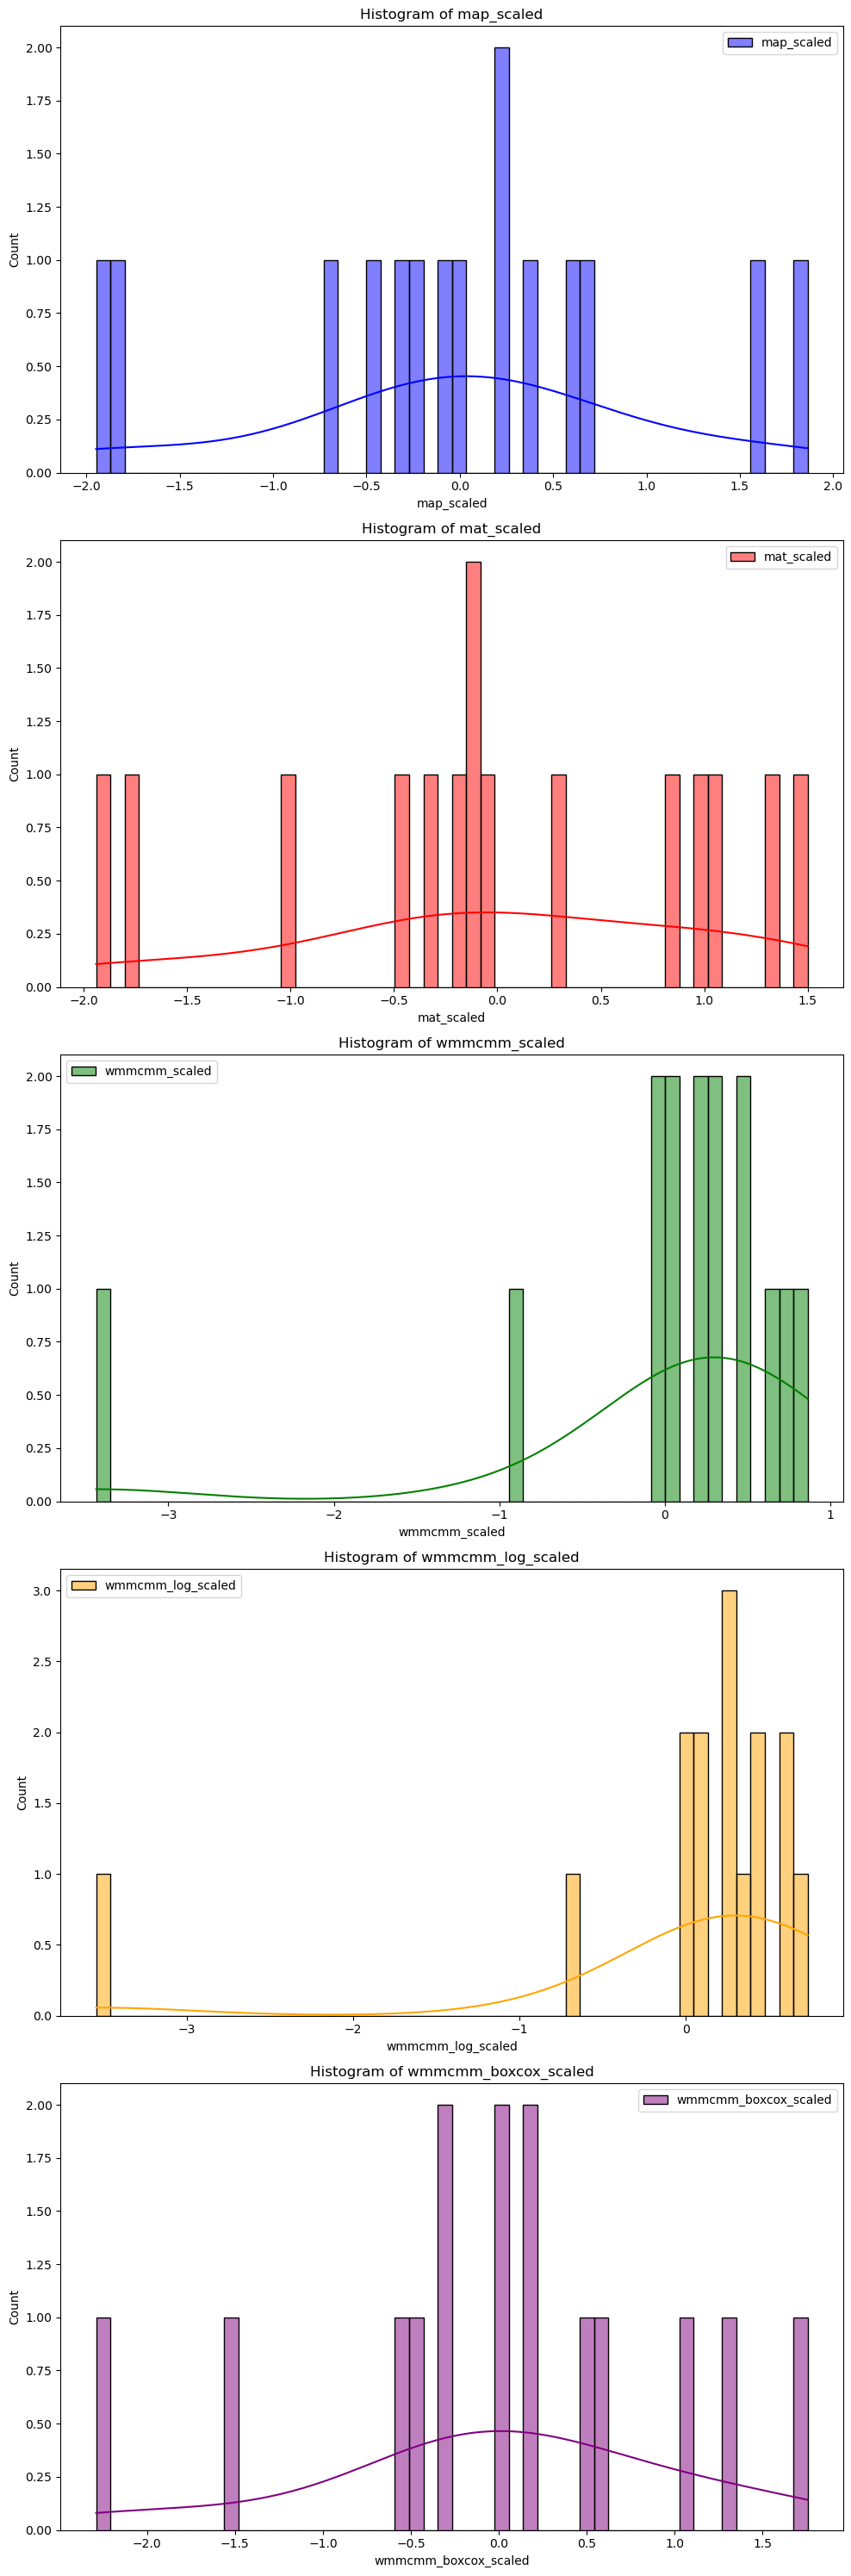

In [ ]:
# Graphing all of the env vars scaled, together
plot_histograms(
    'predictors_plots/env_vars_scaled_plots.pdf',
    (env, 'map_scaled', 'blue'),
    (env, 'mat_scaled', 'red'),
    (env, 'wmmcmm_scaled', 'green'),
    (env, 'wmmcmm_log_scaled', 'orange'),
    (env, 'wmmcmm_boxcox_scaled', 'purple'),
)

### Graphing 'wmmcmm' only

In [79]:
# Graphing all the 'wmmcmm' cols only
plot_histograms(
    'predictors_plots/env_vars_wmmcmm_plots.pdf',
    (env, 'wmmcmm', 'red'),
    (env, 'wmmcmm_scaled', 'green'),
    (env, 'wmmcmm_log_scaled', 'orange'),
    (env, 'wmmcmm_boxcox_scaled', 'purple')
)

NameError: name 'plt' is not defined

### Final 2 env_vars.txt's

In [80]:
# Ok so wmmcmm box cox scaled is still better than just wmmcmm scaled, so I'll use that
env_final = env[['Time', 'map_scaled', 'mat_scaled', 'wmmcmm_boxcox_scaled']]
env_final

KeyError: "['map_scaled', 'mat_scaled', 'wmmcmm_boxcox_scaled'] not in index"

In [ ]:
env_final.to_csv('env_vars_boxcox.txt', sep='\t', index=False)

In [ ]:
# I'll also make one that does not box cox transform the 'wmmcmm' so I can run the model with both to see which is better
env_final_scaled = env[['Time', 'map_scaled', 'mat_scaled', 'wmmcmm_scaled']]
env_final_scaled.to_csv('env_vars_scaled.txt', sep='\t', index=False)
env_final_scaled

,Time,map_scaled,mat_scaled,wmmcmm_scaled
0,293.520,-0.206709,-0.440795,-0.859697
1,290.100,0.635531,-0.080675,-0.028253
2,283.500,0.355349,-0.109144,0.073937
3,272.950,0.709926,1.499417,-3.436919
4,268.800,-1.948294,-1.939310,0.863772
5,265.100,-1.838515,-1.757758,0.476434
6,259.100,-0.085628,-0.175764,0.063661
7,254.140,0.191831,0.288002,-0.062325
8,251.902,-0.015706,-0.144978,0.457019
9,251.200,-0.445702,-0.335868,0.298360


In [ ]:
# Also flipping the order of the env_final so that most recent (youngest) age is first. I.e., the last row is now first
# Just a trouble shoot test for an issue using -BDNNtimevar with -translate
# # Resolved by Torsten! Defunct file
# env_final = pd.read_csv('env_vars.txt', sep='\t')
# env_final_flipped = env_final.iloc[::-1]
# env_final_flipped

In [ ]:
# env_final_flipped.to_csv('env_vars_flipped.txt', sep='\t', index=False)

### Adding To Backscale.txt

Need to add the mean and std of the original 'map', 'mat', 'wmmcmm' columns, under the following names:
1. 'map_scaled'
2. 'mat_scaled'
3. 'wmmcmm_scaled'
4. 'wmmcmm_boxcox_scaled'
    a. Same mean and std as 3. but add wmmcmm_lambda_param

In [81]:
rep_backscale

NameError: name 'rep_backscale' is not defined

In [82]:
# Add new columns to rep_backscale that contains mean and std of env['map', 'mat', 'wmmcmm', 'wmmcmm_boxcox'] (and lambda param of the last one)
# In order to then backscale the scaled versions of all these columns in post-processing
rep_backscale['map_scaled'] = [env['map'].mean(), env['map'].std()]
rep_backscale['mat_scaled'] = [env['mat'].mean(), env['mat'].std()]
rep_backscale['wmmcmm_scaled'] = [env['wmmcmm'].mean(), env['wmmcmm'].std()]
rep_backscale['wmmcmm_boxcox_scaled'] = [env['wmmcmm_boxcox'].mean(), env['wmmcmm_boxcox'].std()]

rep_backscale.loc[2] = {'map_scaled': np.nan, 
                        'mat_scaled': np.nan, 
                        'wmmcmm_scaled': np.nan,
                        'wmmcmm_boxcox_scaled': wmmcmm_lambda_param}
rep_backscale

NameError: name 'rep_backscale' is not defined

In [83]:
# Doing the same for syn_backscale
# All the values are the same since these are universal environmental variables, but since the backscale.txt also contains values for lats and lons, 
# I need to add these env vars separately to a backscale.txt specific to each group (rep, syn, tem)
syn_backscale['map_scaled'] = [env['map'].mean(), env['map'].std()]
syn_backscale['mat_scaled'] = [env['mat'].mean(), env['mat'].std()]
syn_backscale['wmmcmm_scaled'] = [env['wmmcmm'].mean(), env['wmmcmm'].std()]
syn_backscale['wmmcmm_boxcox_scaled'] = [env['wmmcmm_boxcox'].mean(), env['wmmcmm_boxcox'].std()]

syn_backscale.loc[2] = {'map_scaled': np.nan,
                        'mat_scaled': np.nan,
                        'wmmcmm_scaled': np.nan,
                        'wmmcmm_boxcox_scaled': wmmcmm_lambda_param}
syn_backscale

NameError: name 'syn_backscale' is not defined

In [84]:
# Now for tem_backscale
tem_backscale['map_scaled'] = [env['map'].mean(), env['map'].std()]
tem_backscale['mat_scaled'] = [env['mat'].mean(), env['mat'].std()]
tem_backscale['wmmcmm_scaled'] = [env['wmmcmm'].mean(), env['wmmcmm'].std()]
tem_backscale['wmmcmm_boxcox_scaled'] = [env['wmmcmm_boxcox'].mean(), env['wmmcmm_boxcox'].std()]

tem_backscale.loc[2] = {'map_scaled': np.nan,
                        'mat_scaled': np.nan,
                        'wmmcmm_scaled': np.nan,
                        'wmmcmm_boxcox_scaled': wmmcmm_lambda_param}
tem_backscale

NameError: name 'tem_backscale' is not defined

### Creating MBD Directory
MBD model (PyRateContinuous.py, in Tutorial 4 of PyRate) requires separate files for each time-continuous predictor.

Only doing this for the env variables so far. Not the 1myr Temp Data (section below this)


In [54]:
env_vars = pd.read_csv('env_vars_scaled.txt', sep='\t') # reading in b/c don't want to re-run nb to do this
map = env_vars[['Time', 'map_scaled']]
mat = env_vars[['Time', 'mat_scaled']]
wmmcmm = env_vars[['Time', 'wmmcmm_scaled']]
map

,Time,map_scaled
0,293.520,-0.206709
1,290.100,0.635531
2,283.500,0.355349
3,272.950,0.709926
4,268.800,-1.948294
5,265.100,-1.838515
6,259.100,-0.085628
7,254.140,0.191831
8,251.902,-0.015706
9,251.200,-0.445702


In [55]:
map.to_csv('MBD_preds/map.txt', sep='\t', index=False)
mat.to_csv('MBD_preds/mat.txt', sep='\t', index=False)
wmmcmm.to_csv('MBD_preds/wmmcmm.txt', sep='\t', index=False)

### Example original min-max Scaling   

In [ ]:
# def analyze_and_transform_distribution(series, plot_title=None):
#     """
#     Analyze, transform, and visualize a numeric series/column.
    
#     Parameters:
#     -----------
#     series : pandas.Series
#         The input data series to transform (e.g., env['wmmcmm'] or myr_temp['mean'])
#     plot_title : str, optional
#         Custom title for the plots. If None, uses the series name
        
#     Returns:
#     --------
#     pandas.DataFrame
#         DataFrame containing all transformations and their normalized versions
#     """
#     import numpy as np
#     import pandas as pd
#     import scipy.stats as stats
#     import matplotlib.pyplot as plt
    
#     # Create DataFrame with original data
#     column_name = series.name if series.name is not None else 'input_data'
#     df_transform = pd.DataFrame({column_name: series})
    
#     # Ensure data is positive and non-zero for log transform
#     min_val = df_transform[column_name].min()
#     if min_val <= 0:
#         print(f"Warning: Data contains values ≤ 0. Adding |min| + 1 to make all values positive for log transform.")
#         df_transform[column_name] = df_transform[column_name] - min_val + 1
    
#     # 1. Log transformation
#     df_transform[f'{column_name}_log'] = np.log(df_transform[column_name])
    
#     # 2. Box-Cox transformation
#     try:
#         boxcox_result, lambda_param = stats.boxcox(df_transform[column_name])
#         df_transform[f'{column_name}_boxcox'] = boxcox_result
#         boxcox_success = True
#     except:
#         print("Warning: Box-Cox transformation failed. Skipping this transformation.")
#         lambda_param = None
#         boxcox_success = False
    
#     # 3. Cube root transformation
#     df_transform[f'{column_name}_cbrt'] = np.cbrt(df_transform[column_name])
    
#     # 4. Min-max normalization function
#     def min_max_normalize(x):
#         return (x - x.min()) / (x.max() - x.min())
    
#     # Apply normalization to original and all transformations
#     transform_types = ['', '_log', '_cbrt']
#     if boxcox_success:
#         transform_types.append('_boxcox')
        
#     for suffix in transform_types:
#         df_transform[f'{column_name}{suffix}_normalized'] = min_max_normalize(df_transform[f'{column_name}{suffix}'])
    
#     # Create visualization
#     fig, axes = plt.subplots(len(transform_types), 2, figsize=(15, 5*len(transform_types)))
#     title = plot_title if plot_title else f'Distribution Comparison for {column_name}'
#     fig.suptitle(f'{title}\nLeft: Raw Transformations, Right: Min-Max Normalized', fontsize=14)
    
#     # Colors for the plots
#     raw_color = 'skyblue'
#     normalized_color = 'lightgreen'
    
#     # Plot histograms
#     for idx, suffix in enumerate(transform_types):
#         # Raw transformation
#         df_transform[f'{column_name}{suffix}'].hist(ax=axes[idx,0], bins=30, color=raw_color)
#         axes[idx,0].set_title(f'{"Original" if suffix == "" else suffix.strip("_").title()}')
#         axes[idx,0].set_xlabel('Value')
#         axes[idx,0].set_ylabel('Frequency')
        
#         # Normalized version
#         df_transform[f'{column_name}{suffix}_normalized'].hist(ax=axes[idx,1], bins=30, color=normalized_color)
#         axes[idx,1].set_title(f'{"Original" if suffix == "" else suffix.strip("_").title()} (Normalized)')
#         axes[idx,1].set_xlabel('Value')
#         axes[idx,1].set_ylabel('Frequency')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary statistics
#     print("\nSkewness comparison:")
#     print(df_transform.skew())
    
#     # Shapiro-Wilk tests
#     print("\nShapiro-Wilk normality tests:")
#     for col in df_transform.columns:
#         stat, p_value = stats.shapiro(df_transform[col])
#         print(f"\n{col}:")
#         print(f"  Statistic: {stat:.4f}")
#         print(f"  p-value: {p_value:.4f}")
    
#     # Print Box-Cox lambda if transformation was successful
#     if boxcox_success:
#         print(f"\nBox-Cox transformation lambda parameter: {lambda_param:.4f}")
    
#     # Print range of values
#     print("\nRange of values for each transformation:")
#     for col in df_transform.columns:
#         print(f"\n{col}:")
#         print(f"  Min: {df_transform[col].min():.4f}")
#         print(f"  Max: {df_transform[col].max():.4f}")
#         print(f"  Mean: {df_transform[col].mean():.4f}")
#         print(f"  Median: {df_transform[col].median():.4f}")
    
#     return df_transform

### Min-Max Scaling

In [99]:
# Same code as used for creation of "env" dataframe from the beginning of this section
env_minmax = pd.read_csv('climateGlobalmeanLAND.txt', sep='\t')
stages_map = {'Sakmarian':293.52, 'Artinskian':290.1, 'Kungurian':283.5, 'Roadian':272.95, 'Wordian':268.8,
              'Capitanian':265.1, 'Wuchiapingian':259.1, 'Changhsingian':254.14, 'Induan':251.902, 'Olenekian':251.2,
              'Anisian':247.2, 'Ladinian':242, 'Carnian':237, 'Norian':227, 'Rhaetian':208.5}              
# Create new column mapping 'Stage' to a specific age using the stages_map dictionary
env_minmax['Time'] = env_minmax['Stage'].map(stages_map)
env_minmax


,Stage,map,mat,wmmcmm,Time
0,Sakmarian,467.7526,1.625588,33.21412,293.520
1,Artinskian,520.7936,3.638446,36.96527,290.100
2,Kungurian,503.1488,3.479318,37.42631,283.500
3,Roadian,525.4787,12.470220,21.58670,272.950
4,Wordian,358.0743,-6.750223,40.98974,268.800
5,Capitanian,364.9878,-5.735454,39.24222,265.100
6,Wuchiapingian,475.3778,3.106955,37.37995,259.100
7,Changhsingian,492.8511,5.699131,36.81155,254.140
8,Induan,479.7812,3.279027,39.15463,251.902
9,Olenekian,452.7017,2.212064,38.43882,251.200


In [100]:
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import numpy as np

scaler_map = MinMaxScaler()
scaler_mat = MinMaxScaler()
scaler_wmmcmm = MinMaxScaler()
scaler_wmmcmm_boxcox = MinMaxScaler()
scaler_wmmcmm_log = MinMaxScaler()

env_minmax['map_minmax'] = scaler_map.fit_transform(env_minmax[['map']])
env_minmax['mat_minmax'] = scaler_mat.fit_transform(env_minmax[['mat']])
env_minmax['wmmcmm_minmax'] = scaler_wmmcmm.fit_transform(env_minmax[['wmmcmm']])

# 1. Log transformation
env_minmax['wmmcmm_log'] = np.log(env_minmax['wmmcmm'])
env_minmax['wmmcmm_log_minmax'] = scaler_wmmcmm_log.fit_transform(env_minmax[['wmmcmm_log']])

# 2. Box-Cox transformation
env_minmax['wmmcmm_boxcox'], wmmcmm_lambda_param = stats.boxcox(env_minmax['wmmcmm'])
env_minmax['wmmcmm_boxcox_minmax'] = scaler_wmmcmm_boxcox.fit_transform(env_minmax[['wmmcmm_boxcox']])

env_minmax

,Stage,map,mat,wmmcmm,Time,map_minmax,mat_minmax,wmmcmm_minmax,wmmcmm_log,wmmcmm_log_minmax,wmmcmm_boxcox,wmmcmm_boxcox_minmax
0,Sakmarian,467.7526,1.625588,33.21412,293.520,0.456932,0.435776,0.599258,3.502975,0.671971,1.062489e+11,0.187055
1,Artinskian,520.7936,3.638446,36.96527,290.100,0.677907,0.540501,0.792586,3.609979,0.838840,2.457260e+11,0.441297
2,Kungurian,503.1488,3.479318,37.42631,283.500,0.604396,0.532222,0.816347,3.622374,0.858170,2.707888e+11,0.486982
3,Roadian,525.4787,12.470220,21.58670,272.950,0.697425,1.000000,0.000000,3.072077,0.000000,3.630846e+09,0.000000
4,Wordian,358.0743,-6.750223,40.98974,268.800,0.000000,0.000000,1.000000,3.713322,1.000000,5.522305e+11,1.000000
5,Capitanian,364.9878,-5.735454,39.24222,265.100,0.028802,0.052796,0.909936,3.669753,0.932056,3.925178e+11,0.708872
6,Wuchiapingian,475.3778,3.106955,37.37995,259.100,0.488699,0.512849,0.813958,3.621134,0.856237,2.681717e+11,0.482211
7,Changhsingian,492.8511,5.699131,36.81155,254.140,0.561495,0.647714,0.784663,3.605812,0.832341,2.378321e+11,0.426907
8,Induan,479.7812,3.279027,39.15463,251.902,0.507044,0.521801,0.905422,3.667519,0.928572,3.857051e+11,0.696454
9,Olenekian,452.7017,2.212064,38.43882,251.200,0.394228,0.466289,0.868530,3.649068,0.899798,3.337863e+11,0.601815


In [101]:
env_minmax_only = env_minmax[['Time', 'map_minmax', 'mat_minmax', 'wmmcmm_minmax']]
env_minmax_log = env_minmax[['Time', 'map_minmax', 'mat_minmax', 'wmmcmm_log_minmax']]
env_minmax_boxcox = env_minmax[['Time', 'map_minmax', 'mat_minmax', 'wmmcmm_boxcox_minmax']]
env_minmax_only

,Time,map_minmax,mat_minmax,wmmcmm_minmax
0,293.520,0.456932,0.435776,0.599258
1,290.100,0.677907,0.540501,0.792586
2,283.500,0.604396,0.532222,0.816347
3,272.950,0.697425,1.000000,0.000000
4,268.800,0.000000,0.000000,1.000000
5,265.100,0.028802,0.052796,0.909936
6,259.100,0.488699,0.512849,0.813958
7,254.140,0.561495,0.647714,0.784663
8,251.902,0.507044,0.521801,0.905422
9,251.200,0.394228,0.466289,0.868530


In [104]:
env_minmax_log

,Time,map_minmax,mat_minmax,wmmcmm_log_minmax
0,293.520,0.456932,0.435776,0.671971
1,290.100,0.677907,0.540501,0.838840
2,283.500,0.604396,0.532222,0.858170
3,272.950,0.697425,1.000000,0.000000
4,268.800,0.000000,0.000000,1.000000
5,265.100,0.028802,0.052796,0.932056
6,259.100,0.488699,0.512849,0.856237
7,254.140,0.561495,0.647714,0.832341
8,251.902,0.507044,0.521801,0.928572
9,251.200,0.394228,0.466289,0.899798


In [103]:
env_minmax_boxcox

,Time,map_minmax,mat_minmax,wmmcmm_boxcox_minmax
0,293.520,0.456932,0.435776,0.187055
1,290.100,0.677907,0.540501,0.441297
2,283.500,0.604396,0.532222,0.486982
3,272.950,0.697425,1.000000,0.000000
4,268.800,0.000000,0.000000,1.000000
5,265.100,0.028802,0.052796,0.708872
6,259.100,0.488699,0.512849,0.482211
7,254.140,0.561495,0.647714,0.426907
8,251.902,0.507044,0.521801,0.696454
9,251.200,0.394228,0.466289,0.601815


In [105]:
env_minmax_only.to_csv('env_vars_minmax.txt', sep='\t', index=False)
env_minmax_log.to_csv('env_vars_minmax_log.txt', sep='\t', index=False)
env_minmax_boxcox.to_csv('env_vars_minmax_boxcox.txt', sep='\t', index=False)

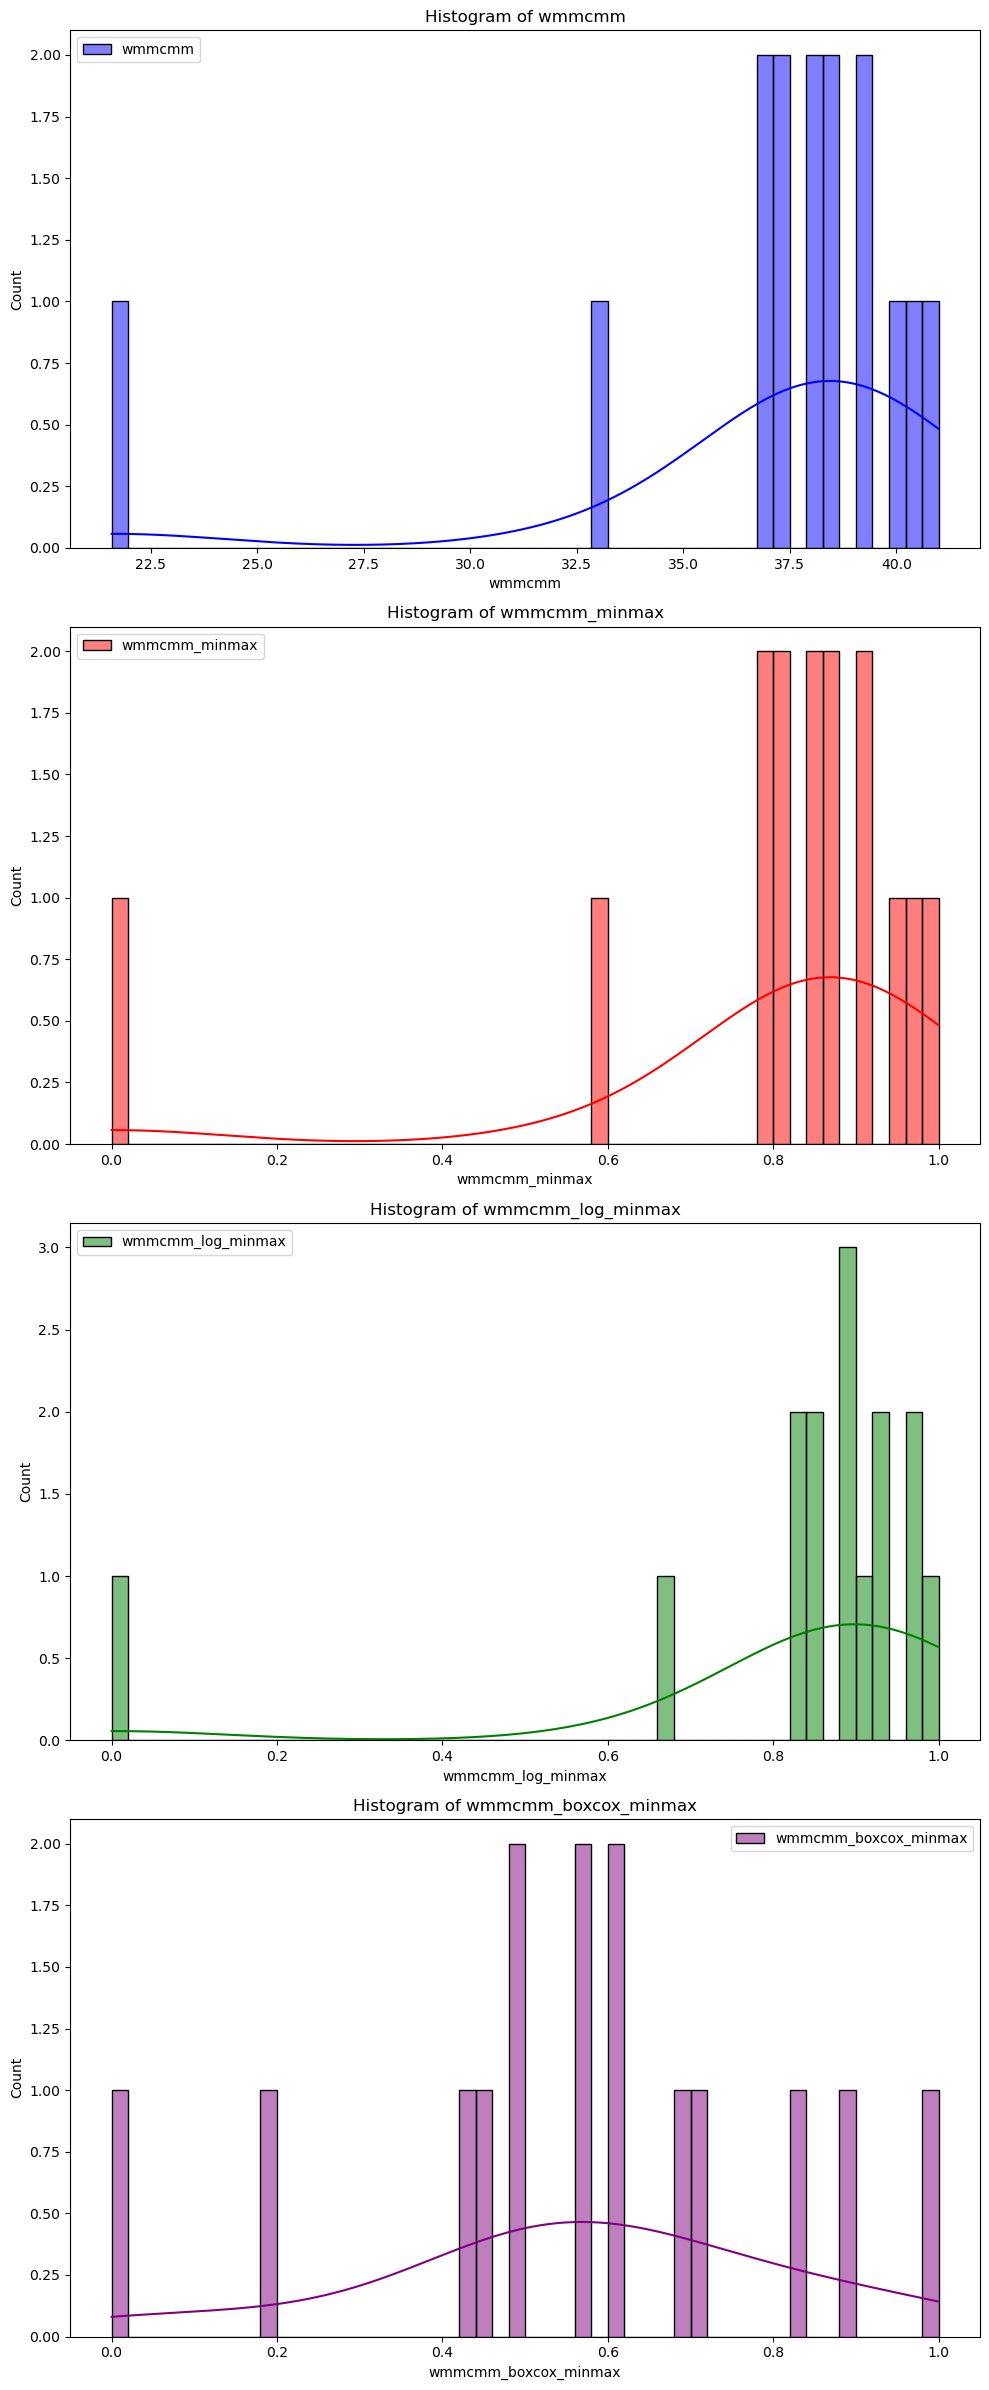

In [114]:
plot_histograms(
    'predictors_plots/env_minmax_wmmcmm_plots.pdf',
    (env_minmax, 'wmmcmm', 'blue'),
    (env_minmax, 'wmmcmm_minmax', 'red'),
    (env_minmax, 'wmmcmm_log_minmax', 'green'),
    (env_minmax, 'wmmcmm_boxcox_minmax', 'purple')
)

## 1myr Temp Data

For use with BDNN with no -fixShift (Birth Death Model time bins). We will have BDNN with the default 1 million year time bins, so we want to submit it with environmental variables for which we also have 1 myr resolution. That is the temp data csv below!

Notes from Tiago: "Use as predictors: mean temperature per 1 Myr ("mean") and modal value for rate of temperature change per 1 Myr ("Mod_R_deltaTMyr"). The ages ("age") go until 202Ma only, but that's because there is too much missing data for 201 and 200Ma. Still, it will get through all the important time periods we need."

In [560]:
myr_temp = pd.read_csv('PaleoEnvData_1MyrBins.csv')
myr_temp = myr_temp.drop(columns=['X0.05', 'X0.95'])
myr_temp

,age,mean,Mod_R_deltaTMyr
0,300,30.431385,0.496400
1,299,29.392182,1.039204
2,298,27.019217,2.372964
3,297,28.111086,1.091868
4,296,29.660536,1.549450
5,295,30.803133,1.142597
6,294,25.438014,5.365119
7,293,26.112405,0.674390
8,292,28.248801,2.136397
9,291,26.030803,2.217998


### Visalizing Distributions

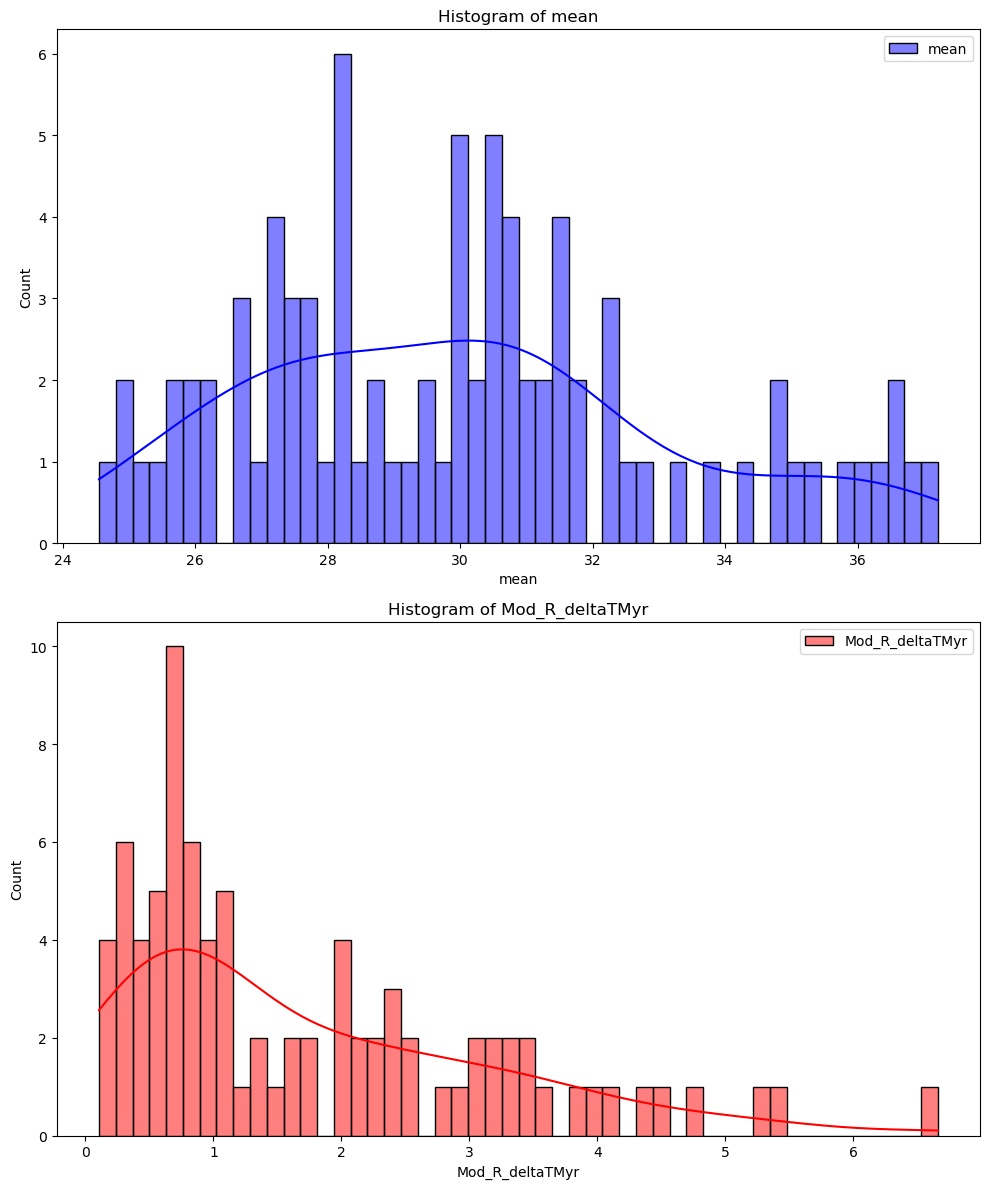

In [561]:
plot_histograms(
    'predictors_plots/1myr_temp_plots.pdf',
    (myr_temp, 'mean', 'blue'),
    (myr_temp, 'Mod_R_deltaTMyr', 'red')
)

In [562]:
mean_scaler = StandardScaler()
myr_temp['mean_scaled'] = mean_scaler.fit_transform(myr_temp[['mean']])
myr_temp

,age,mean,Mod_R_deltaTMyr,mean_scaled
0,300,30.431385,0.496400,0.135311
1,299,29.392182,1.039204,-0.192132
2,298,27.019217,2.372964,-0.939830
3,297,28.111086,1.091868,-0.595793
4,296,29.660536,1.549450,-0.107576
5,295,30.803133,1.142597,0.252445
6,294,25.438014,5.365119,-1.438052
7,293,26.112405,0.674390,-1.225558
8,292,28.248801,2.136397,-0.552400
9,291,26.030803,2.217998,-1.251270


### Testing 'Mod..." Transformations


Skewness comparison:
Mod_R_deltaTMyr           1.157639
Mod_R_deltaTMyr_log      -0.349057
Mod_R_deltaTMyr_boxcox   -0.042619
Mod_R_deltaTMyr_cbrt      0.224813
dtype: float64

Shapiro-Wilk test for Mod_R_deltaTMyr:
Shaprio-Wilk Statistic: 0.8785, p-value: 0.0000

Shapiro-Wilk test for Mod_R_deltaTMyr_log:
Shaprio-Wilk Statistic: 0.9742, p-value: 0.0856

Shapiro-Wilk test for Mod_R_deltaTMyr_boxcox:
Shaprio-Wilk Statistic: 0.9804, p-value: 0.2227

Shapiro-Wilk test for Mod_R_deltaTMyr_cbrt:
Shaprio-Wilk Statistic: 0.9745, p-value: 0.0901


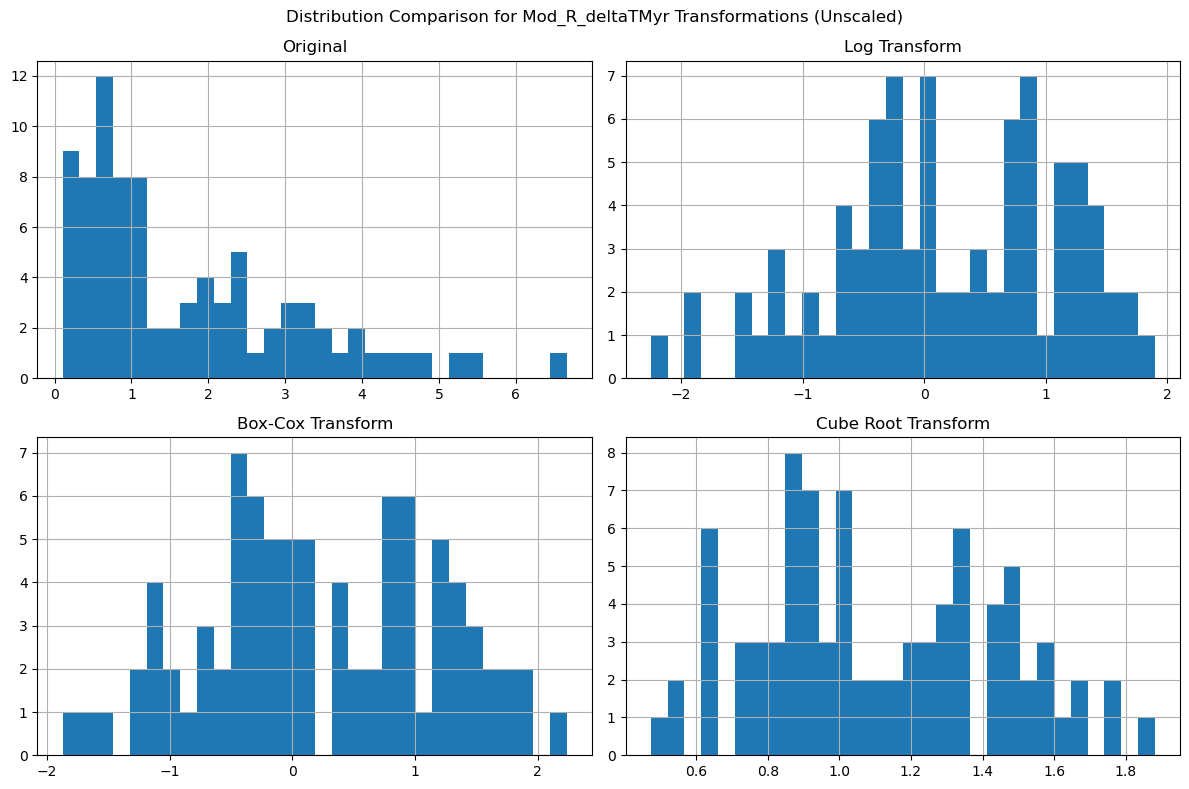


Box-Cox transformation lambda parameter: 0.1687


In [563]:
# TESTING DIFFERENT TRANSFORMATIONS FOR Mod_R_deltaTMyr's LEFT SKEW

import scipy.stats as stats

# 1. Log transformation
myr_temp['Mod_R_deltaTMyr_log'] = np.log(myr_temp['Mod_R_deltaTMyr'])

# 2. Box-Cox transformation
myr_temp['Mod_R_deltaTMyr_boxcox'], Mod_lambda_param = stats.boxcox(myr_temp['Mod_R_deltaTMyr'])

# 3. Cube root transformation
myr_temp['Mod_R_deltaTMyr_cbrt'] = np.cbrt(myr_temp['Mod_R_deltaTMyr'])

# 4. StandardScaler normalization function, instantiating a new scaler for each column passed to the function
def standardize_column(column):
    scaler = StandardScaler()
    return scaler.fit_transform(column.values.reshape(-1, 1))

# Apply standardization to original and all transformations
for suffix in ['', '_log', '_boxcox', '_cbrt']:
    col = f'Mod_R_deltaTMyr{suffix}'
    myr_temp[f'Mod_R_deltaTMyr{suffix}_scaled'] = standardize_column(myr_temp[col])

# Print summary statistics to help choose the best transformation. We want the lowest skew value!
print("\nSkewness comparison:")
print(myr_temp[['Mod_R_deltaTMyr', 'Mod_R_deltaTMyr_log', 'Mod_R_deltaTMyr_boxcox', 'Mod_R_deltaTMyr_cbrt']].skew())

# Check normality using Shapiro-Wilk test. We want an S-W Statistic close to 1, and the largest p-value
for suffix in ['', '_log', '_boxcox', '_cbrt']:
    col = f'Mod_R_deltaTMyr{suffix}'
    stat, p_value = stats.shapiro(myr_temp[col])
    print(f"\nShapiro-Wilk test for {col}:")
    print(f"Shaprio-Wilk Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Visualization code
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distribution Comparison for Mod_R_deltaTMyr Transformations (Unscaled)')

myr_temp['Mod_R_deltaTMyr'].hist(ax=axes[0,0], bins=30)
axes[0,0].set_title('Original')

myr_temp['Mod_R_deltaTMyr_log'].hist(ax=axes[0,1], bins=30)
axes[0,1].set_title('Log Transform')

myr_temp['Mod_R_deltaTMyr_boxcox'].hist(ax=axes[1,0], bins=30)
axes[1,0].set_title('Box-Cox Transform')

myr_temp['Mod_R_deltaTMyr_cbrt'].hist(ax=axes[1,1], bins=30)
axes[1,1].set_title('Cube Root Transform')

plt.tight_layout()
plt.show()

# Print the lambda parameter from Box-Cox transform
print(f"\nBox-Cox transformation lambda parameter: {Mod_lambda_param:.4f}")

In [564]:
Mod_lambda_param

0.168720456534297

In [565]:
# Just like env['wmmcmm'], boxcox is the best transformation
myr_temp

,age,mean,Mod_R_deltaTMyr,mean_scaled,Mod_R_deltaTMyr_log,Mod_R_deltaTMyr_boxcox,Mod_R_deltaTMyr_cbrt,Mod_R_deltaTMyr_scaled,Mod_R_deltaTMyr_log_scaled,Mod_R_deltaTMyr_boxcox_scaled,Mod_R_deltaTMyr_cbrt_scaled
0,300,30.431385,0.496400,0.135311,-0.700373,-0.660575,0.791791,-0.865252,-0.931664,-0.956983,-0.963218
1,299,29.392182,1.039204,-0.192132,0.038455,0.038580,1.012901,-0.486496,-0.142360,-0.221643,-0.293058
2,298,27.019217,2.372964,-0.939830,0.864140,0.930311,1.333820,0.444172,0.739736,0.716242,0.679614
3,297,28.111086,1.091868,-0.595793,0.087890,0.088545,1.029730,-0.449748,-0.089547,-0.169091,-0.242050
4,296,29.660536,1.549450,-0.107576,0.437900,0.454483,1.157158,-0.130457,0.284376,0.215786,0.144170
5,295,30.803133,1.142597,0.252445,0.133304,0.134814,1.045437,-0.414350,-0.041031,-0.120428,-0.194445
6,294,25.438014,5.365119,-1.438052,1.679919,1.942175,1.750625,2.532031,1.611249,1.780477,1.942909
7,293,26.112405,0.674390,-1.225558,-0.393946,-0.381140,0.876941,-0.741055,-0.604303,-0.663085,-0.705138
8,292,28.248801,2.136397,-0.552400,0.759121,0.809878,1.287935,0.279101,0.627542,0.589575,0.540543
9,291,26.030803,2.217998,-1.251270,0.796605,0.852619,1.304128,0.336040,0.667587,0.634529,0.589624


### Graphing Transformed Data

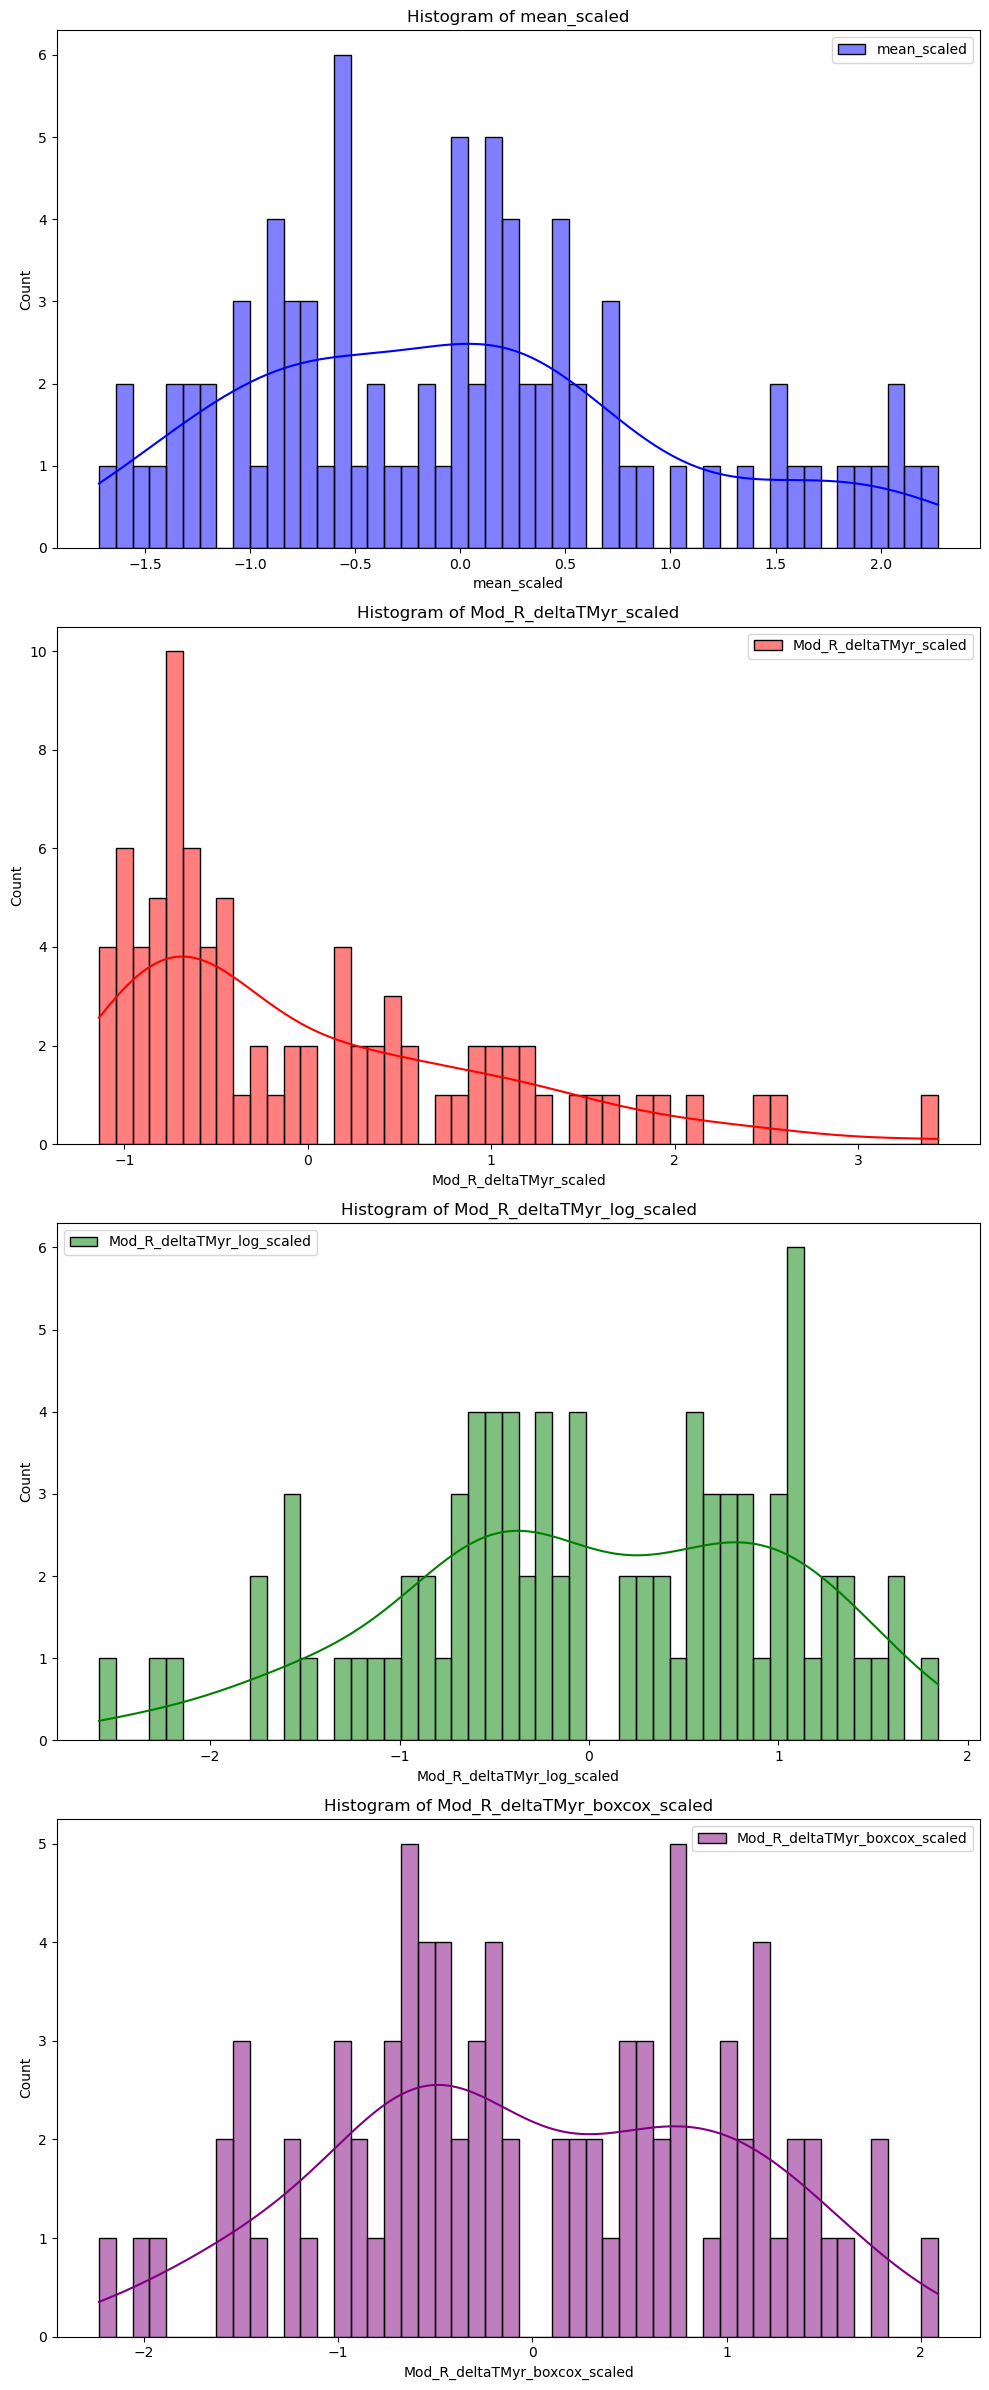

In [566]:
# Let's visualize the distribution of the transformed 'mean' and the 'Mod_R_deltaTMyr' columns
plot_histograms(
    'predictors_plots/1myr_temp_scaled_plots.pdf',
    (myr_temp, 'mean_scaled', 'blue'),
    (myr_temp, 'Mod_R_deltaTMyr_scaled', 'red'),
    (myr_temp, 'Mod_R_deltaTMyr_log_scaled', 'green'),
    (myr_temp, 'Mod_R_deltaTMyr_boxcox_scaled', 'purple')
)

### Graphing the 'Mod_R_deltaTMyr' column ONLY


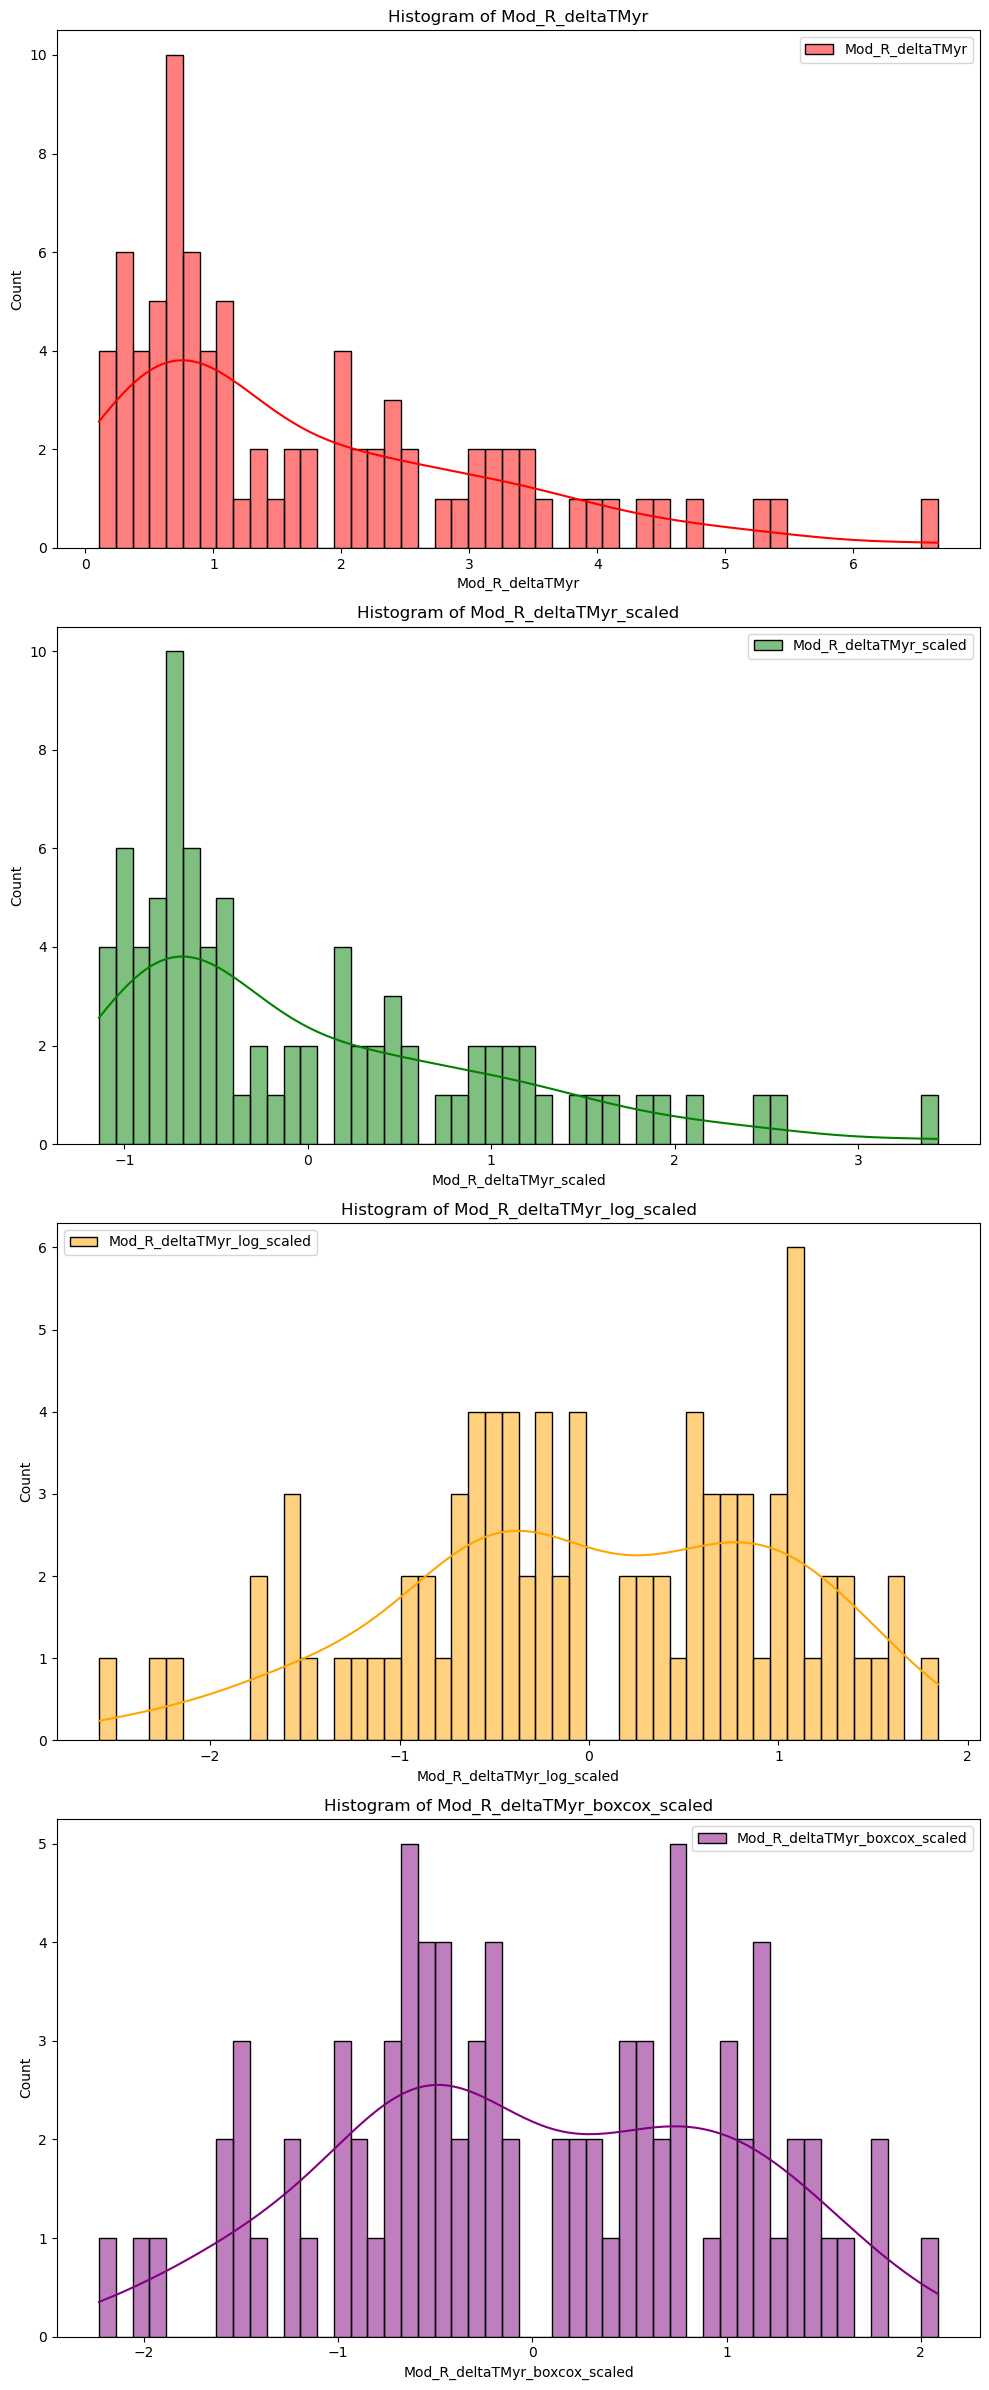

In [567]:
# Let's visualize the distribution of the 'Mod_R_deltaTMyr' column ONLY
plot_histograms(
    'predictors_plots/1myr_temp_Mod_plots.pdf',
    (myr_temp, 'Mod_R_deltaTMyr', 'red'),
    (myr_temp, 'Mod_R_deltaTMyr_scaled', 'green'),
    (myr_temp, 'Mod_R_deltaTMyr_log_scaled', 'orange'),
    (myr_temp, 'Mod_R_deltaTMyr_boxcox_scaled', 'purple')
)
  

### Final 2 1myr_temp.txts

In [568]:
myr_temp.rename(columns={'age': 'Time'}, inplace=True)
myr_temp.head()

,Time,mean,Mod_R_deltaTMyr,mean_scaled,Mod_R_deltaTMyr_log,Mod_R_deltaTMyr_boxcox,Mod_R_deltaTMyr_cbrt,Mod_R_deltaTMyr_scaled,Mod_R_deltaTMyr_log_scaled,Mod_R_deltaTMyr_boxcox_scaled,Mod_R_deltaTMyr_cbrt_scaled
0,300,30.431385,0.496400,0.135311,-0.700373,-0.660575,0.791791,-0.865252,-0.931664,-0.956983,-0.963218
1,299,29.392182,1.039204,-0.192132,0.038455,0.038580,1.012901,-0.486496,-0.142360,-0.221643,-0.293058
2,298,27.019217,2.372964,-0.939830,0.864140,0.930311,1.333820,0.444172,0.739736,0.716242,0.679614
3,297,28.111086,1.091868,-0.595793,0.087890,0.088545,1.029730,-0.449748,-0.089547,-0.169091,-0.242050
4,296,29.660536,1.549450,-0.107576,0.437900,0.454483,1.157158,-0.130457,0.284376,0.215786,0.144170


In [569]:
myr_temp_scaled = myr_temp[['Time', 'mean_scaled', 'Mod_R_deltaTMyr_scaled']]
myr_temp_scaled.to_csv('1myr_temp_scaled.txt', sep='\t', index=False)
myr_temp_scaled

,Time,mean_scaled,Mod_R_deltaTMyr_scaled
0,300,0.135311,-0.865252
1,299,-0.192132,-0.486496
2,298,-0.939830,0.444172
3,297,-0.595793,-0.449748
4,296,-0.107576,-0.130457
5,295,0.252445,-0.414350
6,294,-1.438052,2.532031
7,293,-1.225558,-0.741055
8,292,-0.552400,0.279101
9,291,-1.251270,0.336040


In [570]:
myr_temp_boxcox = myr_temp[['Time', 'mean_scaled', 'Mod_R_deltaTMyr_boxcox_scaled']]
myr_temp_boxcox.to_csv('1myr_temp_boxcox.txt', sep='\t', index=False)
myr_temp_boxcox

,Time,mean_scaled,Mod_R_deltaTMyr_boxcox_scaled
0,300,0.135311,-0.956983
1,299,-0.192132,-0.221643
2,298,-0.939830,0.716242
3,297,-0.595793,-0.169091
4,296,-0.107576,0.215786
5,295,0.252445,-0.120428
6,294,-1.438052,1.780477
7,293,-1.225558,-0.663085
8,292,-0.552400,0.589575
9,291,-1.251270,0.634529


In [594]:
myr_temp_log = myr_temp[['Time', 'mean_scaled', 'Mod_R_deltaTMyr_log_scaled']]
myr_temp_log.to_csv('1myr_temp_log.txt', sep='\t', index=False)
myr_temp_log

,Time,mean_scaled,Mod_R_deltaTMyr_log_scaled
0,300,0.135311,-0.931664
1,299,-0.192132,-0.142360
2,298,-0.939830,0.739736
3,297,-0.595793,-0.089547
4,296,-0.107576,0.284376
5,295,0.252445,-0.041031
6,294,-1.438052,1.611249
7,293,-1.225558,-0.604303
8,292,-0.552400,0.627542
9,291,-1.251270,0.667587


### Saving Final Backscale.txt

In [595]:
rep_backscale['mean_scaled'] = [myr_temp['mean'].mean(), myr_temp['mean'].std(), np.nan]
rep_backscale['Mod_R_deltaTMyr_scaled'] = [myr_temp['Mod_R_deltaTMyr'].mean(), myr_temp['Mod_R_deltaTMyr'].std(), np.nan]
rep_backscale['Mod_R_deltaTMyr_boxcox_scaled'] = [myr_temp['Mod_R_deltaTMyr_boxcox'].mean(), myr_temp['Mod_R_deltaTMyr_boxcox'].std(), Mod_lambda_param]
rep_backscale['Mod_R_deltaTMyr_log_scaled'] = [myr_temp['Mod_R_deltaTMyr_log'].mean(), myr_temp['Mod_R_deltaTMyr_log'].std(), np.nan]

rep_backscale

,rotated_lat_scaled,rotated_lon_scaled,map_scaled,mat_scaled,wmmcmm_scaled,wmmcmm_boxcox_scaled,mean_scaled,Mod_R_deltaTMyr_scaled,Mod_R_deltaTMyr_boxcox_scaled,Mod_R_deltaTMyr_log_scaled
0,-1.649635,1.843582,480.770307,4.089369,37.092737,3.141607e+11,30.001950,1.736411,0.249316,0.171710
1,34.773192,44.310370,65.186473,5.785585,4.669959,1.404148e+11,3.192528,1.441626,0.956433,0.941604
2,NaN,NaN,NaN,NaN,NaN,7.835545e+00,NaN,NaN,0.168720,NaN


In [596]:
syn_backscale['mean_scaled'] = [myr_temp['mean'].mean(), myr_temp['mean'].std(), np.nan]
syn_backscale['Mod_R_deltaTMyr_scaled'] = [myr_temp['Mod_R_deltaTMyr'].mean(), myr_temp['Mod_R_deltaTMyr'].std(), np.nan]
syn_backscale['Mod_R_deltaTMyr_boxcox_scaled'] = [myr_temp['Mod_R_deltaTMyr_boxcox'].mean(), myr_temp['Mod_R_deltaTMyr_boxcox'].std(), Mod_lambda_param]
syn_backscale['Mod_R_deltaTMyr_log_scaled'] = [myr_temp['Mod_R_deltaTMyr_log'].mean(), myr_temp['Mod_R_deltaTMyr_log'].std(), np.nan]

syn_backscale

,rotated_lat_scaled,rotated_lon_scaled,map_scaled,mat_scaled,wmmcmm_scaled,wmmcmm_boxcox_scaled,mean_scaled,Mod_R_deltaTMyr_scaled,Mod_R_deltaTMyr_boxcox_scaled,Mod_R_deltaTMyr_log_scaled
0,-34.660461,-5.783020,480.770307,4.089369,37.092737,3.141607e+11,30.001950,1.736411,0.249316,0.171710
1,37.792281,29.052976,65.186473,5.785585,4.669959,1.404148e+11,3.192528,1.441626,0.956433,0.941604
2,NaN,NaN,NaN,NaN,NaN,7.835545e+00,NaN,NaN,0.168720,NaN


In [597]:
tem_backscale['mean_scaled'] = [myr_temp['mean'].mean(), myr_temp['mean'].std(), np.nan]
tem_backscale['Mod_R_deltaTMyr_scaled'] = [myr_temp['Mod_R_deltaTMyr'].mean(), myr_temp['Mod_R_deltaTMyr'].std(), np.nan]
tem_backscale['Mod_R_deltaTMyr_boxcox_scaled'] = [myr_temp['Mod_R_deltaTMyr_boxcox'].mean(), myr_temp['Mod_R_deltaTMyr_boxcox'].std(), Mod_lambda_param]
tem_backscale['Mod_R_deltaTMyr_log_scaled'] = [myr_temp['Mod_R_deltaTMyr_log'].mean(), myr_temp['Mod_R_deltaTMyr_log'].std(), np.nan]

tem_backscale

,rotated_lat_scaled,rotated_lon_scaled,map_scaled,mat_scaled,wmmcmm_scaled,wmmcmm_boxcox_scaled,mean_scaled,Mod_R_deltaTMyr_scaled,Mod_R_deltaTMyr_boxcox_scaled,Mod_R_deltaTMyr_log_scaled
0,12.929946,9.319296,480.770307,4.089369,37.092737,3.141607e+11,30.001950,1.736411,0.249316,0.171710
1,29.203648,36.968738,65.186473,5.785585,4.669959,1.404148e+11,3.192528,1.441626,0.956433,0.941604
2,NaN,NaN,NaN,NaN,NaN,7.835545e+00,NaN,NaN,0.168720,NaN


In [599]:
rep_backscale.to_csv('reptilia_processed_data/reptilia_backscale.txt', sep='\t', index=False)
syn_backscale.to_csv('synapsida_processed_data/synapsida_backscale.txt', sep='\t', index=False)
tem_backscale.to_csv('temnospondyli_processed_data/temnospondyli_backscale.txt', sep='\t', index=False)

### Adding to MBD Directory

In [58]:
myr_temp_scaled = pd.read_csv('1myr_temp_scaled.txt', sep='\t')
mean_temp = myr_temp_scaled[['Time', 'mean_scaled']]
Mod = myr_temp_scaled[['Time', 'Mod_R_deltaTMyr_scaled']]
myr_temp_scaled

,Time,mean_scaled,Mod_R_deltaTMyr_scaled
0,300,0.135311,-0.865252
1,299,-0.192132,-0.486496
2,298,-0.939830,0.444172
3,297,-0.595793,-0.449748
4,296,-0.107576,-0.130457
...,...,...,...
80,206,0.138179,-0.522030
81,205,-0.226130,-0.404855
82,204,0.035533,-0.632168
83,203,0.124157,-1.015368


In [59]:
mean_temp

,Time,mean_scaled
0,300,0.135311
1,299,-0.192132
2,298,-0.939830
3,297,-0.595793
4,296,-0.107576
...,...,...
80,206,0.138179
81,205,-0.226130
82,204,0.035533
83,203,0.124157


In [60]:
mean_temp.to_csv('MBD_preds/1myr_mean_temp.txt', sep='\t', index=False)
Mod.to_csv('MBD_preds/1myr_Mod.txt', sep='\t', index=False)

### Min Max Scaling

In [112]:
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import numpy as np

scaler_mean = MinMaxScaler()
scaler_Mod = MinMaxScaler()

myr_temp_minmax = pd.read_csv('PaleoEnvData_1MyrBins.csv')
myr_temp_minmax = myr_temp_minmax.drop(columns=['X0.05', 'X0.95'])
myr_temp_minmax['mean_minmax'] = scaler_mean.fit_transform(myr_temp_minmax[['mean']])
myr_temp_minmax['Mod_R_deltaTMyr_minmax'] = scaler_Mod.fit_transform(myr_temp_minmax[['Mod_R_deltaTMyr']])

# 1. Log transformation
myr_temp_minmax['Mod_R_deltaTMyr_log'] = np.log(myr_temp_minmax['Mod_R_deltaTMyr'])
myr_temp_minmax['Mod_R_deltaTMyr_log_minmax'] = scaler_mean.fit_transform(myr_temp_minmax[['Mod_R_deltaTMyr_log']])

# 2. Box-Cox transformation
myr_temp_minmax['Mod_R_deltaTMyr_boxcox'], mean_lambda_param = stats.boxcox(myr_temp_minmax['Mod_R_deltaTMyr'])
myr_temp_minmax['Mod_R_deltaTMyr_boxcox_minmax'] = scaler_mean.fit_transform(myr_temp_minmax[['Mod_R_deltaTMyr_boxcox']])

myr_temp_minmax

,age,mean,Mod_R_deltaTMyr,mean_minmax,Mod_R_deltaTMyr_minmax,Mod_R_deltaTMyr_log,Mod_R_deltaTMyr_log_minmax,Mod_R_deltaTMyr_boxcox,Mod_R_deltaTMyr_boxcox_minmax
0,300,30.431385,0.496400,0.464531,0.059637,-0.700373,0.373743,-0.660575,0.295019
1,299,29.392182,1.039204,0.382512,0.142425,0.038455,0.551924,0.038580,0.465246
2,298,27.019217,2.372964,0.195225,0.345851,0.864140,0.751052,0.930311,0.682361
3,297,28.111086,1.091868,0.281401,0.150458,0.087890,0.563846,0.088545,0.477411
4,296,29.660536,1.549450,0.403692,0.220248,0.437900,0.648257,0.454483,0.566508
...,...,...,...,...,...,...,...,...,...
80,206,30.440487,0.988279,0.465250,0.134658,-0.011790,0.539806,-0.011779,0.452985
81,205,29.284282,1.156205,0.373996,0.160271,0.145143,0.577653,0.146935,0.491628
82,204,30.114721,0.830439,0.439539,0.110585,-0.185801,0.497841,-0.182919,0.411316
83,203,30.395986,0.281265,0.461738,0.026825,-1.268456,0.236740,-1.141909,0.177826


In [116]:
myr_temp_minmax_only = myr_temp_minmax[['age', 'mean_minmax', 'Mod_R_deltaTMyr_minmax']]
myr_temp_minmax_log = myr_temp_minmax[['age', 'mean_minmax', 'Mod_R_deltaTMyr_log_minmax']]
myr_temp_minmax_boxcox = myr_temp_minmax[['age', 'mean_minmax', 'Mod_R_deltaTMyr_boxcox_minmax']]  

myr_temp_minmax_only.to_csv('1myr_temp_minmax.txt', sep='\t', index=False)
myr_temp_minmax_log.to_csv('1myr_temp_minmax_log.txt', sep='\t', index=False)
myr_temp_minmax_boxcox.to_csv('1myr_temp_minmax_boxcox.txt', sep='\t', index=False)

myr_temp_minmax_only

,age,mean_minmax,Mod_R_deltaTMyr_minmax
0,300,0.464531,0.059637
1,299,0.382512,0.142425
2,298,0.195225,0.345851
3,297,0.281401,0.150458
4,296,0.403692,0.220248
...,...,...,...
80,206,0.465250,0.134658
81,205,0.373996,0.160271
82,204,0.439539,0.110585
83,203,0.461738,0.026825


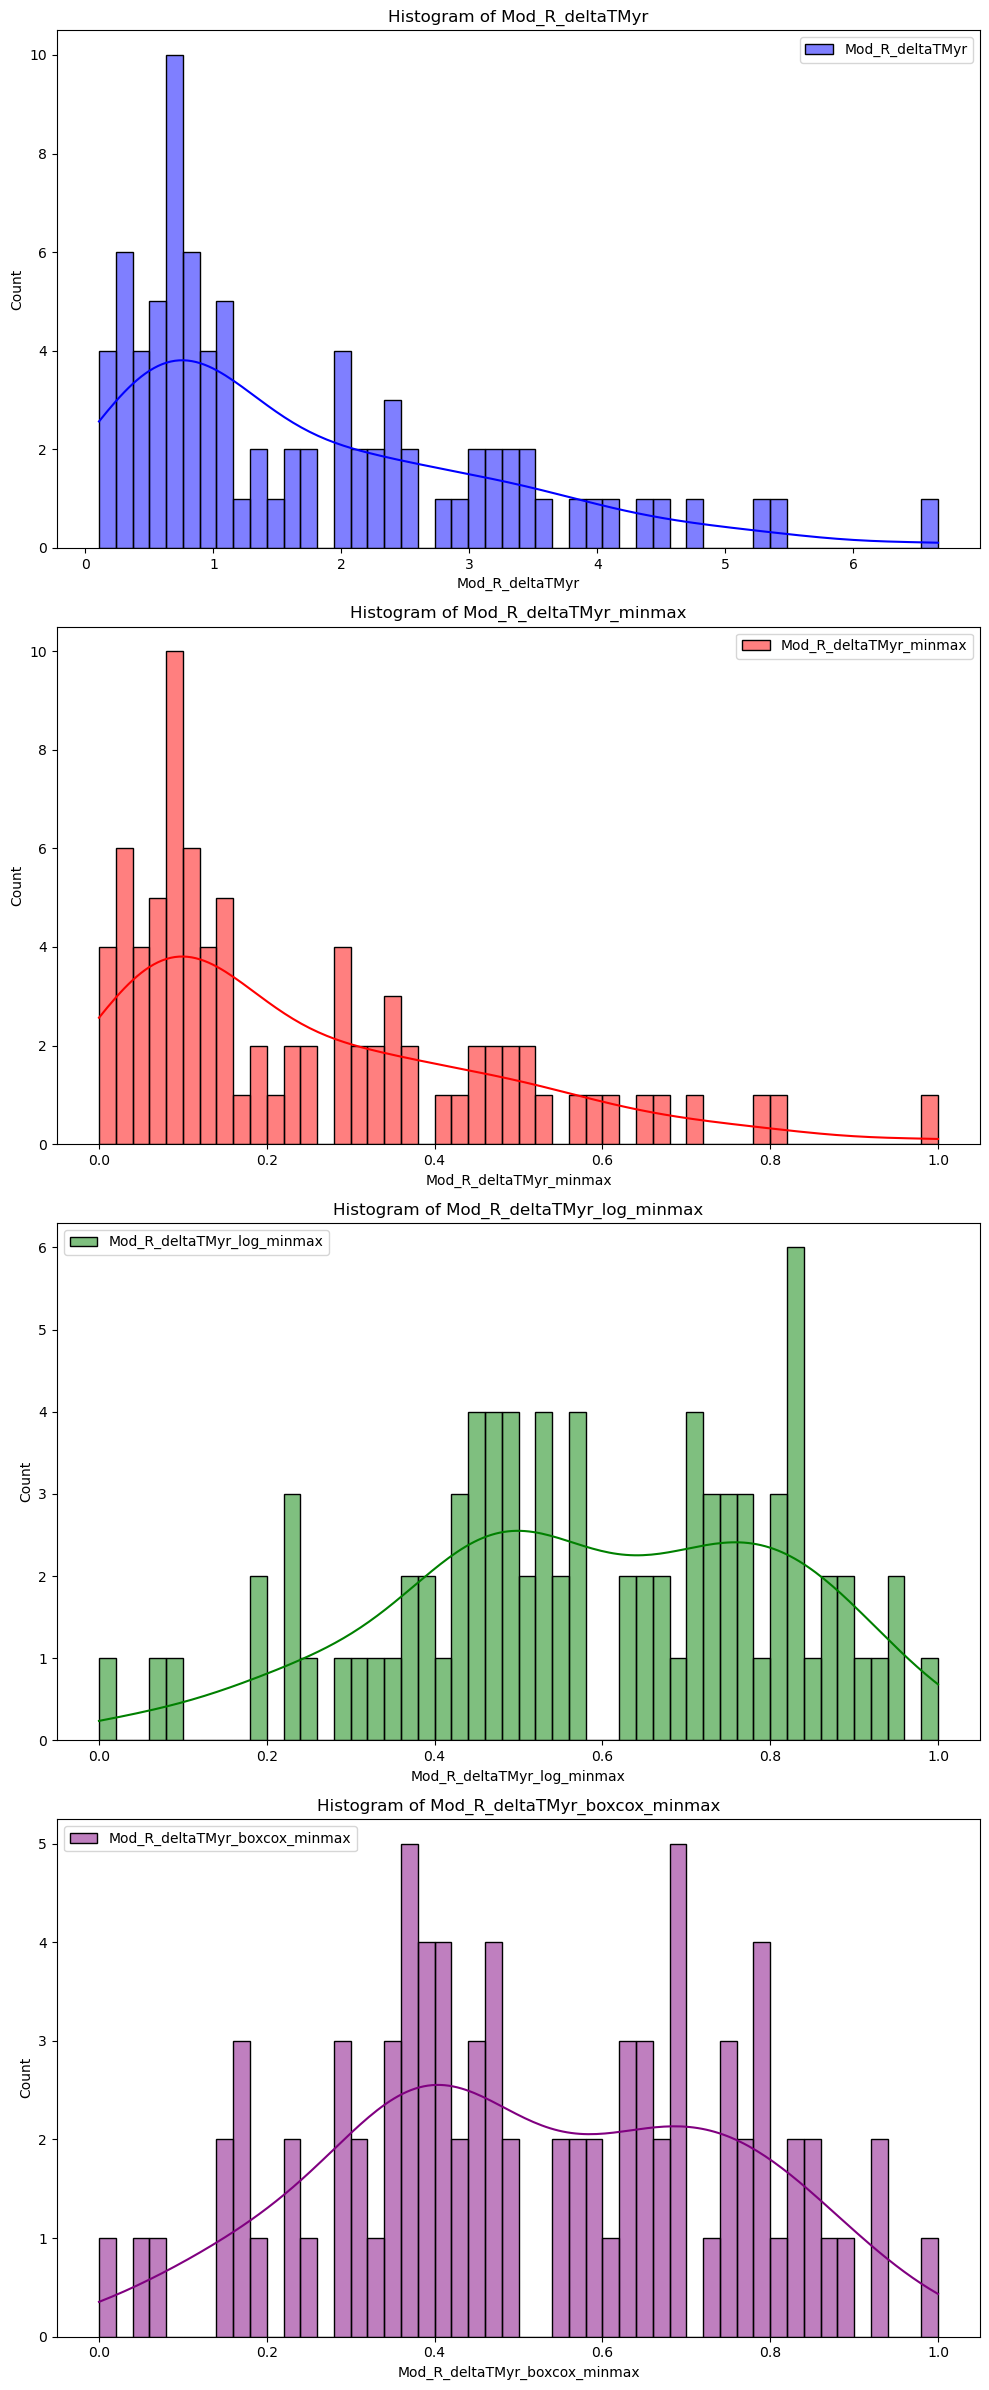

In [113]:
plot_histograms(
    'predictors_plots/1myr_temp_Mod_minmax_plots.pdf',
    (myr_temp_minmax, 'Mod_R_deltaTMyr', 'blue'),
    (myr_temp_minmax, 'Mod_R_deltaTMyr_minmax', 'red'), 
    (myr_temp_minmax, 'Mod_R_deltaTMyr_log_minmax', 'green'),
    (myr_temp_minmax, 'Mod_R_deltaTMyr_boxcox_minmax', 'purple')
)

# HESPDIV 
Area partitioning for DeepDive. Need species occurrence data + coordinates PER TIME BIN

Time_bins_ByStages.txt:

All are < the previous, >= the current
1. =290.1+
2. 283.5
3. 273
4. 264.3
5. 259.5
6. 252
7. 247
8. 242
9. 237
10. 227
11. 217
12. 208
13. 208+

In [338]:
# Custom function to plot age RANGE (x) frequency (y) with log scale
def range_plot(df, df_name):
    # Count the frequency of each age range
    df['range'] = df.apply(lambda row: (row['age_max'], row['age_min']), axis=1)
    frequency = df['range'].value_counts().sort_index()

    # Create the plot
    fig, ax = plt.subplots(figsize=(12,6))

    # Plot each range as a horizontal line with log-transformed y-values
    for (age_min, age_max), count in frequency.items():
        ax.plot([age_min, age_max], [np.log(count)] * 2, 'b-', linewidth=2)

    # Set the axis labels and title
    ax.set_xlabel('Age')
    ax.set_ylabel('Log(Frequency)')
    ax.set_title(f'{df_name} Age Range Frequency Plot (Log Scale)')

    # Get the x-axis limits
    x_min, x_max = ax.get_xlim()

    # Create ticks for every 1 unit
    ticks = np.arange(np.ceil(x_min), np.floor(x_max) + 1, 1)
    ax.set_xticks(ticks)

    # Create labels for every 5 units
    labels = [str(int(x)) if x % 5 == 0 else '' for x in ticks]
    ax.set_xticklabels(labels)

    # Invert the x-axis
    ax.invert_xaxis()

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add horizontal line at y=log(10)
    ax.axhline(y=np.log(10), color='r', linestyle='--', linewidth=2)

    # Customize y-axis ticks to show original frequency values
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{np.exp(y):.0f}' for y in y_ticks])

    # Add vertical lines at the time-bin x-values
    vertical_lines = [290.1, 283.5, 273, 264.3, 259.5, 252, 247, 242, 237, 227, 217, 208]
    for vline in vertical_lines:
        ax.axvline(x=vline, color='g', linestyle='--', linewidth=1)

    # Show the plot
    plt.tight_layout()
    # plt.savefig(f'{df_name.lower()}_age_range_plot_log.png', dpi=300)
    plt.show()
    plt.close()

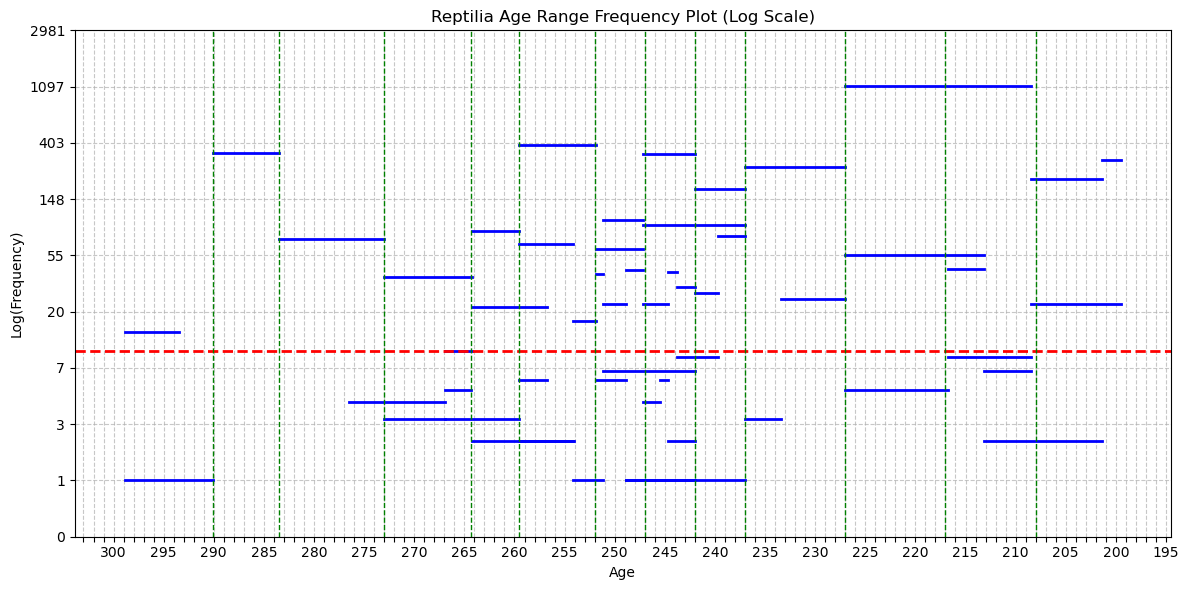

In [339]:
range_plot(rep_bdnn_binned, 'Reptilia')

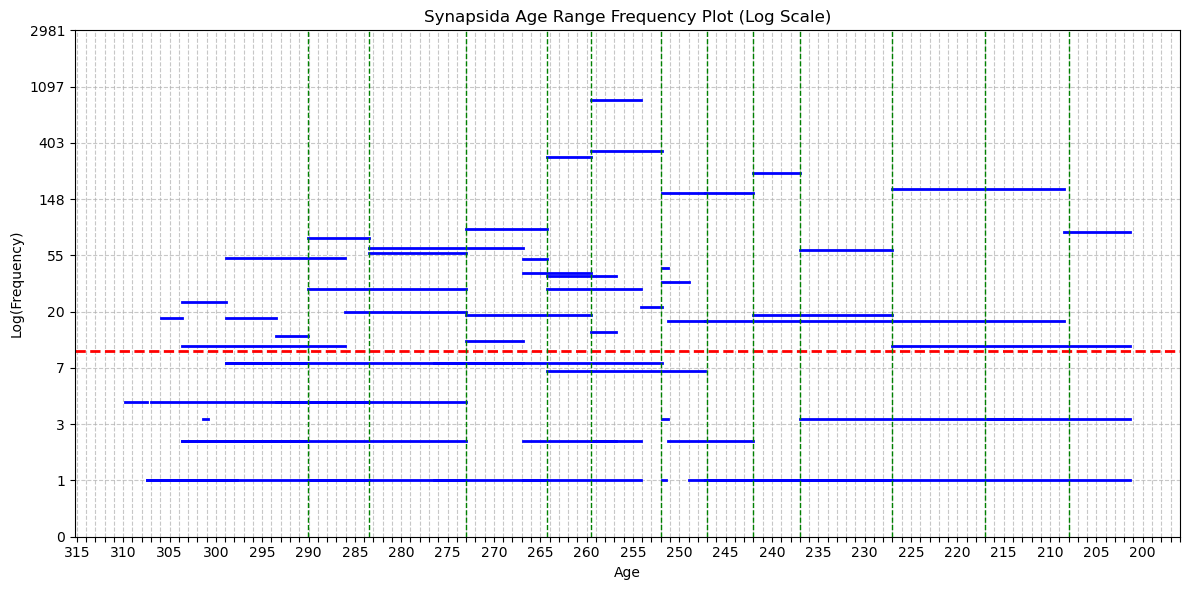

In [340]:
range_plot(syn_bdnn_binned, 'Synapsida')

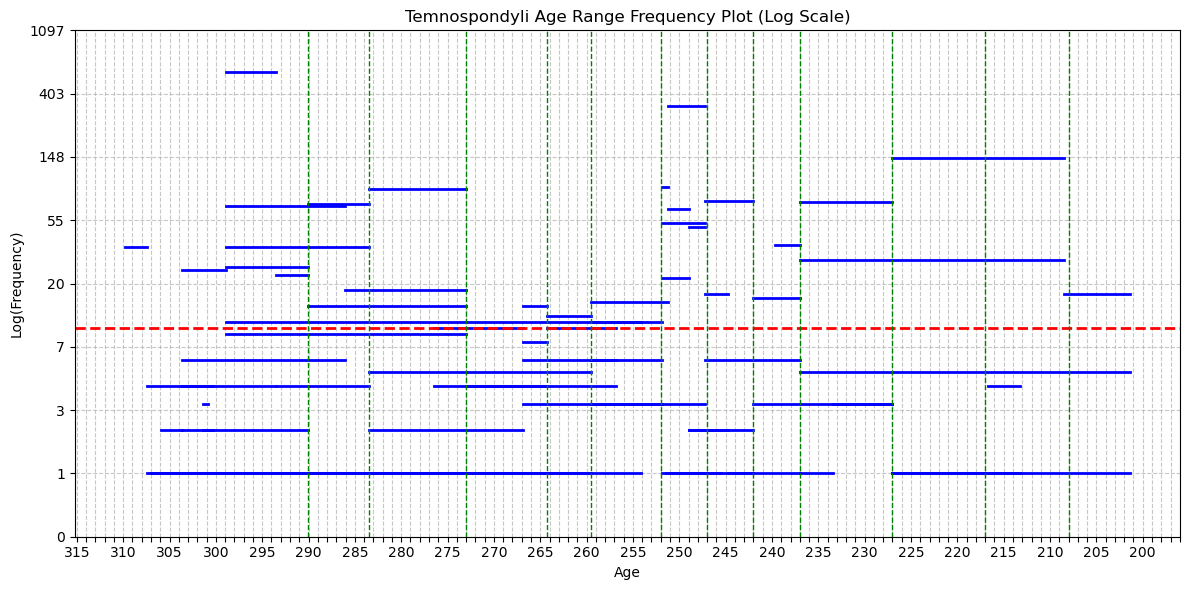

In [341]:
range_plot(tem_bdnn_binned, 'Temnospondyli')

Discussion:

If I use hespdiv to get bioregions that existed per time bin, I would need to first decide which occurrences deserve to be included in that time bin. That's fairly easy: maybe just choose any occurrence whose age_min and age_max span touches that time bin. 

I will run hespdiv separately on just that subset of occurrences for that time bin. Results: Areas ID'd from hespdiv = we know which of them existed during each time bin --> we have an areas_matrix for DeepDive 

However, each occurrence still needs an "Area" value for DeepDive input. That means occurrences that span across time bins still need to be assigned ONE "Area" value. For occs that span across time bins where their "Area" classification might not exist in one of the time bins, that will effectively cause them to disappear for DeepDive when their Area classification disappears 

In [342]:
# Let's try the first time bin for now, just to test
# hespdiv needs: occs in rows, species and lat lon columns

# Subset to only rows whose age_min >= 290.1
rep_bdnn_binned_1 = rep_bdnn_binned[rep_bdnn_binned['age_min'] >= 290.1]
rep_bdnn_binned_1 = rep_bdnn_binned_1[['id', 'genus', 'Rotated Lat', 'Rotated Lon']]
rep_bdnn_binned_1

# This is way too small/few occurrences for one time bin for hespdiv, so I'll have to combine across rep syn and tem

,id,genus,Rotated Lat,Rotated Lon
161,4250,Bolosaurus,-2.7466,-38.9219
1190,3215,Protorothyris,-1.3035,-22.1408
1191,3216,Protorothyris,-1.3035,-22.1408
1192,3217,Protorothyris,-1.3035,-22.1408
1193,3218,Protorothyris,-1.3035,-22.1408
1194,3219,Protorothyris,-1.3035,-22.1408
1195,3220,Protorothyris,-1.3035,-22.1408
1196,3221,Protorothyris,-1.3035,-22.1408
1282,3125,Protorothyris,-2.7466,-38.9219
1283,3126,Protorothyris,-2.7466,-38.9219


In [343]:
# Seeing how many occs syn would have in this time bin
syn_bdnn_binned_1 = syn_bdnn_binned[syn_bdnn_binned['age_min'] >= 290.1]
syn_bdnn_binned_1 = syn_bdnn_binned_1[['id', 'genus', 'Rotated Lat', 'Rotated Lon']]
syn_bdnn_binned_1

,id,genus,Rotated Lat,Rotated Lon
0,3422,Edaphosaurus,-0.4818,-24.8936
3,3419,Ophiacodon,5.8574,-44.6091
6,3416,Ophiacodon,-0.5219,-37.7808
47,3375,Dimetrodon,-2.9673,-38.9083
48,3374,Ophiacodon,-2.9673,-38.9083
49,3373,Dimetrodon,-2.9673,-38.9083
50,3372,Ophiacodon,-2.9673,-38.9083
51,3371,Dimetrodon,-2.9673,-38.9083
52,3370,Dimetrodon,-2.9673,-38.9083
53,3369,Edaphosaurus,-2.9673,-38.9083


In [344]:
# Datasets can share id's
syn_bdnn_binned_1[syn_bdnn_binned_1['id'].isin(rep_bdnn_binned_1['id'])]

,id,genus,Rotated Lat,Rotated Lon
2139,1283,Haptodus,12.5951,19.408


In [345]:
rep_bdnn_binned_1[rep_bdnn_binned_1['id']==1283]

,id,genus,Rotated Lat,Rotated Lon
3128,1283,Aphelosaurus,5.4598,17.9322


However, rep, tem, and syn will never share 'genus' names
After I run hespdiv, I will ideally assign each of these rows a "polygon" value
then I will want to merge that polygon value back into the original rep, syn, and tem datasets
But making sure that the correct occurrence gets the correct "polygon" value
So while rep, tem, and syn datasets can share 'id's, they'll never share 'genus' names
So I'll keep the 'id' column for

In [346]:
# Combining the datasets one under the other
cols = ['id', 'genus', 'Rotated Lat', 'Rotated Lon', 'age_max', 'age_min']
all_bdnn_binned = pd.concat([
    rep_bdnn_binned[cols],
    syn_bdnn_binned[cols],
    tem_bdnn_binned[cols]
], axis=0)
all_bdnn_binned.shape, rep_bdnn_binned.shape[0] + syn_bdnn_binned.shape[0] + tem_bdnn_binned.shape[0]

((9822, 6), 9822)

In [347]:
all_bdnn_binned

,id,genus,Rotated Lat,Rotated Lon,age_max,age_min
0,4411,Icarosaurus,6.7390,-20.6269,227.000,208.5
1,4410,Rutiodon,6.7390,-20.6269,227.000,208.5
2,4409,Kuehneosuchus,35.9688,2.1884,208.500,201.4
3,4408,Kuehneosaurus,35.9688,2.1884,208.500,201.4
4,4407,Procolophon,-62.6208,-11.8191,251.902,247.2
...,...,...,...,...,...,...
2242,5,Rastosuchus,-46.3881,-25.2811,266.900,264.3
2243,4,Rastosuchus,-46.3881,-25.2811,266.900,264.3
2244,3,Rastosuchus,-46.3881,-25.2811,266.900,264.3
2245,2,Compsocerops_Temperate_S,-46.1164,-4.6554,227.000,208.5


In [348]:
rep_bdnn_binned.isna().sum(), syn_bdnn_binned.isna().sum(), tem_bdnn_binned.isna().sum(), all_bdnn_binned.isna().sum()

(id                    0
 Rotated Lat           0
 Rotated Lon           0
 genus                 0
 taxon_environment     0
 age_max               0
 age_min               0
 rotated_lat_scaled    0
 rotated_lon_scaled    0
 range                 0
 dtype: int64,
 id                      0
 Rotated Lat             0
 Rotated Lon             0
 genus                   0
 taxon_environment     310
 age_max                 0
 age_min                 0
 rotated_lat_scaled      0
 rotated_lon_scaled      0
 range                   0
 dtype: int64,
 id                     0
 Rotated Lat            0
 Rotated Lon            0
 genus                  0
 taxon_environment     14
 age_max                0
 age_min                0
 rotated_lat_scaled     0
 rotated_lon_scaled     0
 range                  0
 dtype: int64,
 id             0
 genus          0
 Rotated Lat    0
 Rotated Lon    0
 age_max        0
 age_min        0
 dtype: int64)

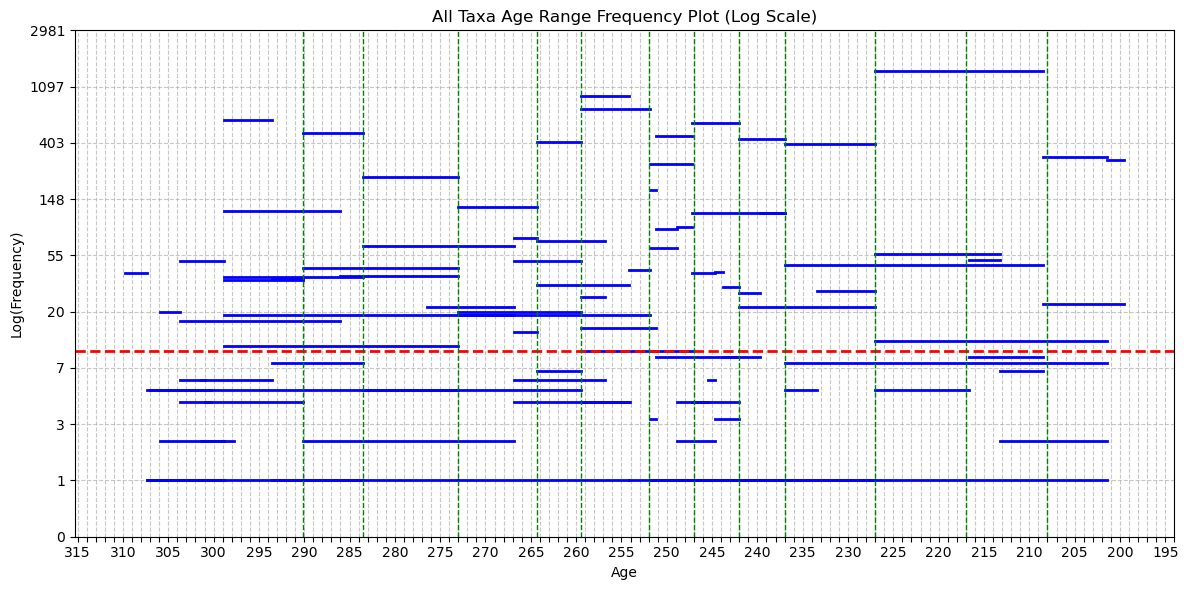

In [349]:
range_plot(all_bdnn_binned, 'All Taxa')

In [350]:
# Function for separating all_bdnn_binned by whether or not it touches a time bin

def filter_by_timebin(df, time_min, time_max):
    df_timebin = df[(df['age_min'] >= time_min) & (df['age_max'] <= time_max)]
    return df_timebin

Time bins list: 
1. =290.1+
2. 283.5
3. 273
4. 264.3
5. 259.5
6. 252
7. 247
8. 242
9. 237
10. 227
11. 217
12. 208
13. 208+

In [351]:
hespdiv_bin1 = filter_by_timebin(all_bdnn_binned, 290.1, 400)
hespdiv_bin1

# The study used 5,244 data points over an 18 myr time period
# Ours is much less

,id,genus,Rotated Lat,Rotated Lon,age_max,age_min,range
161,4250,Bolosaurus,-2.7466,-38.9219,298.9,290.10,"(298.9, 290.1)"
1190,3215,Protorothyris,-1.3035,-22.1408,298.9,293.52,"(298.9, 293.52)"
1191,3216,Protorothyris,-1.3035,-22.1408,298.9,293.52,"(298.9, 293.52)"
1192,3217,Protorothyris,-1.3035,-22.1408,298.9,293.52,"(298.9, 293.52)"
1193,3218,Protorothyris,-1.3035,-22.1408,298.9,293.52,"(298.9, 293.52)"
...,...,...,...,...,...,...,...
2224,23,Archegosaurus,16.0936,19.7625,298.9,293.52,"(298.9, 293.52)"
2225,22,Branchiosaurus,16.0936,19.7625,298.9,293.52,"(298.9, 293.52)"
2226,21,Melanerpeton,16.0936,19.7625,298.9,293.52,"(298.9, 293.52)"
2227,20,Melanerpeton,16.0936,19.7625,298.9,293.52,"(298.9, 293.52)"


In [352]:
# Confirming that the function worked properly by finding these rows in a different way
# Both are 816 rows, so the function worked properly
all_bdnn_binned[all_bdnn_binned['age_min'] >= 290.1]


,id,genus,Rotated Lat,Rotated Lon,age_max,age_min,range
161,4250,Bolosaurus,-2.7466,-38.9219,298.9,290.10,"(298.9, 290.1)"
1190,3215,Protorothyris,-1.3035,-22.1408,298.9,293.52,"(298.9, 293.52)"
1191,3216,Protorothyris,-1.3035,-22.1408,298.9,293.52,"(298.9, 293.52)"
1192,3217,Protorothyris,-1.3035,-22.1408,298.9,293.52,"(298.9, 293.52)"
1193,3218,Protorothyris,-1.3035,-22.1408,298.9,293.52,"(298.9, 293.52)"
...,...,...,...,...,...,...,...
2224,23,Archegosaurus,16.0936,19.7625,298.9,293.52,"(298.9, 293.52)"
2225,22,Branchiosaurus,16.0936,19.7625,298.9,293.52,"(298.9, 293.52)"
2226,21,Melanerpeton,16.0936,19.7625,298.9,293.52,"(298.9, 293.52)"
2227,20,Melanerpeton,16.0936,19.7625,298.9,293.52,"(298.9, 293.52)"


In [353]:
all_bdnn_binned.describe()

# Hespdiv needs a separate parameter (pacific.region=TRUE) for data that passes the 180th meridian,
# so I'm checking Rotated Lon to see if it meets/passes 180

,id,Rotated Lat,Rotated Lon,age_max,age_min
count,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000
mean,1800.879760,-9.620463,0.931247,253.745067,245.534045
std,1148.126193,39.493223,38.440768,25.472670,27.243724
min,1.000000,-70.949200,-85.215200,201.400000,199.500000
25%,840.000000,-50.092000,-23.107625,237.000000,227.000000
50%,1697.000000,1.353100,-6.621400,251.902000,247.200000
75%,2673.000000,22.980500,19.386375,264.280000,259.510000
max,4411.000000,74.642100,152.608500,309.800000,307.400000


In [354]:
all_bdnn_binned[all_bdnn_binned['genus'].str.contains('[^a-zA-Z_]', regex=True)]['genus']

Series([], Name: genus, dtype: object)

In [355]:
hespdiv_bin2 = filter_by_timebin(all_bdnn_binned, 283.5, 290.1)
hespdiv_bin3 = filter_by_timebin(all_bdnn_binned, 273, 283.5)
hespdiv_bin4 = filter_by_timebin(all_bdnn_binned, 264.3, 273)
hespdiv_bin5 = filter_by_timebin(all_bdnn_binned, 259.5, 264.3)
hespdiv_bin6 = filter_by_timebin(all_bdnn_binned, 252, 259.5)
hespdiv_bin7 = filter_by_timebin(all_bdnn_binned, 247, 252)
hespdiv_bin8 = filter_by_timebin(all_bdnn_binned, 242, 247)
hespdiv_bin9 = filter_by_timebin(all_bdnn_binned, 237, 242)
hespdiv_bin10 = filter_by_timebin(all_bdnn_binned, 227, 237)
hespdiv_bin11 = filter_by_timebin(all_bdnn_binned, 217, 227)
hespdiv_bin12 = filter_by_timebin(all_bdnn_binned, 208, 217)
hespdiv_bin13 = filter_by_timebin(all_bdnn_binned, 0, 208)

In [356]:
hespdiv_bin1.to_csv('hespdiv/hespdiv_bin1.csv', index=False)
# hespdiv_bin2.to_csv('hespdiv/hespdiv_bin2.csv', index=False)
# hespdiv_bin3.to_csv('hespdiv/hespdiv_bin3.csv', index=False)
# hespdiv_bin4.to_csv('hespdiv/hespdiv_bin4.csv', index=False)
# hespdiv_bin5.to_csv('hespdiv/hespdiv_bin5.csv', index=False)
# hespdiv_bin6.to_csv('hespdiv/hespdiv_bin6.csv', index=False)
# hespdiv_bin7.to_csv('hespdiv/hespdiv_bin7.csv', index=False)
# hespdiv_bin8.to_csv('hespdiv/hespdiv_bin8.csv', index=False)
# hespdiv_bin9.to_csv('hespdiv/hespdiv_bin9.csv', index=False)
# hespdiv_bin10.to_csv('hespdiv/hespdiv_bin10.csv', index=False)
# hespdiv_bin11.to_csv('hespdiv/hespdiv_bin11.csv', index=False)
# hespdiv_bin12.to_csv('hespdiv/hespdiv_bin12.csv', index=False)
# hespdiv_bin13.to_csv('hespdiv/hespdiv_bin13.csv', index=False)


# Trouble Shooting Section

### A_BDNN RTT of Combined Log files issue

In [3]:
import pandas as pd
a_bdnn_combined = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/combined_10_mcmc.log', sep='\t')
a_bdnn_combined.isna().sum()


it                      0
posterior               0
prior                   0
PP_lik                  0
BD_lik                  0
                    ...  
Yunnanosaurus_TE        0
Zanclodon_TE            0
Zhongjiania_TE          0
Zupaysaurus_TE          0
Unnamed: 1576       89158
Length: 1577, dtype: int64

In [4]:
nulls = a_bdnn_combined.isna().sum()
nulls[nulls > 0]

Unnamed: 1576    89158
dtype: int64

In [11]:
nulls[nulls > 0].index

Index(['Unnamed: 1576'], dtype='object')

In [15]:
a_bdnn_combined.head()

,it,posterior,prior,PP_lik,BD_lik,q_0,q_1,q_2,q_3,q_4,...,Yimenosaurus_TE,Youngetta_TE,Youngina_TE,Youngosuchus_TE,Yunguisaurus_TE,Yunnanosaurus_TE,Zanclodon_TE,Zhongjiania_TE,Zupaysaurus_TE,Unnamed: 1576
0,0,-17019.777038,-2231.061710,-10696.610913,-4092.104415,0.684103,4.525981,0.477896,1.044224,4.101567,...,24.382310,74.002724,75.301951,70.935361,62.601791,24.453600,28.757712,81.429913,34.750084,NaN
1,1,-17030.170407,-2227.888857,-10711.978423,-4090.303127,0.402958,5.344000,0.515232,1.570986,4.524201,...,24.633825,73.842541,75.277146,70.986898,62.637609,24.261339,28.573735,81.339350,33.542997,NaN
2,2,-16965.146060,-2229.954744,-10649.798529,-4085.392788,0.558838,5.182734,0.465071,0.732591,1.897250,...,24.615898,73.983489,77.493466,70.782109,62.858147,24.292314,28.621338,81.408035,32.680385,NaN
3,3,-16938.838650,-2237.199551,-10625.328354,-4076.310745,0.584176,5.228445,0.506010,0.710923,2.950372,...,24.254294,73.648999,76.868372,70.237141,62.646750,24.328795,29.276861,80.718844,34.247283,NaN
4,4,-16900.429267,-2233.747139,-10585.522672,-4081.159457,0.531132,4.777018,0.625456,0.883525,2.350642,...,24.622798,73.900701,76.745427,70.958337,61.984072,24.418524,28.360976,81.287240,35.012532,NaN


In [ ]:
# a_bdnn_1 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
# nulls_1 = a_bdnn_1.isna().sum()
# nulls_1[nulls_1 > 0]

# Make the above into a function that takes a different value for "1" each time
def check_nulls(file_path):
    df = pd.read_csv(file_path, sep='\t')
    nulls = df.isna().sum()
    nulls = nulls[nulls > 0]
    return nulls

check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_mcmc.log')

Series([], dtype: int64)

In [8]:
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_2_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_3_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_4_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_5_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_6_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_7_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_8_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_9_G_BDS_BDNN_4_2Tc_mcmc.log'))
print(check_nulls('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_10_G_BDS_BDNN_4_2Tc_mcmc.log'))

Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


In [19]:
a_bdnn_1 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_2 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_2_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_3 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_3_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_4 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_4_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_5 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_5_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_6 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_6_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_7 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_7_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_8 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_8_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_9 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_9_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')
a_bdnn_10 = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_10_G_BDS_BDNN_4_2Tc_mcmc.log', sep='\t')

In [ ]:
# Seeing if all the files have the same columns, which they should
# Basically trying to see if the 'Unnamed: 1576' column that the combined log file has (the one with all the nulls)
# originates in one of the original replicates
list(a_bdnn_1.columns) == list(a_bdnn_2.columns) == list(a_bdnn_3.columns) == list(a_bdnn_4.columns) == list(a_bdnn_5.columns) == list(a_bdnn_6.columns) == list(a_bdnn_7.columns) == list(a_bdnn_8.columns) == list(a_bdnn_9.columns) == list(a_bdnn_10.columns)
# a_bdnn_1.columns == a_bdnn_2.columns == a_bdnn_3.columns == a_bdnn_4.columns == a_bdnn_5.columns == a_bdnn_6.columns == a_bdnn_7.columns == a_bdnn_8.columns == a_bdnn_9.columns == a_bdnn_10.columns

True

In [22]:
# The 'Unnamed: 1576' column is not in any of the original files, so it must have been created when combining them
# I'll remove it from the combined file and resave the file
a_bdnn_combined = a_bdnn_combined.drop(columns=['Unnamed: 1576'])
a_bdnn_combined.to_csv('../reptilia/mcmc_no_predictors/A_bdnn/combined_10_mcmc_cleaned.log', sep='\t', index=False)

In [25]:
nulls = a_bdnn_combined.isna().sum()
nulls[nulls > 0]

Series([], dtype: int64)

In [27]:
a_bdnn_1.shape == a_bdnn_combined.shape, a_bdnn_1.columns.tolist() == a_bdnn_combined.columns.tolist()

(False, True)

In [53]:
a_bdnn_combined.shape, a_bdnn_1.shape, a_bdnn_2.shape, a_bdnn_3.shape, a_bdnn_4.shape, a_bdnn_5.shape, a_bdnn_6.shape, a_bdnn_7.shape, a_bdnn_8.shape, a_bdnn_9.shape, a_bdnn_10.shape

((89158, 1576),
 (10000, 1576),
 (10000, 1576),
 (10000, 1576),
 (9693, 1576),
 (9807, 1576),
 (9955, 1576),
 (9607, 1576),
 (10000, 1576),
 (10000, 1576),
 (10000, 1576))

In [29]:
len(a_bdnn_1.columns)

1576

In [30]:
a_bdnn_combined_resampled = a_bdnn_combined.sample(n=10000, random_state=42)
a_bdnn_combined_resampled.to_csv('../reptilia/mcmc_no_predictors/A_bdnn/combined_10_mcmc_cleaned_resampled.log', sep='\t', index=False)

A look into the plot_bdnn_rtt function in bdnn_lib.py of PyRate shows that an empty r_sp_sum and/or r_q_sum might be the issue. These two come from the sp_rates.log and ex_rates.log files. 

In [31]:
a_bdnn_ex_rates = pd.read_csv("../reptilia/mcmc_no_predictors/A_bdnn/combined_10_ex_rates.log", sep='\t')
a_bdnn_sp_rates = pd.read_csv("../reptilia/mcmc_no_predictors/A_bdnn/combined_10_sp_rates.log", sep='\t')
a_bdnn_ex_rates.shape, a_bdnn_sp_rates.shape

((89155, 247), (89158, 247))

In [61]:
a_bdnn_1_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_2_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_2_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_3_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_3_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_4_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_4_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_5_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_5_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_6_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_6_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_7_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_7_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_8_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_8_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_9_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_9_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_10_ex = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_10_G_BDS_BDNN_4_2Tc_ex_rates.log', sep='\t')
a_bdnn_1_ex.shape, a_bdnn_2_ex.shape, a_bdnn_3_ex.shape, a_bdnn_4_ex.shape, a_bdnn_5_ex.shape, a_bdnn_6_ex.shape, a_bdnn_7_ex.shape, a_bdnn_8_ex.shape, a_bdnn_9_ex.shape, a_bdnn_10_ex.shape


((9999, 247),
 (9999, 247),
 (9999, 247),
 (9691, 247),
 (9806, 247),
 (9953, 247),
 (9606, 247),
 (9999, 247),
 (9999, 247),
 (9999, 247))

In [62]:
a_bdnn_1_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_2_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_2_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_3_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_3_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_4_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_4_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_5_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_5_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_6_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_6_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_7_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_7_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_8_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_8_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_9_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_9_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_10_sp = pd.read_csv('../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_10_G_BDS_BDNN_4_2Tc_sp_rates.log', sep='\t')
a_bdnn_1_sp.shape, a_bdnn_2_sp.shape, a_bdnn_3_sp.shape, a_bdnn_4_sp.shape, a_bdnn_5_sp.shape, a_bdnn_6_sp.shape, a_bdnn_7_sp.shape, a_bdnn_8_sp.shape, a_bdnn_9_sp.shape, a_bdnn_10_sp.shape

((9999, 247),
 (9999, 247),
 (9999, 247),
 (9693, 247),
 (9806, 247),
 (9954, 247),
 (9606, 247),
 (9999, 247),
 (9999, 247),
 (9999, 247))

In [63]:
a_bdnn_1_sp.shape[0] + a_bdnn_2_sp.shape[0] + a_bdnn_3_sp.shape[0] + a_bdnn_4_sp.shape[0] + a_bdnn_5_sp.shape[0] + a_bdnn_6_sp.shape[0] + a_bdnn_7_sp.shape[0] + a_bdnn_8_sp.shape[0] + a_bdnn_9_sp.shape[0] + a_bdnn_10_sp.shape[0]

99053

In [64]:
a_bdnn_1_ex.shape[0] + a_bdnn_2_ex.shape[0] + a_bdnn_3_ex.shape[0] + a_bdnn_4_ex.shape[0] + a_bdnn_5_ex.shape[0] + a_bdnn_6_ex.shape[0] + a_bdnn_7_ex.shape[0] + a_bdnn_8_ex.shape[0] + a_bdnn_9_ex.shape[0] + a_bdnn_10_ex.shape[0]

99050

In [52]:
a_bdnn_1_ex_rates = pd.read_csv("../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_ex_rates.log", sep='\t')
a_bdnn_1_ex_rates.head()


,0.6893043035611727,0.6893043103159449,0.6893043203417482,0.689304330367565,0.689304340393395,0.6893043504192382,0.6893043604450945,0.6893043704709636,0.6893043804968455,0.6893043905227402,...,10,9,8,7,6,5,4,3,2,1
0,0.135709,0.135722,0.135741,0.135760,0.135780,0.135800,0.135821,0.135842,0.135863,0.135885,...,10,9,8,7,6,5,4,3,2,1
1,0.142587,0.142588,0.142588,0.142589,0.142589,0.142590,NaN,0.142591,0.142591,0.142592,...,10,9,8,7,6,5,4,3,2,1
2,0.147984,0.148002,0.148030,0.148057,0.148085,0.148113,0.148142,0.148171,0.148200,0.148229,...,10,9,8,7,6,5,4,3,2,1
3,0.142686,0.142689,0.142694,0.142698,0.142703,0.142708,0.142714,0.142719,0.142724,0.142730,...,10,9,8,7,6,5,4,3,2,1
4,0.137641,0.137642,0.137644,0.137645,0.137647,0.137648,0.137650,0.137651,0.137653,0.137654,...,10,9,8,7,6,5,4,3,2,1


In [41]:
a_bdnn_ex_rates.head()

,0.26271500205374027,0.2626637047662528,0.26260037595885705,0.26253287909153566,0.26246088934718326,0.26238405318027397,0.2623019855148511,0.26221426664815767,0.262120438827389,0.2620200024633998,...,10,9,8,7,6,5,4,3,2,1
0,0.324048,0.323886,0.323687,0.323476,0.323251,0.323012,0.322758,0.322487,0.322199,0.321891,...,10,9,8,7,6,5,4,3,2,1
1,0.298766,0.298690,0.298595,0.298493,0.298385,0.298269,0.298144,0.298010,0.297867,0.297713,...,10,9,8,7,6,5,4,3,2,1
2,0.284378,0.284303,0.284210,0.284111,0.284006,0.283893,0.283772,0.283643,0.283504,0.283356,...,10,9,8,7,6,5,4,3,2,1
3,0.253603,0.253577,0.253545,0.253510,0.253472,0.253431,0.253387,0.253340,0.253289,0.253233,...,10,9,8,7,6,5,4,3,2,1
4,0.287036,0.286923,0.286784,0.286637,0.286481,0.286317,0.286142,0.285957,0.285760,0.285551,...,10,9,8,7,6,5,4,3,2,1


In [33]:
# Find only the columns that have nulls
a_bdnn_ex_rates_nulls = a_bdnn_ex_rates.isna().sum()
a_bdnn_ex_rates_nulls[a_bdnn_ex_rates_nulls > 0]


0.2623019855148511     1637
0.707636511859035         4
0.7944262984313201     7380
nan                   44284
nan.1                 72458
nan.2                 83669
nan.3                 87438
nan.4                 88677
nan.5                 89023
nan.6                 89126
nan.7                 89145
nan.8                 89152
nan.9                 89154
nan.10                89155
nan.11                89155
nan.12                89155
nan.13                89155
nan.14                89155
nan.15                89155
nan.16                89155
nan.17                89155
nan.18                89155
nan.19                89155
nan.20                89155
nan.21                89155
dtype: int64

In [34]:
a_bdnn_sp_rates_nulls = a_bdnn_sp_rates.isna().sum()
a_bdnn_sp_rates_nulls[a_bdnn_sp_rates_nulls > 0]

0.2785897615240495      1637
0.15707630044196536        4
0.16656744156317435     7381
nan                    44286
nan.1                  72461
nan.2                  83672
nan.3                  87441
nan.4                  88680
nan.5                  89026
nan.6                  89129
nan.7                  89148
nan.8                  89155
nan.9                  89157
nan.10                 89158
nan.11                 89158
nan.12                 89158
nan.13                 89158
nan.14                 89158
nan.15                 89158
nan.16                 89158
nan.17                 89158
nan.18                 89158
nan.19                 89158
nan.20                 89158
nan.21                 89158
dtype: int64

In [38]:
# Comparing everything against an RTT plot that worked (RJMCMC plots)
rep_rjmcmc_combined = pd.read_csv('../reptilia/mcmc_no_predictors/RJMCMC/combined_10_mcmc.log', sep='\t')
rep_rjmcmc_sp_rates = pd.read_csv('../reptilia/mcmc_no_predictors/RJMCMC/combined_10_sp_rates.log', sep='\t')
rep_rjmcmc_ex_rates = pd.read_csv('../reptilia/mcmc_no_predictors/RJMCMC/combined_10_ex_rates.log', sep='\t')

rep_rjmcmc_combined.shape, rep_rjmcmc_sp_rates.shape, rep_rjmcmc_ex_rates.shape

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xac in position 12029: invalid start byte

In [ ]:
a_bdnn_1_ex_rates = pd.read_csv("../reptilia/mcmc_no_predictors/A_bdnn/reptilia_pyrate_1_G_BDS_BDNN_4_2Tc_ex_rates.log", sep='\t')
a_bdnn_1_ex_rates.shape, a_bdnn_1_ex_rates.isna().sum()

# Finding the columns that have nulls
a_bdnn_1_ex_rates_nulls = a_bdnn_1_ex_rates.isna().sum()
a_bdnn_1_ex_rates_nulls[a_bdnn_1_ex_rates_nulls > 0]

# Seems like it's normal for ex and sp rates .log's to have nulls

0.6893043604450945    1201
0.6893053129447552     441
0.6893053229713536    4166
0.6893053329979542    7663
0.689305343024557     9146
0.6893053530511621    9665
0.6893053630777694    9840
0.6893053731043786    9896
0.6893053831309898    9917
0.6893053931576026    9922
0.689305403184217     9932
0.6893054132108329    9937
0.6893054232374505    9949
0.6893054332640692    9956
0.6893054432906891    9957
0.6893054533173103    9959
0.6893054633439324    9959
0.6893054733705553    9963
0.689305483397179     9964
0.6893054934238034    9968
0.6893055034504283    9971
0.6893055134770537    9976
nan                   9988
nan.1                 9994
dtype: int64

### Test

In [357]:
import pandas as pd
pyrate_input_rep = pd.read_csv('reptilia_processed_data/reptilia_pyrate.txt', sep='\t')
pyrate_input_rep.describe()

,min_age,max_age
count,4247.000000,4247.000000
mean,231.992255,241.247062
std,25.480204,23.353718
min,199.500000,201.400000
25%,208.500000,227.000000
50%,237.000000,239.700000
75%,251.902000,254.140000
max,293.520000,298.900000


In [358]:
pyrate_input_rep.isna().sum()

Species    0
Status     0
min_age    0
max_age    0
dtype: int64

In [359]:
pyrate_input_rep.to_csv('reptilia_processed_data/reptilia_pyrate.csv', index=False)

In [360]:
test_pyrate_input = pd.read_csv('../test_reptilia/data/reptilia/Reptilia_pyrate_input.csv')
test_pyrate_input.describe()

,min_ma,max_ma
count,3843.000000,3843.000000
mean,226.844473,235.666221
std,21.757171,20.286962
min,199.500000,201.400000
25%,208.500000,227.000000
50%,227.000000,237.000000
75%,242.000000,247.200000
max,293.520000,298.900000


In [361]:
test_pyrate_input.isna().sum()  

accepted_name    0
min_ma           0
max_ma           0
dtype: int64

In [362]:
pyrate_input_rep['Species'].nunique(), test_pyrate_input['accepted_name'].nunique()

(760, 738)

In [363]:
time_bins_bystages_test = pd.read_csv('Time_bins_ByStages.txt', sep='\t', header=None)
time_bins_bystages_test

,0
0,290.1
1,283.5
2,273.0
3,264.3
4,259.5
5,252.0
6,247.0
7,242.0
8,237.0
9,227.0


In [364]:
new_row = pd.DataFrame({0:[300]})
time_bins_bystages_test = pd.concat([new_row, time_bins_bystages_test], ignore_index=True)
time_bins_bystages_test

,0
0,300.0
1,290.1
2,283.5
3,273.0
4,264.3
5,259.5
6,252.0
7,247.0
8,242.0
9,237.0


In [365]:
len(time_bins_bystages_test)

13

In [366]:
time_bins_bystages_test.loc[13] = 190

In [367]:
time_bins_bystages_test 

,0
0,300.0
1,290.1
2,283.5
3,273.0
4,264.3
5,259.5
6,252.0
7,247.0
8,242.0
9,237.0


In [368]:
time_bins_bystages_test.to_csv('Time_bins_ByStages_TEST.txt', sep='\t', header=False, index=False)

## Exploring Left LTT plot Age Dist

In [369]:
rep_ltt_test = pd.read_csv('reptilia_processed_data/reptilia_pyrate.txt', sep='\t') 
rep_ltt_test

,Species,Status,min_age,max_age
0,Icarosaurus,extinct,208.5,227.000
1,Rutiodon,extinct,208.5,227.000
2,Kuehneosuchus,extinct,201.4,208.500
3,Kuehneosaurus,extinct,201.4,208.500
4,Procolophon,extinct,247.2,251.902
...,...,...,...,...
4242,Eohyosaurus,extinct,242.0,247.200
4243,Mesosuchus,extinct,242.0,247.200
4244,Mesosuchus,extinct,242.0,247.200
4245,Mesosuchus,extinct,242.0,247.200


In [370]:
rep_ltt_test[rep_ltt_test['max_age'] <210]

,Species,Status,min_age,max_age
2,Kuehneosuchus,extinct,201.4,208.5
3,Kuehneosaurus,extinct,201.4,208.5
68,Proganochelys_Temperate_N,extinct,201.4,208.5
69,Liliensternus,extinct,201.4,208.5
70,Elachistosuchus,extinct,201.4,208.5
...,...,...,...,...
4045,Sinosaurus,extinct,199.5,201.4
4046,Sinosaurus,extinct,199.5,201.4
4050,Ichthyosaurus_Temperate_N,extinct,199.5,201.4
4051,Plesiosaurus,extinct,201.4,208.5


In [371]:
pd.set_option('display.max_rows', 100)

## Singleton and # Species Count

In [372]:
pyrate_input_syn = pd.read_csv('synapsida_processed_data/synapsida_pyrate.txt', sep='\t')
pyrate_input_tem = pd.read_csv('temnospondyli_processed_data/temnospondyli_pyrate.txt', sep='\t')

In [373]:
pyrate_input_rep['Species'].value_counts().value_counts()[1], pyrate_input_syn['Species'].value_counts().value_counts()[1], pyrate_input_tem['Species'].value_counts().value_counts()[1]

(341, 244, 119)

In [374]:
# As a percentage of total number of species
pyrate_input_rep['Species'].value_counts().value_counts()[1]/pyrate_input_rep['Species'].nunique(), pyrate_input_syn['Species'].value_counts().value_counts()[1]/pyrate_input_syn['Species'].nunique(), pyrate_input_tem['Species'].value_counts().value_counts()[1]/pyrate_input_tem['Species'].nunique()

(0.4486842105263158, 0.46476190476190476, 0.42805755395683454)

In [375]:
# As a percentage of total occurrences
pyrate_input_rep['Species'].value_counts().value_counts()[1]/pyrate_input_rep.shape[0], pyrate_input_syn['Species'].value_counts().value_counts()[1]/pyrate_input_syn.shape[0], pyrate_input_tem['Species'].value_counts().value_counts()[1]/pyrate_input_tem.shape[0]

(0.08029197080291971, 0.07277065314643602, 0.05355535553555356)